In [92]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from glob import glob
import warnings;warnings.filterwarnings(action="ignore")
import missingno
#warnings.simplefilter(action="ignore", category='all')

#feature selection
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder as sklearn_ord


#feature extraction
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif

#models to use
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
#feature metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
import time

In [93]:
#need this to print full rows and columns
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [94]:
#bring in the data
df = pd.read_csv('data - Copy/jijinew.csv')

In [95]:
#check dataset description
df.describe(include = 'all')

TITLE        PRICE     PERIOD  \
count                             5513         5513       5247   
unique                            4033          153          4   
top     4bdrm Duplex in Lekki for Rent  ₦ 1,500,000  per annum   
freq                                79          273       4977   

                                              DESCRIPTION LOCATION  
count                                                5513     5513  
unique                                               5439      221  
top     A very lovely 3bedroom flat for rent in Ajah S...    Lekki  
freq                                                    6      610

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5514 entries, 0 to 5513
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        5513 non-null   object
 1   PRICE        5513 non-null   object
 2   PERIOD       5247 non-null   object
 3   DESCRIPTION  5513 non-null   object
 4   LOCATION     5513 non-null   object
dtypes: object(5)
memory usage: 215.5+ KB


In [97]:
df.shape

(5514, 5)

In [98]:
def drop_columns(df,cols):
    '''
    This helper function drops unwanted columns from a dataframe
    df---->the dataframe from which some columns are to be dropped
    cols--->the columns to be dropped
    '''
    df.drop(cols,axis = 1,inplace = True)
    return df

In [99]:
def rename_col(df,dictio):
    '''
    renames columns to desired one
    df ---> daaframe
    dictio ----> columns to rename
    '''
    df.rename(dictio,axis = 1,inplace = True)
    return df

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5514 entries, 0 to 5513
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        5513 non-null   object
 1   PRICE        5513 non-null   object
 2   PERIOD       5247 non-null   object
 3   DESCRIPTION  5513 non-null   object
 4   LOCATION     5513 non-null   object
dtypes: object(5)
memory usage: 215.5+ KB


In [101]:
def change_dtypes(df):
    '''
    helper function to change the datatype of some columns
    df ---> the dataframe
    '''
    df['PRICE'] = df['PRICE'].astype(np.float32)
    df['BEDROOMS'] = df['BEDROOMS'].astype(np.int32)
    df['BATHROOMS'] = df['BATHROOMS'].astype('int')
    df['TOILETS'] = df['TOILETS'].astype(np.int32)
    return df

In [102]:
def wrangle(df):
    '''
    This helper function takes a dataframe and cleans it to the desired taste
    df-----> This is the dataframe to work on
    '''
    #this will fix price
    df['price'] = df['PRICE'].str.replace('₦','').str.replace(' ','').str.replace(',','').astype(np.float)
    df.loc[df['PERIOD'] == 'per month','price'] *= 12
    df.loc[df['PERIOD'] == 'per quarter','price'] *= 4
    df.loc[df['PERIOD'] == 'per half-year','price'] *= 2
    #working on title column
    assert df['TITLE'].str.contains('for Sale').sum() == 0,f'Error!! we are only predicting for rent'
    df['BEDROOMS']= df['TITLE'].str.extract('(4bdrm|3bdrm|5bdrm|2bdrm|1bdrm|Mini Flat|6bdrm|7bdrm|8bdrm|9bdrm|10bdrm|4 Bedroom|3 Bedroom|2 Bedroom|5 Bedroom|1 Bedroom|6 Bedroom|7 Bedroom|8 Bedroom|9 Bedroom|10 Bedroom|4bedroom|3bedroom|2bedroom|1bedroom|5bedroom|6bedroom|7bedroom|8bedroom|9bedroom|10bedroom|3 Bedrooms|4 Bedrooms|5 Bedrooms|2 Bedrooms|1 Bedrooms|6 Bedrooms|7 Bedrooms|8 Bedrooms|9 Bedrooms|10 Bedrooms|4 and 2 Bedrom|4. bedroom|5bedrooduplex|4 Bed|3 bed|1 BEDROOM|2 BEDROOM|3 BEDROOM|4 BEDROOM|5 BEDROOM|6 BEDROOM|7 BEDROOM|8 BEDROOM|9 BEDROOM|10 BEDROOM|4 Bed|2 bedrooms|3 bedrooms|4 bedrooms|5 bedrooms|6 bedrooms|7 bedrooms|8 bedrooms|9 bedrooms|10 bedrooms|4bd|2 Rooms|3bed|No1: room|4bedrms|3bedrms|2bedrms|5bedrms|3 bedroom|2 bedroom|1 bedroom|4 bedroom|5 bedroom|6 bedroom|7 bedroom|8 bedroom|9 bedroom|10 bedroom|4bed|Four bedroom|room selfcontain|Studio Apartment)')
    bdrms_dict = {
    '4bdrm': 4,'3bdrm': 3,'2bdrm': 2,'5bdrm' : 5, '1bdrm': 1, 'Mini Flat': 1,'6bdrm': 6,'4 Bedroom': 4,'4bedroom': 4,
    '3bedroom': 3,'3 Bedroom': 3,'5 Bedroom' : 5, '10bdrm' : 10, '5bedroom': 5, '7bdrm': 7, '2bedroom': 2, '8bdrm': 8,
    '4 and 2 Bedrom' : 4, '6 Bedroom': 6,'4bed' : 4,'Studio Apartment':1
    }
    df['BDRMS'] = df['BEDROOMS'].map(bdrms_dict)
    #working on location
    df['location'] = df['LOCATION'].str.split(',',expand = True)[0]
    #working on house type
    df['HOUSE_TYPE']= df['TITLE'].str.extract(
    '(Duplex|Apartment|Townhouse/Terrace|Block of Flats|House|Mini Flat|Fully Detached Duplex|Bungalow|Penthouse|Mansion|Maisonette|A Tastefully Built 4 Bedroom + Bq|Semi-Detached|Terraced|Detached|Apartments|Townhouse|Terrace Duplex With Boys Quarters|Terrace|terrace Duplex Wit BQ|Tastefully Built 3bedroom Duplex|Flat|Maisonette|Bedsitter|Terrace Duplex|Apartments With Bq|Studio Apartment|Shared Apartment|Mansoneth|Duplex House|Fully Detached House|Detached Duplexe|Duplex + 2rooms BQ)')
    housetype_dict = {
        'Duplex': 'DUPLEX',
         'Apartment': 'FLAT',
         'Block of Flats': 'FLAT',
         'Townhouse/Terrace': 'DUPLEX',
         'House': 'HOUSE',
         'Mini Flat': 'FLAT',
         'Maisonette': 'DUPLEX',
         'Terrace': 'DUPLEX',
         'Penthouse': 'PENTHOUSE',
         'Flat': 'FLAT',
         'Shared Apartment': 'FLAT',
         'Bungalow': 'BUNGALOW',
         'Townhouse': 'DUPLEX',
         'Detached': 'DUPLEX',
         'Mansion': 'DUPLEX',
         'Studio Apartment': 'FLAT',
         'Semi-Detached': 'DUPLEX',
         'Terraced': 'DUPLEX',
         'Fully Detached Duplex': 'DUPLEX',
         'terrace Duplex Wit BQ': 'DUPLEX WT BQ',
         'Tastefully Built 3bedroom Duplex': 'DUPLEX',
         'Bedsitter': 'FLAT',
         'Terrace Duplex With Boys Quarters': 'DUPLEX WT BQ',
         'Mansoneth': 'DUPLEX',
         'Fully Detached House': 'HOUSE'
    }
    df['HOUSE_TYPES'] = df['HOUSE_TYPE'].map(housetype_dict)
    #working on properties
    #furnishiing
    df['FURNISHING']= df['TITLE'].str.extract('(Furnished|Fully Furnished|Well-equipped |furnished|Fully furnished|fully Furnished|fully furnished)')
    df['FURNISHING'].fillna('NO', inplace = True)
    furnish_dict = {'Furnished': 'YES','Well-equipped ':'YES', 'NO' : 'NO' }
    df['FURNISHED'] = df['FURNISHING'].map(furnish_dict)
    #servicing
    df['SERVICING']= df['TITLE'].str.extract('(Serviced|Fully Serviced|Self serviced|fully serviced|fully service|Fully serviced|serviced|Service charge)')
    df['SERVICING'].value_counts()
    df['SERVICING'].fillna('NO', inplace = True)
    service_dict = {
    'serviced': 'YES',
    'fully serviced': 'YES',
    'Serviced': 'YES',
    'Service charge': 'YES',
    'Fully serviced': 'YES',
    'Fully Serviced': 'YES',
    'fully service': 'YES',
    'Self serviced': 'NO',
    'NO' : 'NO'
    }
    df['SERVICED'] = df['SERVICING'].map(service_dict)
    #house condition
    df['CONDITION']= df['TITLE'].str.extract('(Newly Built|Nicely Built|Tastefully Built|Well Build|Brand New|Neatly Used|Tastefully Renovated|Brand new|nicely built|tastefully built|neaty used|Newly built|Newly renovated|fairly used|New house|newly built|Newly build|BrandNew|Brand new|Brown new|Well built|Old And Neat)')
    df['CONDITION'].value_counts()
    df['CONDITION'].fillna('NO', inplace = True)
    condition_dict = {
     'NO': 'OLD',
     'Newly Built': 'NEW',
     'Brand New': 'NEW',
     'Tastefully Built': 'NEW',
     'Nicely Built': 'NEW',
     'Well Build': 'NEW',
     'Old And Neat': 'OLD',
     'Neatly Used': 'OLD',
     'Tastefully Renovated': 'NEW'
    }
    df['HOUSE_CONDITION'] = df['CONDITION'].map(condition_dict)
    #drop some columns
    df = drop_columns(df,['TITLE','PRICE','PERIOD','DESCRIPTION','LOCATION','BEDROOMS','HOUSE_TYPE','FURNISHING','SERVICING','CONDITION'])
    #create toilets and bathrooms from bedrooms
    df['toilets'] = df['BDRMS']
    df['bathrooms'] = df['BDRMS']
    #rename columns
    new_columns = {'location':'LOCATION',
                         'price':'PRICE',
                         'BDRMS':'BEDROOMS',
                         'bathrooms':'BATHROOMS',
                         'toilets':'TOILETS'}
    df = rename_col(df,new_columns)
    #we cant change a column without dropping nans so...
    df.dropna(inplace=True)
    #change the datatype
    df = change_dtypes(df)
    #drop duplicates
    df.drop_duplicates(inplace=True)
    return df

In [103]:
#serious documentation goes here

In [104]:
#run wrangle on the data
df = wrangle(df)

In [105]:
df.sample()

PRICE  BEDROOMS LOCATION HOUSE_TYPES FURNISHED SERVICED  \
3981  270000.0         1  Gbagada        FLAT       YES       NO   

     HOUSE_CONDITION  TOILETS  BATHROOMS  
3981             OLD        1          1

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 0 to 5510
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PRICE            2047 non-null   float32
 1   BEDROOMS         2047 non-null   int32  
 2   LOCATION         2047 non-null   object 
 3   HOUSE_TYPES      2047 non-null   object 
 4   FURNISHED        2047 non-null   object 
 5   SERVICED         2047 non-null   object 
 6   HOUSE_CONDITION  2047 non-null   object 
 7   TOILETS          2047 non-null   int32  
 8   BATHROOMS        2047 non-null   int32  
dtypes: float32(1), int32(3), object(5)
memory usage: 127.9+ KB


In [107]:
df.describe(include='O')

LOCATION HOUSE_TYPES FURNISHED SERVICED HOUSE_CONDITION
count      2047        2047      2047     2047            2047
unique       41           6         2        2               2
top       Lekki        FLAT        NO       NO             OLD
freq        433        1161      1306     2035            1981

In [108]:
df.describe()

PRICE     BEDROOMS      TOILETS    BATHROOMS
count  2.047000e+03  2047.000000  2047.000000  2047.000000
mean   5.331773e+06     2.634099     2.634099     2.634099
std    3.069510e+07     1.369430     1.369430     1.369430
min    1.500000e+04     1.000000     1.000000     1.000000
25%    7.000000e+05     2.000000     2.000000     2.000000
50%    1.800000e+06     3.000000     3.000000     3.000000
75%    4.900000e+06     3.000000     3.000000     3.000000
max    1.300000e+09    10.000000    10.000000    10.000000

In [109]:
def check_assert(df):
    assert isinstance(df['PRICE'],np.float32),f'price should be float'
    assert isinstance(df['BEDROOMS'],np.int32),f'bedrooms should be integer'
    assert isinstance(df['BATHROOMS'],np.int32) ,f'BATHROOMS should be integer'
    assert isinstance(df['TOILETS']) == np.int32,f'toilets should be integer'
    assert isinstance(df['LOCATION']) == np.object,f'location should be object'
    assert isinstance(df['HOUSE_TYPE']) == np.object,f'house type should be object'
    assert isinstance(df['FURNISHED']) == np.object,f'furnished should be object'
    assert isinstance(df['SERVICED']) == np.object,f'furnished should be object'
    assert isinstance(df['HOUSE_CONDITION']) == np.object,f'furnished should be object'

In [110]:
#display size of file in memory
def convert_size(size_bytes):
    if size_bytes == 0:
        return '0b'
    size_name = ("Bytes", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "The size of the data set is: %s %s" % (s, size_name[i])
print(convert_size(df.memory_usage().sum()))

The size of the data set is: 127.94 KB


In [111]:
#data description goes here

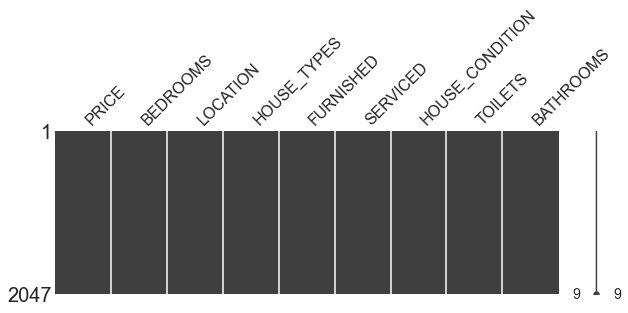

In [112]:
#check for missing values
missingno.matrix(df,figsize = (10,3));

In [113]:
#check for duplicates
df.duplicated().sum()

0

In [114]:
df.nunique()

PRICE              169
BEDROOMS             9
LOCATION            41
HOUSE_TYPES          6
FURNISHED            2
SERVICED             2
HOUSE_CONDITION      2
TOILETS              9
BATHROOMS            9
dtype: int64

In [115]:
#this function checks for the most frequent values and gives information about them since we can't afford to have too much a feature with too much values
def get_full_report(x):
    cnt = ( x.value_counts(ascending=False,dropna=False).head(1).index.values[0],
               100 * x.value_counts(ascending=False,dropna=False).head(1).values[0]/df.shape[0],
               x.value_counts(ascending=False,dropna=False).head(1).values[0])
    return cnt

In [116]:
#this is a report of the data
un_df= df.apply(lambda x: get_full_report(x)).rename(index={0:'Values',1:'Percentage',2:'Count'}).T.sort_values(by = 'Count',ascending = False)
un_df

Values Percentage  Count
SERVICED                NO  99.413776   2035
HOUSE_CONDITION        OLD  96.775769   1981
FURNISHED               NO  63.800684   1306
HOUSE_TYPES           FLAT  56.717147   1161
BEDROOMS               3.0     28.383  581.0
TOILETS                3.0     28.383  581.0
BATHROOMS              3.0     28.383  581.0
LOCATION             Lekki  21.152907    433
PRICE            1000000.0   3.663898   75.0

In [117]:
df_copy = df.copy()

In [118]:
#eda

In [119]:
#a function that plots count for location
def plot_count(df,col):
    sns.set()
    location_fr = df[col].value_counts()
    ord_frq = location_fr.index
    fig,ax = plt.subplots(figsize =(10,25))
    sns.countplot(y = col,data = df,order=ord_frq)
    plt.xlabel(str(col))
    plt.ylabel('COUNT')
    plt.show()

In [120]:
### Feature Location

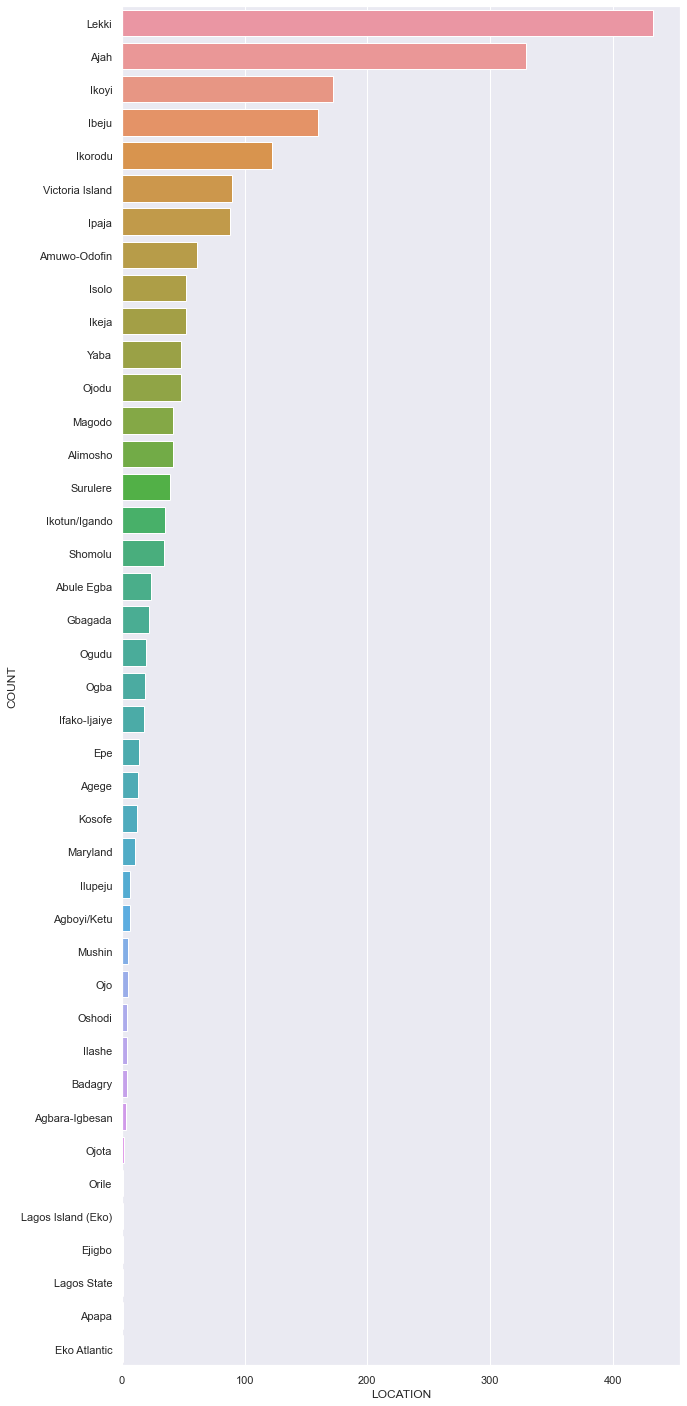

In [121]:
plot_count(df,'LOCATION') #before fixing the location column

In [122]:
### Feature house type

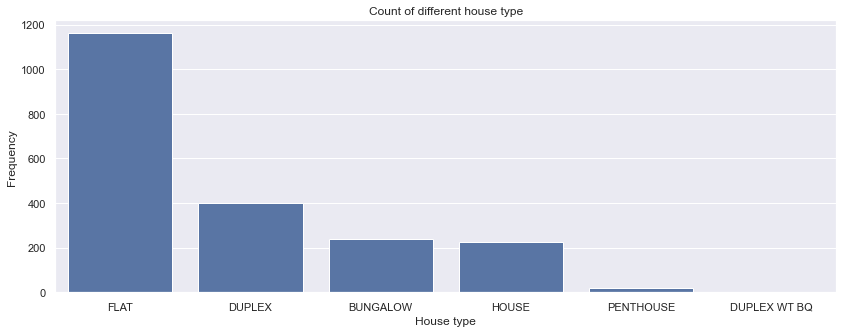

In [123]:
sns.set()
fig,ax = plt.subplots(figsize = (14,5))
location_fr = df['HOUSE_TYPES'].value_counts()
ord_frq = location_fr.index
sns.countplot(x = 'HOUSE_TYPES',data=df,color = sns.color_palette()[0],order = ord_frq)
#plt.ylim([0,50000])
plt.xlabel('House type')
plt.ylabel('Frequency')
plt.title('Count of different house type');

In [124]:
df['HOUSE_TYPES'].value_counts()

FLAT            1161
DUPLEX           400
BUNGALOW         238
HOUSE            227
PENTHOUSE         19
DUPLEX WT BQ       2
Name: HOUSE_TYPES, dtype: int64

In [125]:
## Feature bedrooms

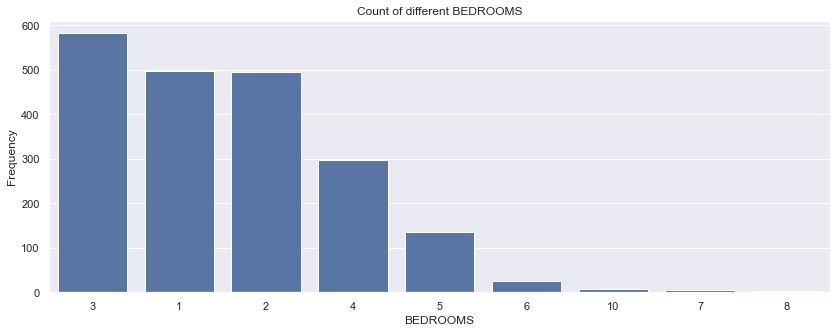

In [126]:
sns.set()
fig,ax = plt.subplots(figsize = (14,5))
location_fr = df['BEDROOMS'].value_counts()
ord_frq = location_fr.index
sns.countplot(x = 'BEDROOMS',data=df,color = sns.color_palette()[0],order = ord_frq)
#plt.ylim([0,50000])
plt.xlabel('BEDROOMS')
plt.ylabel('Frequency')
plt.title('Count of different BEDROOMS');

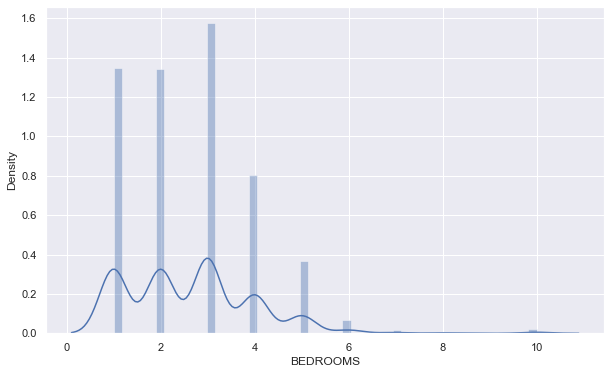

In [127]:
fig,ax = plt.subplots(figsize = (10,6))
sns.distplot(df['BEDROOMS']);

In [128]:
## Feature bathrooms

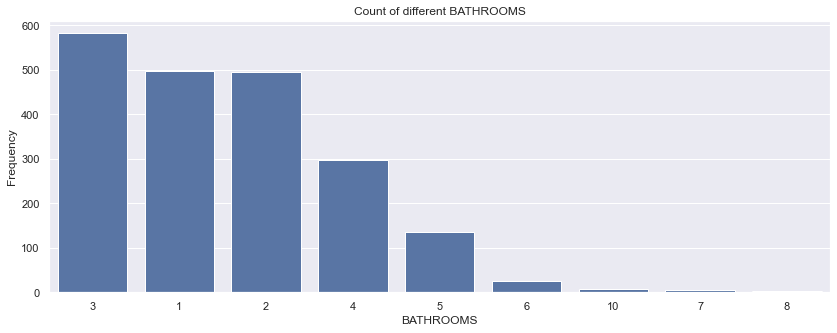

In [129]:
sns.set()
fig,ax = plt.subplots(figsize = (14,5))
location_fr = df['BATHROOMS'].value_counts()
ord_frq = location_fr.index
sns.countplot(x = 'BATHROOMS',data=df,color = sns.color_palette()[0],order = ord_frq)
#plt.ylim([0,50000])
plt.xlabel('BATHROOMS')
plt.ylabel('Frequency')
plt.title('Count of different BATHROOMS');

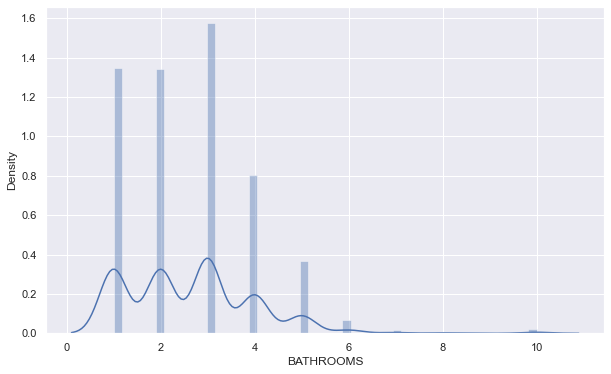

In [130]:
#as we can see price is very positively skewed
fig,ax = plt.subplots(figsize = (10,6))
sns.distplot(df['BATHROOMS']);

In [131]:
## Feature toilets

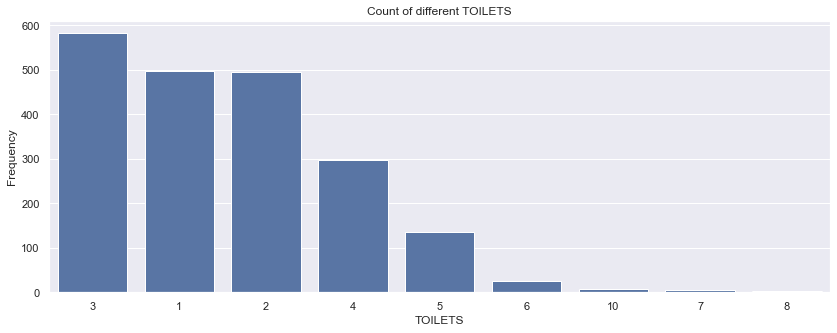

In [132]:
sns.set()
fig,ax = plt.subplots(figsize = (14,5))
location_fr = df['TOILETS'].value_counts()
ord_frq = location_fr.index
sns.countplot(x = 'TOILETS',data=df,color = sns.color_palette()[0],order = ord_frq)
#plt.ylim([0,50000])
plt.xlabel('TOILETS')
plt.ylabel('Frequency')
plt.title('Count of different TOILETS');

In [133]:
##Feaure price

In [134]:
df['PRICE'].describe()

count    2.047000e+03
mean     5.331773e+06
std      3.069510e+07
min      1.500000e+04
25%      7.000000e+05
50%      1.800000e+06
75%      4.900000e+06
max      1.300000e+09
Name: PRICE, dtype: float64

In [135]:
1.300000e+09

1300000000.0

37.247097


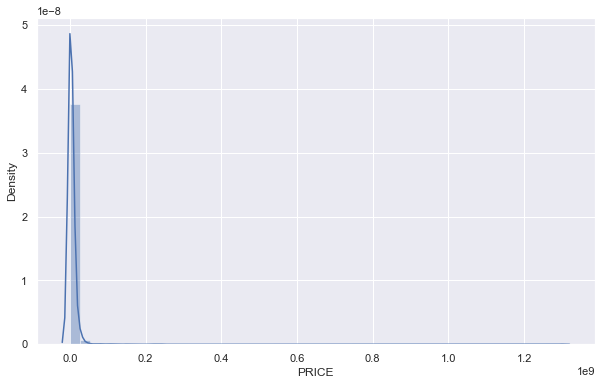

In [136]:
#as we can see price is very positively skewed
fig,ax = plt.subplots(figsize = (10,6))
sns.distplot(df['PRICE'])
print(df['PRICE'].skew()) #price is very positively skewed

37.247097


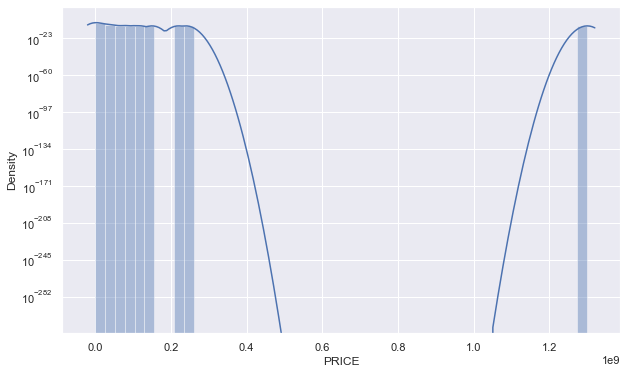

In [137]:
#as we can see price is very positively skewed after taking the logarithm of the price
fig,ax = plt.subplots(figsize = (10,6))
sns.distplot(df['PRICE'])
plt.yscale('log')
print(df['PRICE'].skew()) #price is very positively skewed

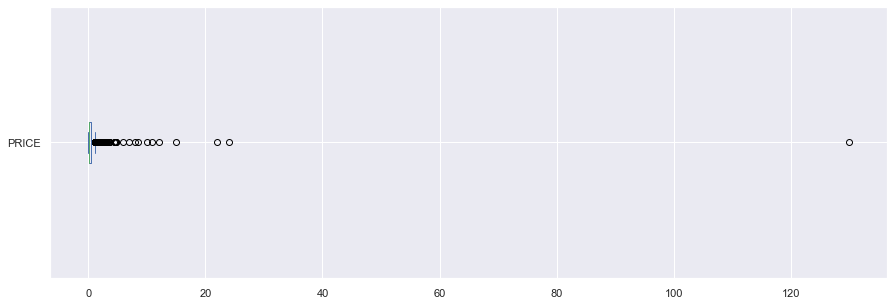

In [138]:
#check for outliers
fig,ax = plt.subplots(figsize = (15,5))
(df['PRICE'] / 1e7).plot(kind = 'box',vert = False); #there are no outliers there so we can do a time series analysis

In [139]:
#there is that one outlier that needs fixing

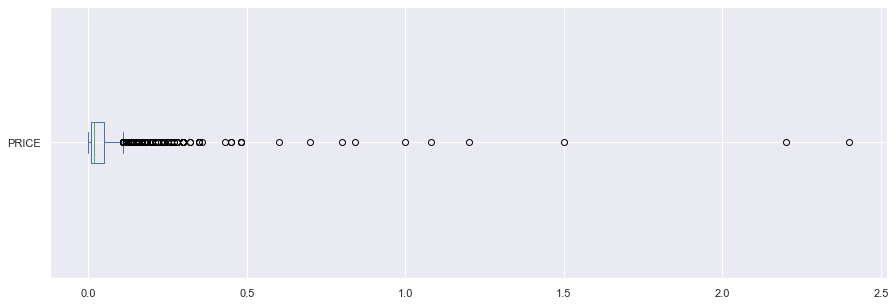

In [140]:
fig,ax = plt.subplots(figsize = (15,5))
(df[df['PRICE'] != 1300000000.0]['PRICE'] / 1e8).plot(kind = 'box',vert = False);

In [141]:
#they keep appearing

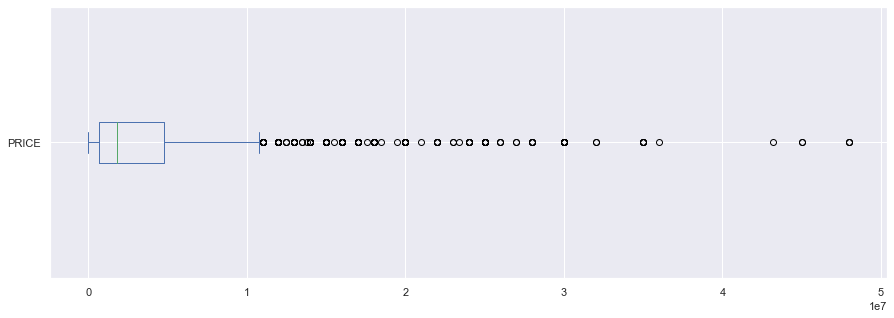

In [142]:
fig,ax = plt.subplots(figsize = (15,5))
df[df['PRICE'] < 50000000]['PRICE'].plot(kind = 'box',vert = False);#i thinnk we can leave it at 50mil

In [143]:
#all this just shows that more people would take apartments around the 

In [144]:
#mask price 
mask = df.loc[(df['PRICE'] < 1e5 )|(df['PRICE'] > 100000000)].index
df_copy = df.drop(mask) #keep maximum price at 100 mil

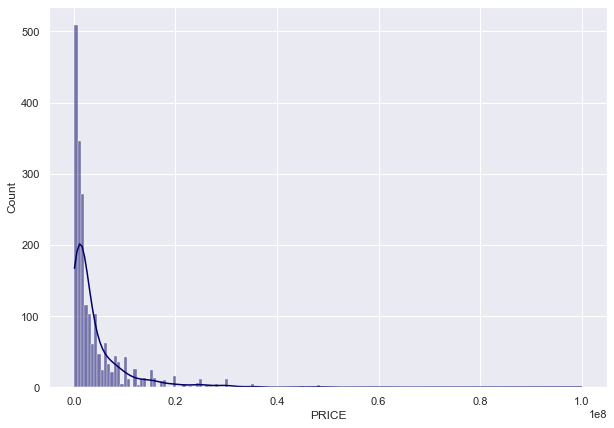

In [145]:
sns.set()
plt.figure(figsize=[10, 7])
sns.histplot(df_copy['PRICE'],kde = True,color="#000066")
plt.show()

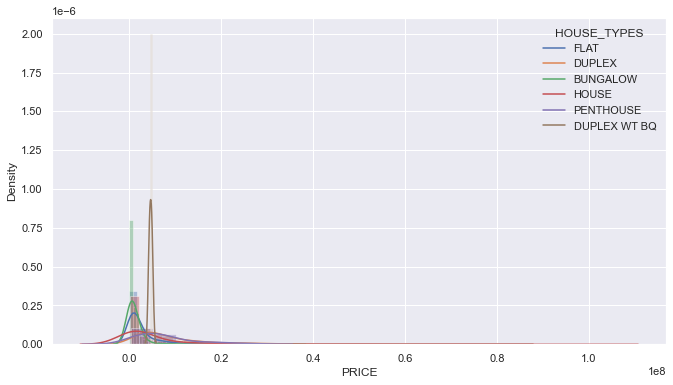

In [146]:
sns.set_style('darkgrid')
plt.subplots(figsize = (11,6))
sns.distplot(df_copy[df['HOUSE_TYPES'] == 'FLAT']['PRICE'],kde_kws = {'label':'FLAT'})
sns.distplot(df_copy[df['HOUSE_TYPES'] == 'DUPLEX']['PRICE'],kde_kws = {'label':'DUPLEX'})
sns.distplot(df_copy[df['HOUSE_TYPES'] == 'BUNGALOW']['PRICE'],kde_kws = {'label':'BUNGALOW'})
sns.distplot(df_copy[df['HOUSE_TYPES'] == 'HOUSE']['PRICE'],kde_kws = {'label':'HOUSE'})
sns.distplot(df_copy[df['HOUSE_TYPES'] == 'PENTHOUSE']['PRICE'],kde_kws = {'label':'PENTHOUSE'})
sns.distplot(df_copy[df['HOUSE_TYPES'] == 'DUPLEX WT BQ']['PRICE'],kde_kws = {'label':'DUPLEX WT BQ'})
plt.legend(title = 'HOUSE_TYPES')
plt.show()

In [147]:
def plot_frq(df,col):
    fig,ax =plt.subplots(figsize = (11,6))
    sns.regplot(data = df,x = col,y = 'PRICE')
    plt.xlabel(str(col))
    plt.ylabel('PRICE')
    plt.show()

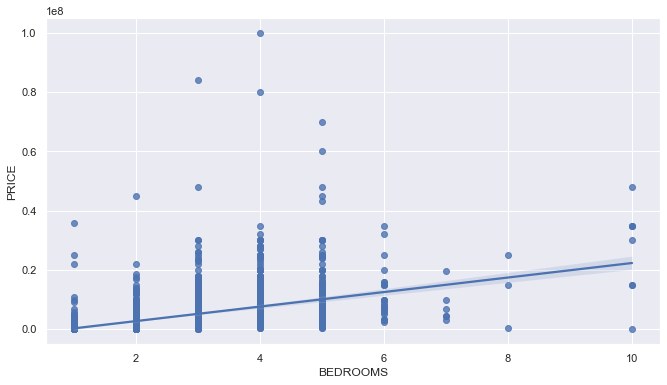

In [148]:
plot_frq(df_copy,'BEDROOMS')

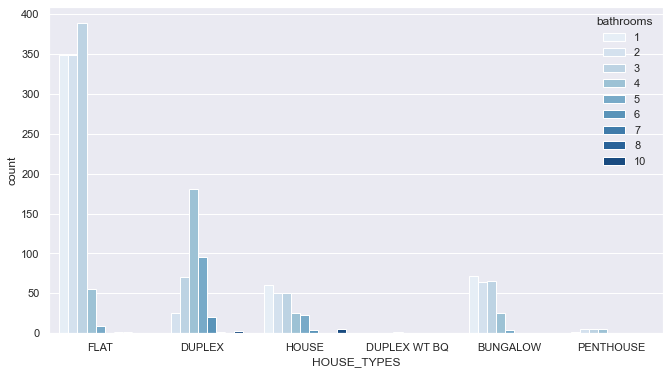

In [149]:
sns.set_style('darkgrid')
plt.figure(figsize = (11,6))
sns.countplot(data=df_copy,x = 'HOUSE_TYPES',hue = 'BATHROOMS',palette = 'Blues')
plt.legend(loc = 'upper right',title = 'bathrooms')
plt.show()

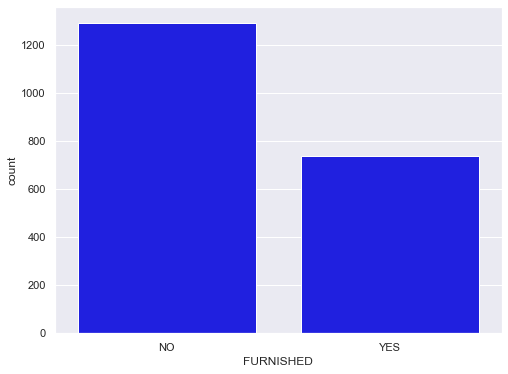

In [150]:
plt.figure(figsize = (8,6))
f_frq = df_copy.FURNISHED.value_counts()
f_ut_frq = f_frq.index
sns.countplot(data=df_copy,x = 'FURNISHED',order = f_ut_frq,color = 'blue')
plt.show()

In [151]:
f_frq

NO     1291
YES     737
Name: FURNISHED, dtype: int64

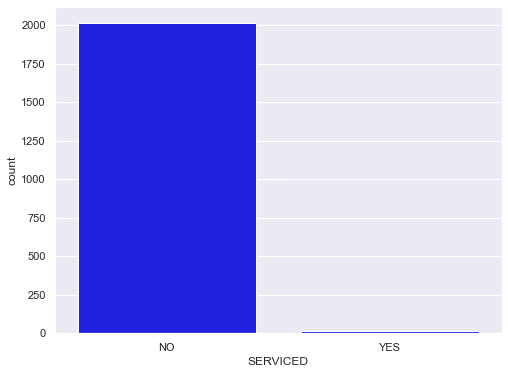

In [152]:
plt.figure(figsize = (8,6))
f_frq = df_copy.SERVICED.value_counts()
f_ut_frq = f_frq.index
sns.countplot(data=df_copy,x = 'SERVICED',order = f_ut_frq,color = 'blue')
plt.show()

In [153]:
f_frq

NO     2016
YES      12
Name: SERVICED, dtype: int64

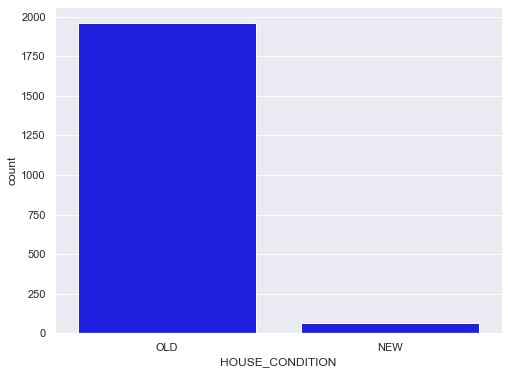

In [154]:
plt.figure(figsize = (8,6))
f_frq = df_copy.HOUSE_CONDITION.value_counts()
f_ut_frq = f_frq.index
sns.countplot(data=df_copy,x = 'HOUSE_CONDITION',order = f_ut_frq,color = 'blue')
plt.show()

In [155]:
df_copy

PRICE  BEDROOMS         LOCATION HOUSE_TYPES FURNISHED SERVICED  \
0      2500000.0         2            Lekki        FLAT        NO       NO   
1      2500000.0         3            Lekki        FLAT        NO       NO   
2     10000000.0         3  Victoria Island        FLAT        NO       NO   
3     11000000.0         3            Ikoyi        FLAT       YES       NO   
4      2900000.0         3            Ogudu        FLAT       YES       NO   
...          ...       ...              ...         ...       ...      ...   
5499    200000.0         1            Ibeju        FLAT       YES       NO   
5504    150000.0         1            Ipaja        FLAT        NO       NO   
5505    250000.0         1              Epe        FLAT       YES       NO   
5507    200000.0         1            Ipaja        FLAT        NO       NO   
5510    450000.0         1         Surulere        FLAT       YES       NO   

     HOUSE_CONDITION  TOILETS  BATHROOMS  
0                OLD        2          2  
1                OLD        3          3  
2                OLD        3          3  
3                OLD        3          3  
4                OLD        3          3  
...              ...      ...        ...  
5499             OLD        1          1  
5504             OLD        1          1  
5505             OLD        1          1  
5507             OLD        1          1  
5510             OLD        1          1  

[2028 rows x 9 columns]

In [156]:
f_frq

OLD    1962
NEW      66
Name: HOUSE_CONDITION, dtype: int64

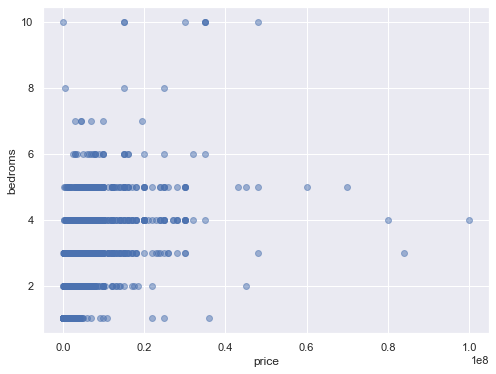

In [157]:
plt.figure(figsize = (8,6))
plt.scatter(data = df_copy,x = 'PRICE',y = 'BEDROOMS',alpha=0.5)
plt.xlabel('price')
plt.ylabel('bedroms')
plt.show()

In [158]:
#check numerical values against cats

<Figure size 1440x720 with 0 Axes>

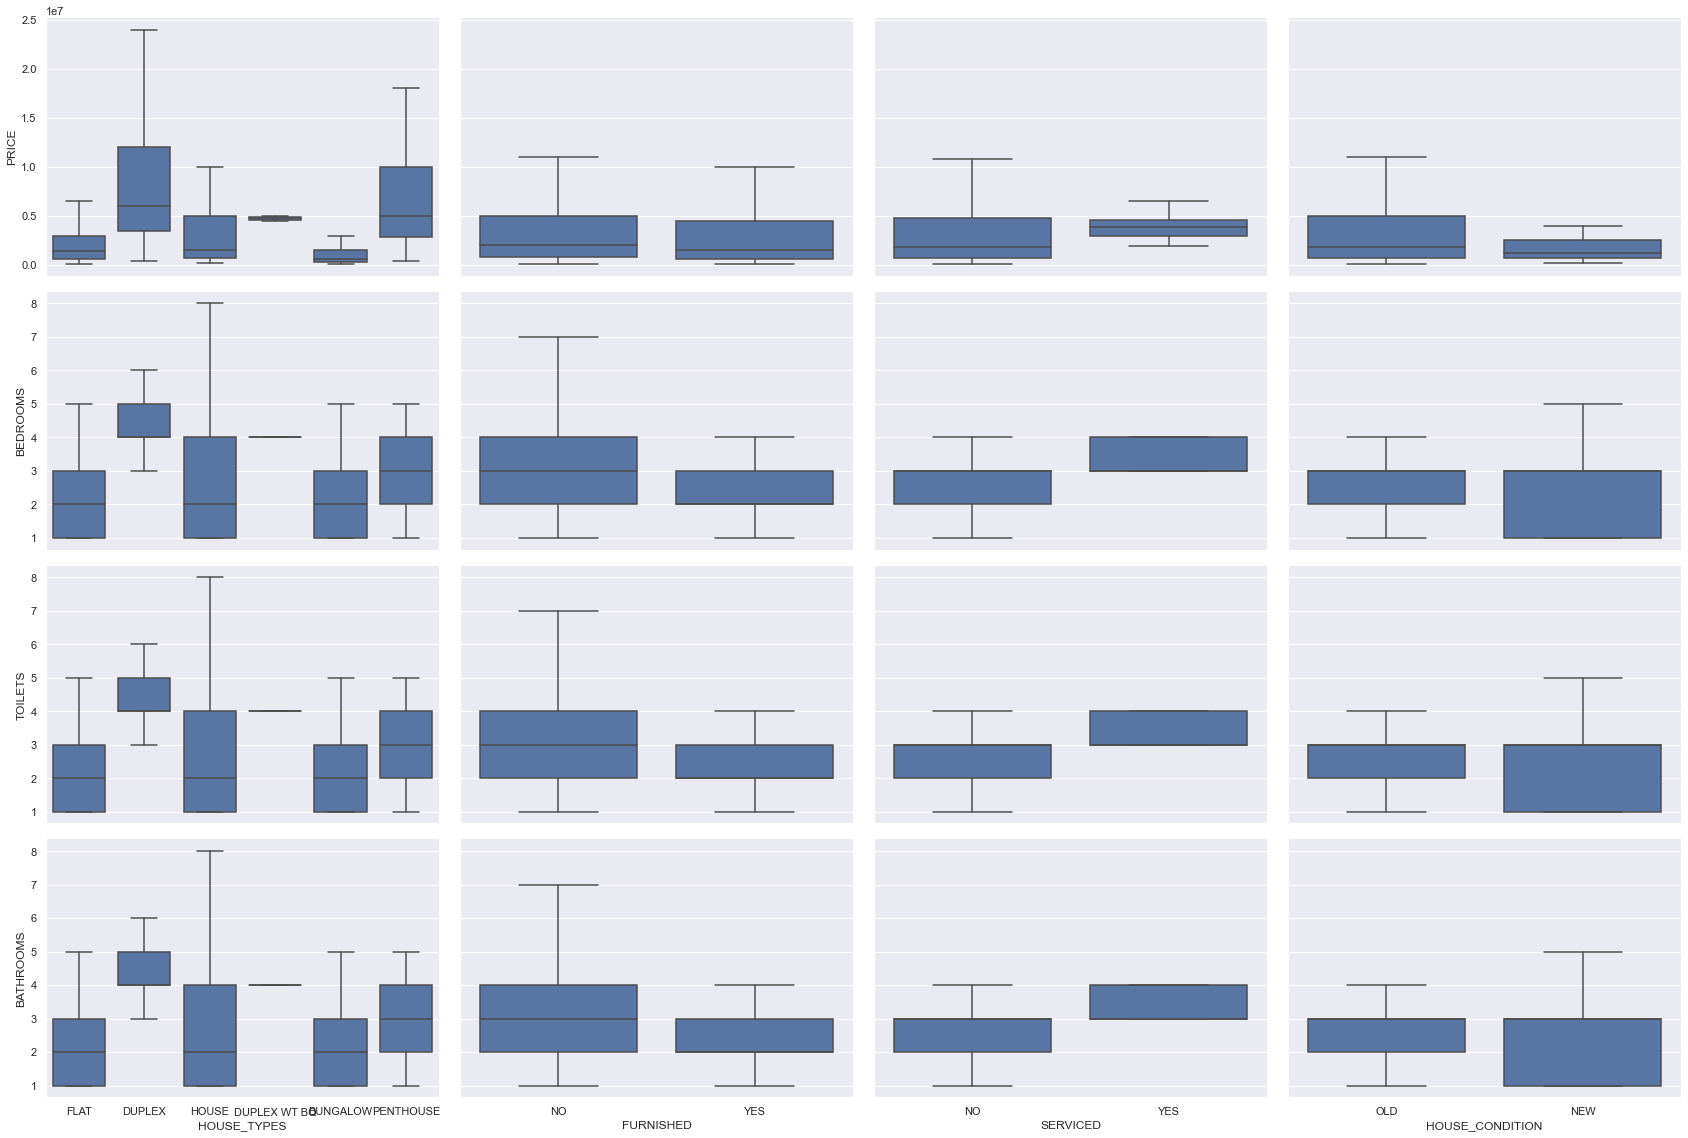

In [159]:
num_v = [col for col in df_copy.select_dtypes('number')]
cate_v = [col for col in df_copy.select_dtypes('O')if not col == 'LOCATION']
plt.figure(figsize = (20,10))
g  = sns.PairGrid(data=df_copy,x_vars=cate_v,y_vars=num_v,aspect = 1.5,size = 4)
g.map(sns.boxplot,color = sns.color_palette()[0],showfliers = False)
plt.show()

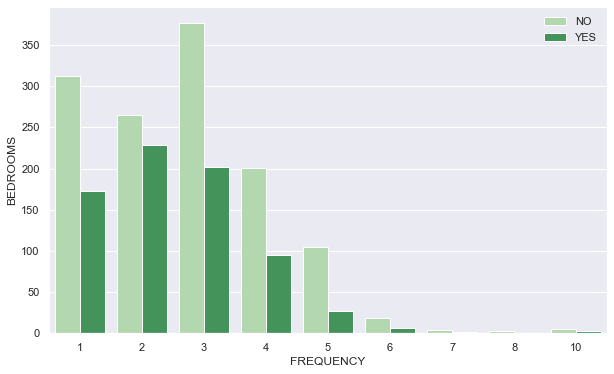

In [160]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_copy,x = 'BEDROOMS',hue = 'FURNISHED',palette = 'Greens')
plt.xlabel('FREQUENCY')
plt.ylabel('BEDROOMS')
plt.legend(loc = 'upper right')
plt.show()

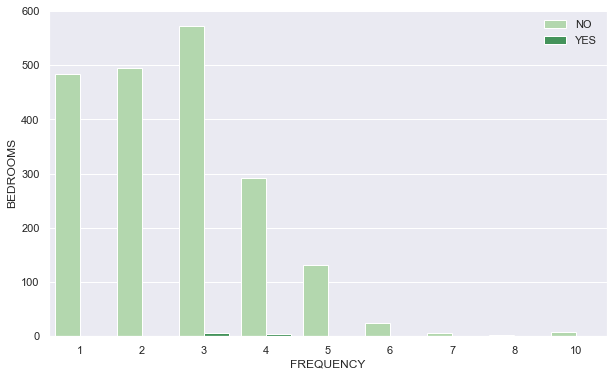

In [161]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_copy,x = 'BEDROOMS',hue = 'SERVICED',palette = 'Greens')
plt.xlabel('FREQUENCY')
plt.ylabel('BEDROOMS')
plt.legend(loc = 'upper right')
plt.show()

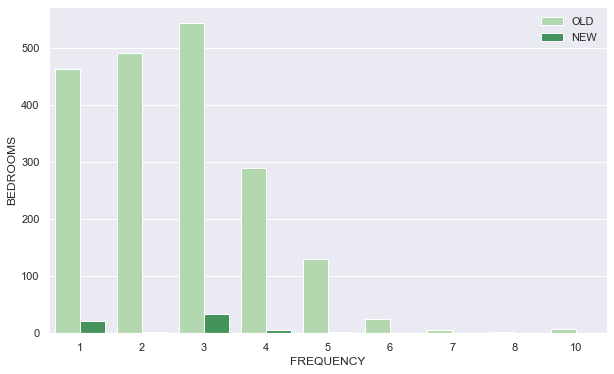

In [162]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_copy,x = 'BEDROOMS',hue = 'HOUSE_CONDITION',palette = 'Greens')
plt.xlabel('FREQUENCY')
plt.ylabel('BEDROOMS')
plt.legend(loc = 'upper right')
plt.show()

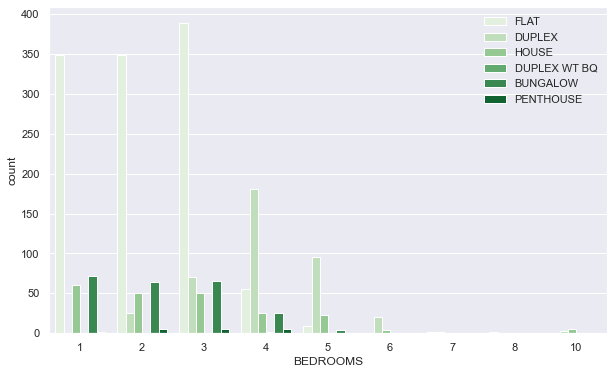

In [163]:
plt.figure(figsize = (10,6))
sns.countplot(data=df_copy,x = 'BEDROOMS',hue = 'HOUSE_TYPES',palette = 'Greens')
plt.legend(loc = 'upper right')
plt.show()

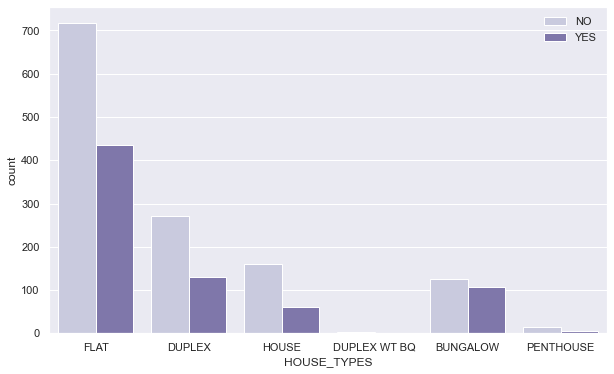

In [164]:
plt.figure(figsize = (10,6))
sns.countplot(data=df_copy,x = 'HOUSE_TYPES',hue = 'FURNISHED',palette = 'Purples')
plt.legend(loc = 'best')
plt.show()

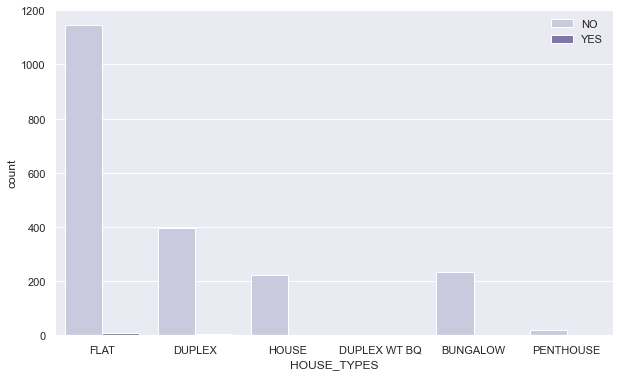

In [165]:
plt.figure(figsize = (10,6))
sns.countplot(data=df_copy,x = 'HOUSE_TYPES',hue = 'SERVICED',palette = 'Purples')
plt.legend(loc = 'best')
plt.show()

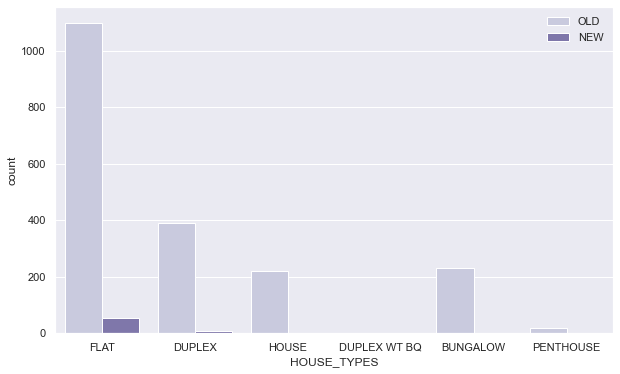

In [166]:
plt.figure(figsize = (10,6))
sns.countplot(data=df_copy,x = 'HOUSE_TYPES',hue = 'HOUSE_CONDITION',palette = 'Purples')
plt.legend(loc = 'upper right')
plt.show()

In [167]:
#checking the mean of location and house type to price
g_df = df_copy.groupby(['LOCATION','HOUSE_TYPES'])['PRICE'].mean().reset_index()
print_full(df_copy.groupby(['LOCATION','HOUSE_TYPES'])['PRICE'].max().reset_index())

               LOCATION   HOUSE_TYPES                PRICE
0            Abule Egba      BUNGALOW           700,000.00
1            Abule Egba        DUPLEX         3,500,000.00
2            Abule Egba          FLAT         1,200,000.00
3        Agbara-Igbesan      BUNGALOW           300,000.00
4        Agbara-Igbesan          FLAT           500,000.00
5           Agboyi/Ketu        DUPLEX         1,500,000.00
6           Agboyi/Ketu          FLAT         1,500,000.00
7           Agboyi/Ketu         HOUSE           250,000.00
8                 Agege      BUNGALOW         2,000,000.00
9                 Agege        DUPLEX         1,300,000.00
10                Agege          FLAT         1,000,000.00
11                 Ajah      BUNGALOW        35,000,000.00
12                 Ajah        DUPLEX        43,200,000.00
13                 Ajah          FLAT        22,000,000.00
14                 Ajah         HOUSE        15,000,000.00
15                 Ajah     PENTHOUSE         2,800,000.

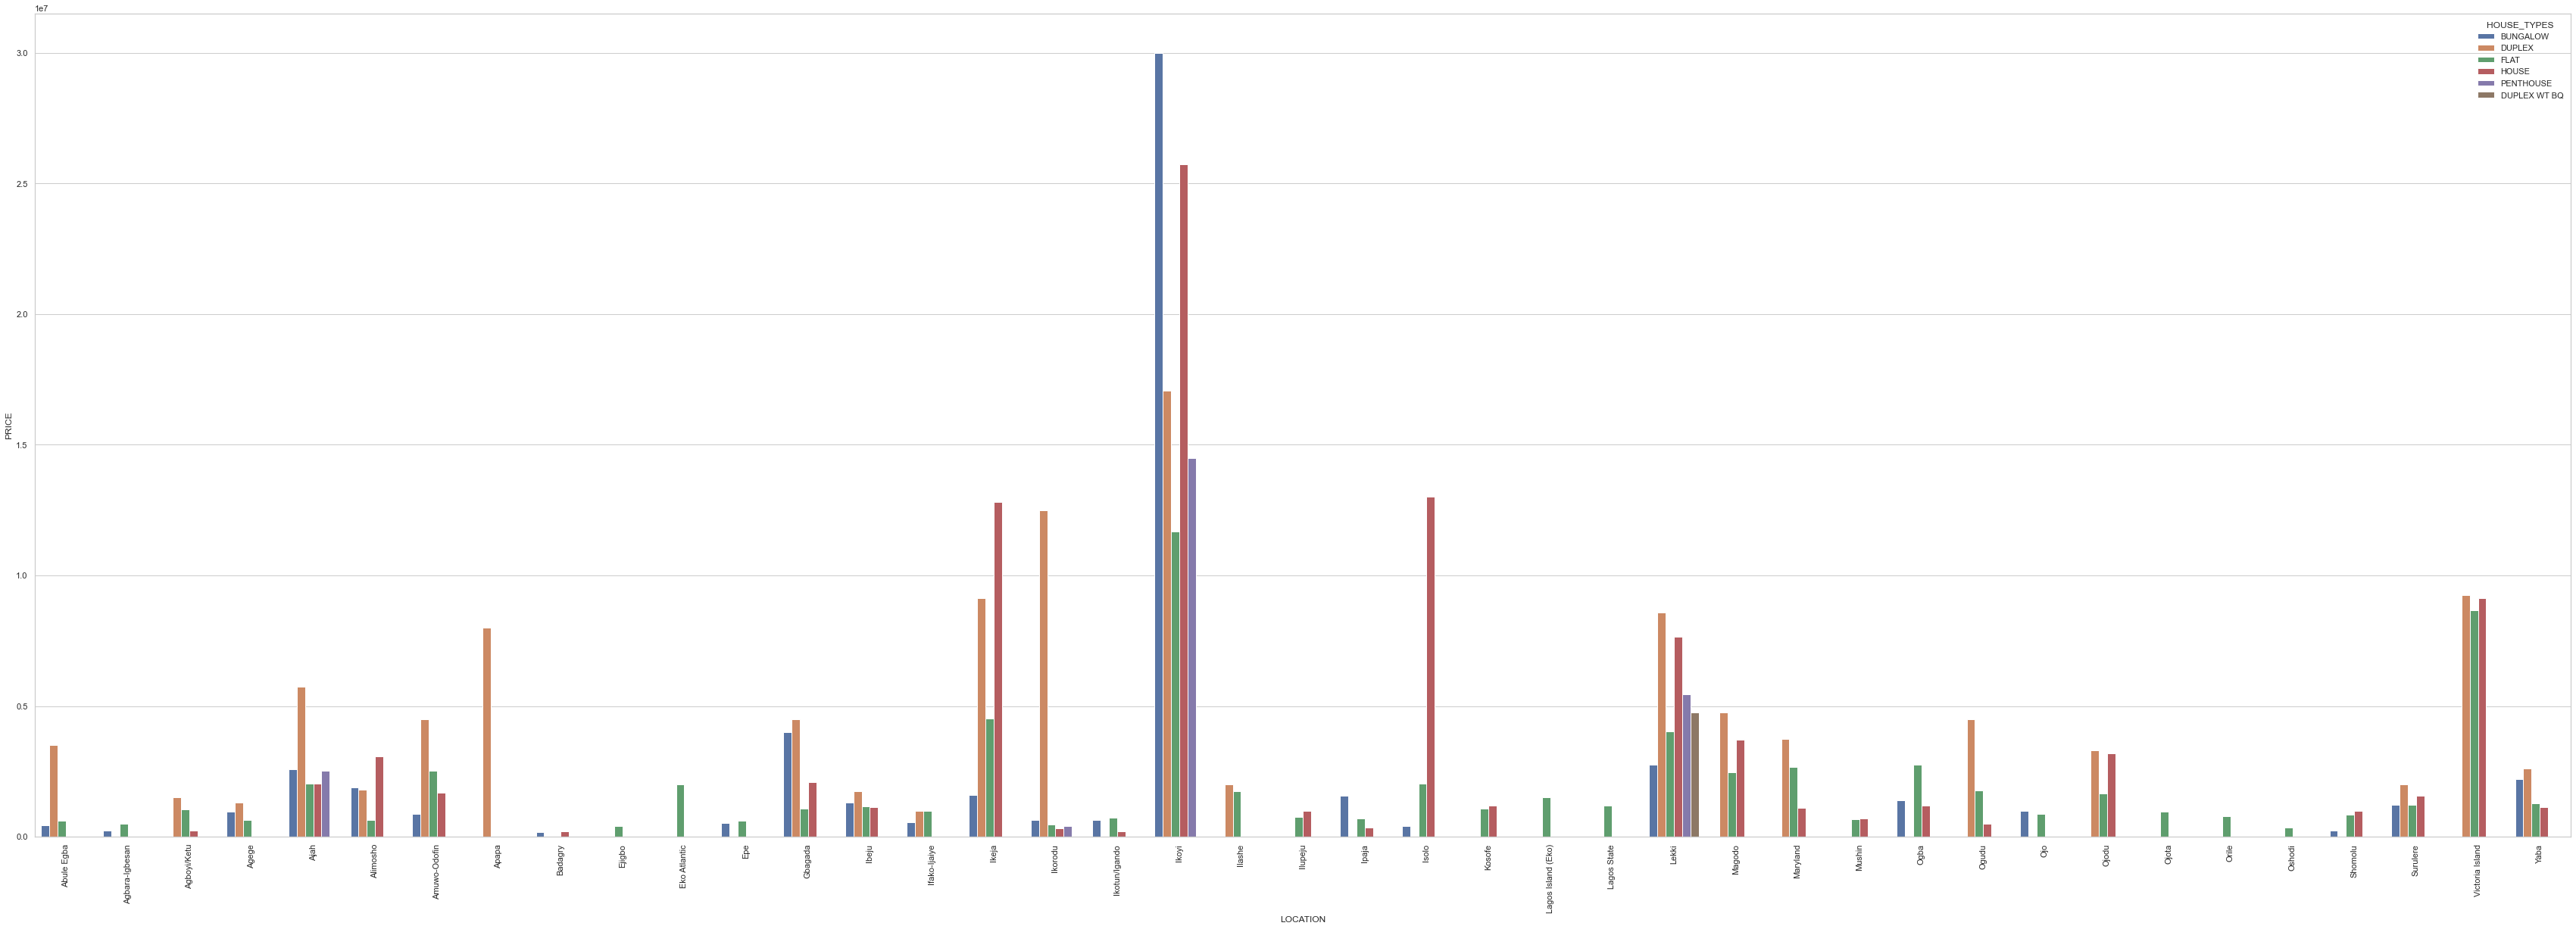

In [168]:
sns.set_style('whitegrid')
plt.subplots(figsize = (60,20))
sns.barplot(x = 'LOCATION',y = 'PRICE',hue = 'HOUSE_TYPES',data = g_df)
plt.xticks(rotation = 90)
plt.show()

In [169]:
#we will see the most epensive areas

In [170]:
fig = px.bar(x = g_df['LOCATION'],y = g_df['PRICE'],color = g_df['HOUSE_TYPES'],height = 600)
fig.update_layout(xaxis_title = 'Location',yaxis_title = 'PRICE',title = 'location by house type and mean price')
fig.show()

In [171]:
#we will see the most expensive areas

In [172]:
g_df2 = df.groupby(['LOCATION','HOUSE_TYPES']).sum()[['PRICE']].reset_index()
fig = px.bar(x = g_df2['LOCATION'],y = g_df2['PRICE'],color = g_df['HOUSE_TYPES'],height = 600)
fig.update_layout(xaxis_title = 'Location',yaxis_title = 'PRICE',title = 'location by house type and sum price')
fig.show()

In [173]:
#the correlation of numerical variables
corr = df_copy[['BEDROOMS','BATHROOMS','TOILETS','PRICE']].corr()
corr.style.background_gradient(axis = None)

<Figure size 576x432 with 0 Axes>

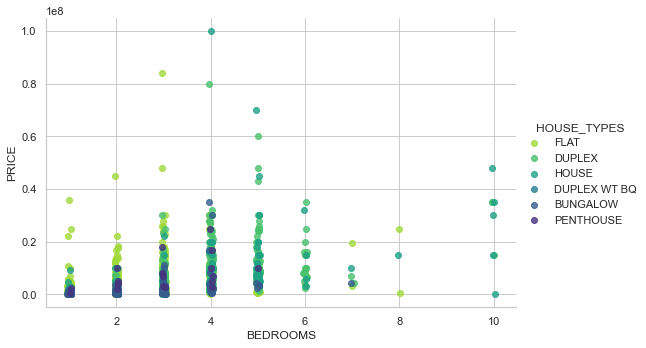

In [174]:
plt.figure(figsize = (8,6))
g = sns.FacetGrid(data=df_copy,hue = 'HOUSE_TYPES',size = 5,aspect = 1.5,palette='viridis_r')
g.map(sns.regplot,'BEDROOMS','PRICE',x_jitter = 0.04,fit_reg = False)
g.add_legend(title = 'HOUSE_TYPES')
plt.show()

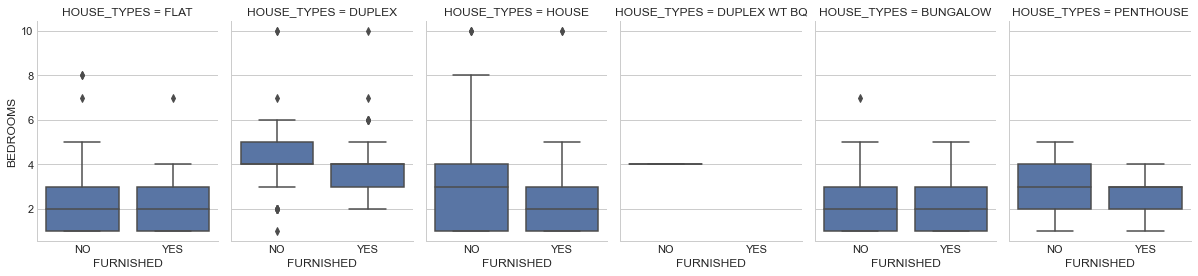

In [175]:
plt.style.use('seaborn-whitegrid')
g = sns.FacetGrid(df_copy, col='HOUSE_TYPES', size=4, aspect=.7)
g = g.map(sns.boxplot, 'FURNISHED', 'BEDROOMS')

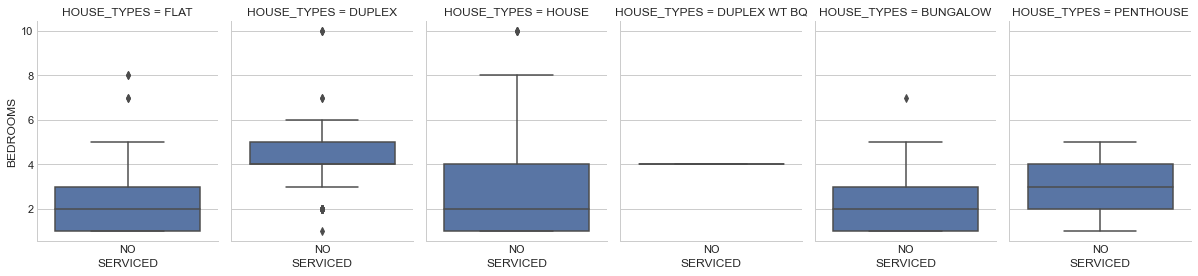

In [176]:
plt.style.use('seaborn-whitegrid')
g = sns.FacetGrid(df_copy, col='HOUSE_TYPES', size=4, aspect=.7)
g = g.map(sns.boxplot, 'SERVICED', 'BEDROOMS')

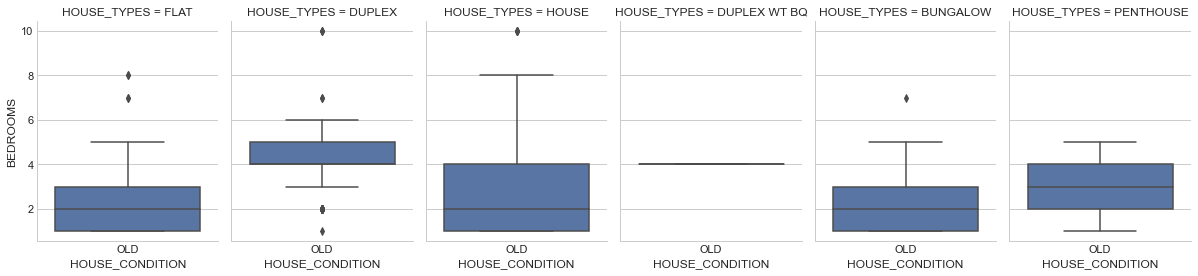

In [177]:
plt.style.use('seaborn-whitegrid')
g = sns.FacetGrid(df_copy, col='HOUSE_TYPES', size=4, aspect=.7)
g = g.map(sns.boxplot, 'HOUSE_CONDITION', 'BEDROOMS')

In [178]:
## feature importance

<Figure size 504x360 with 0 Axes>

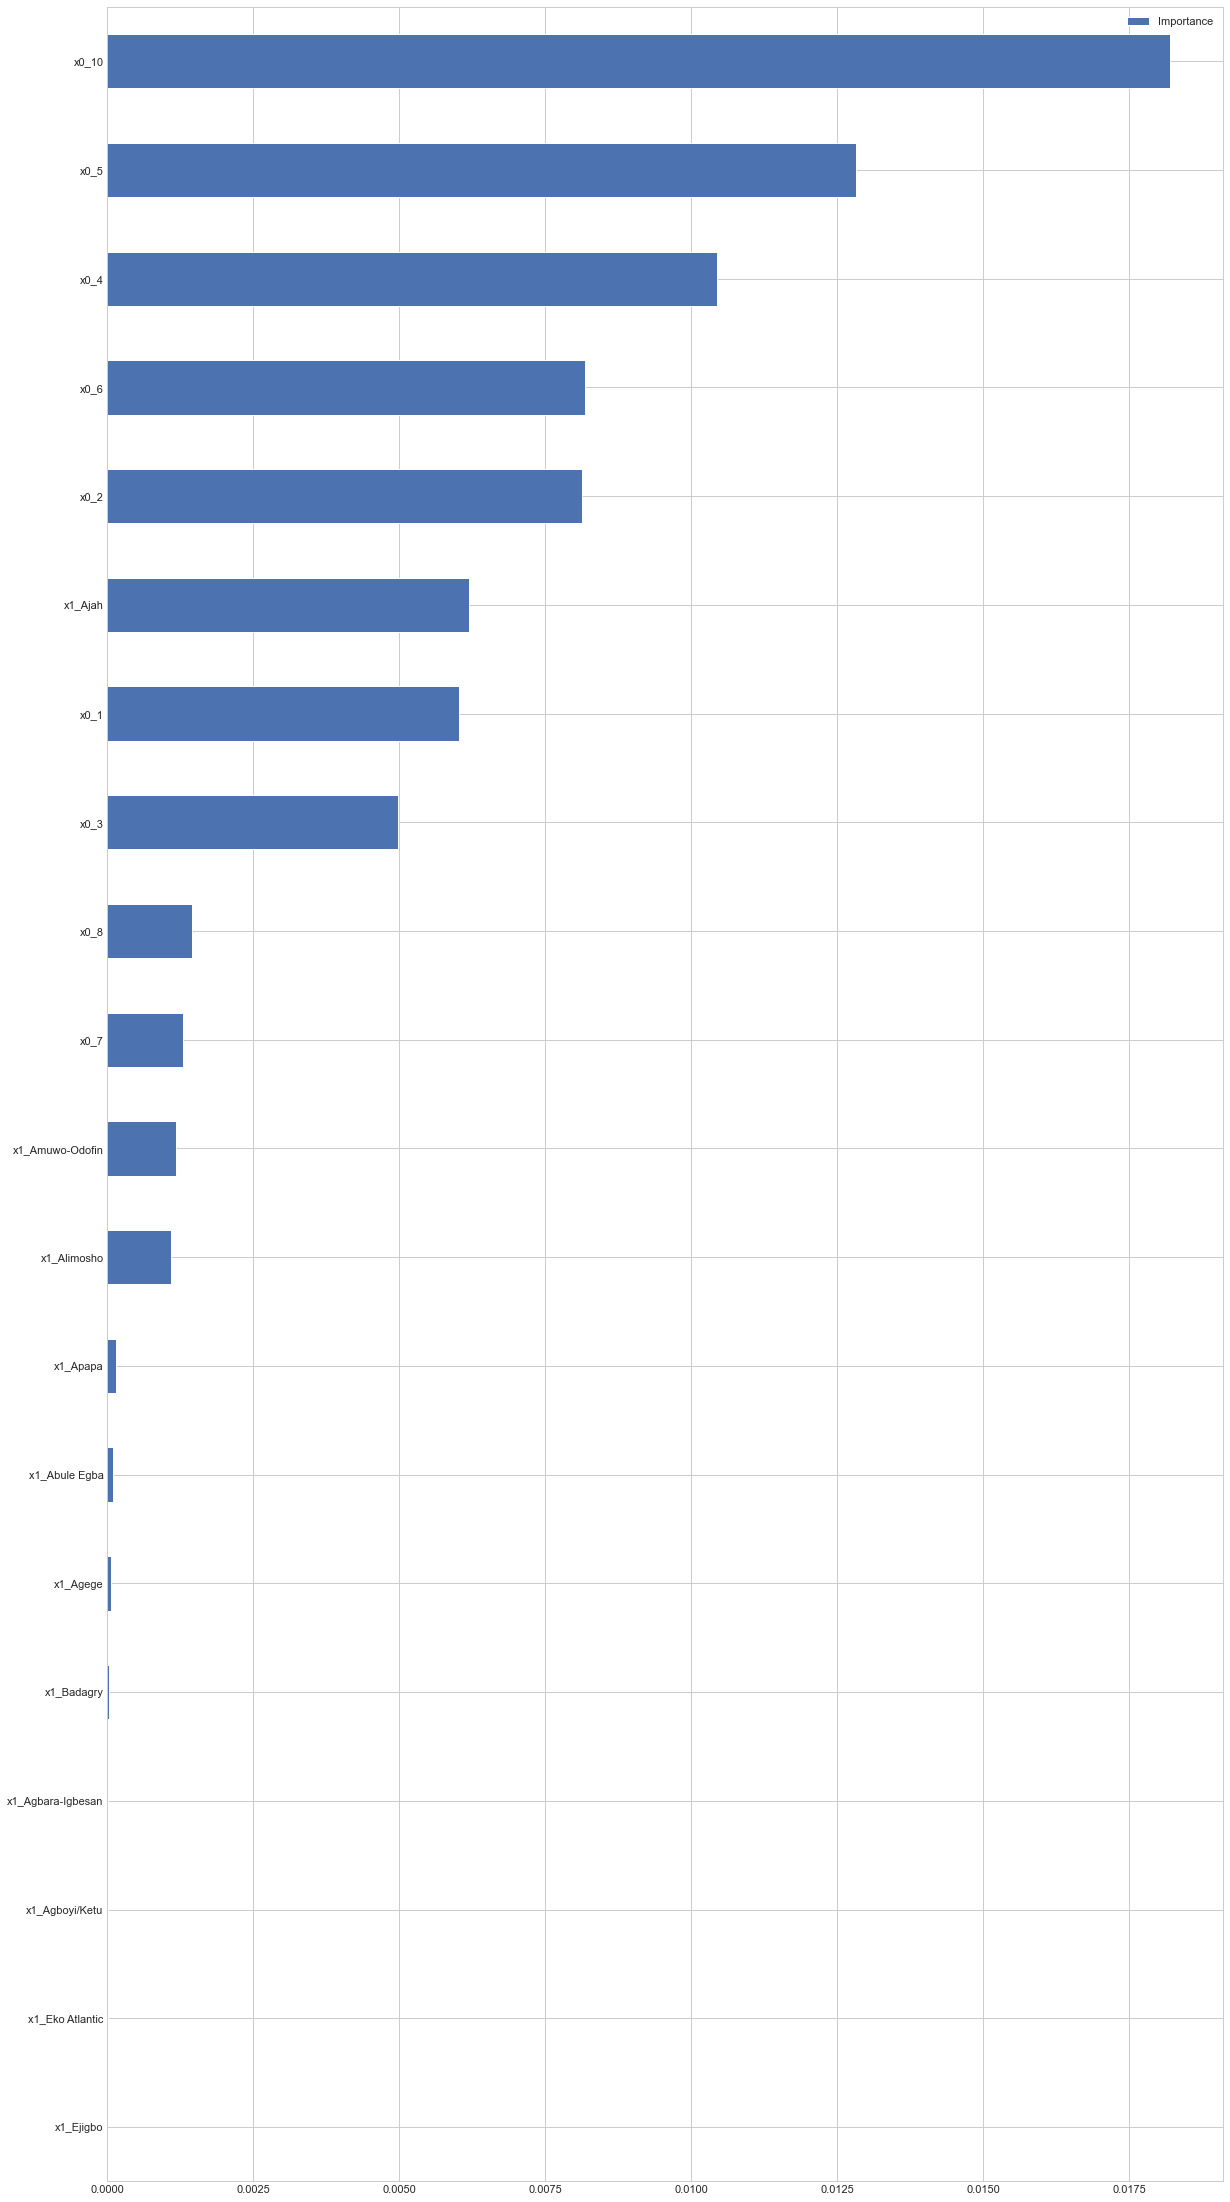

In [179]:
plt.figure(figsize = (7,5))
clf = make_pipeline(OneHotEncoder(handle_unknown='ignore'),RandomForestRegressor(random_state=42))
clf.fit(df_copy.drop('PRICE',axis = 1),df_copy['PRICE'])

plt.style.use('seaborn-whitegrid')
importance = clf.named_steps['randomforestregressor'].feature_importances_
importance = pd.DataFrame(importance, index=clf.named_steps['onehotencoder'].get_feature_names(), columns=["Importance"])
importance[:20].sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

#### PCA
Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.

We can use PCA to reduce the number of features to use in our ML algorithms, and graphing the variance gives us an idea of how many features we really need to represent our dataset fully.

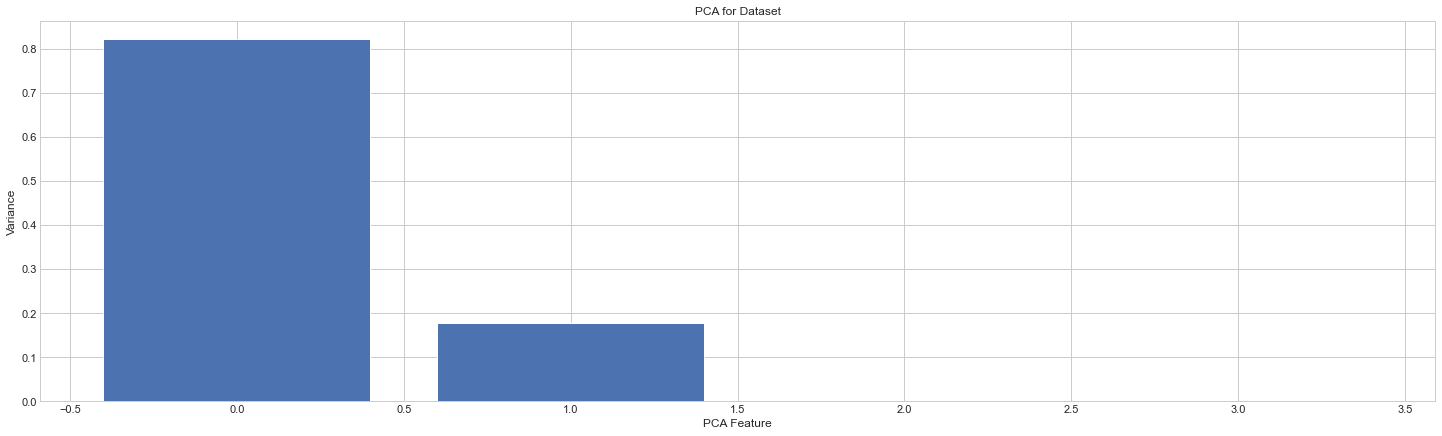

In [180]:
#calculate pca for the dataset
scale = StandardScaler().fit(df_copy[[col for col in df_copy.select_dtypes('number')]])
X = scale.transform(df_copy[[col for col in df_copy.select_dtypes('number')]])
pca1 = PCA(n_components = 4)
fit1 = pca1.fit(X)
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (25,7))
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Dataset')
plt.bar(range(0, fit1.explained_variance_ratio_.size), fit1.explained_variance_ratio_);

In [90]:
## Feature engineering
def feat_eng(df):
    #i will try to create some more features from the one available and scale log scale it
    df['LOG_PRICE_PER_ROOM'] = np.log(df_copy['PRICE']/df_copy['BEDROOMS'])
    df['PRICE_PER_ROOM'] = df_copy['PRICE']/df_copy['BEDROOMS']
    return df
df_copy = feat_eng(df_copy)
#there is more that could be done

In [181]:
df_copy

PRICE  BEDROOMS         LOCATION HOUSE_TYPES FURNISHED SERVICED  \
0      2500000.0         2            Lekki        FLAT        NO       NO   
1      2500000.0         3            Lekki        FLAT        NO       NO   
2     10000000.0         3  Victoria Island        FLAT        NO       NO   
3     11000000.0         3            Ikoyi        FLAT       YES       NO   
4      2900000.0         3            Ogudu        FLAT       YES       NO   
...          ...       ...              ...         ...       ...      ...   
5499    200000.0         1            Ibeju        FLAT       YES       NO   
5504    150000.0         1            Ipaja        FLAT        NO       NO   
5505    250000.0         1              Epe        FLAT       YES       NO   
5507    200000.0         1            Ipaja        FLAT        NO       NO   
5510    450000.0         1         Surulere        FLAT       YES       NO   

     HOUSE_CONDITION  TOILETS  BATHROOMS  
0                OLD        2          2  
1                OLD        3          3  
2                OLD        3          3  
3                OLD        3          3  
4                OLD        3          3  
...              ...      ...        ...  
5499             OLD        1          1  
5504             OLD        1          1  
5505             OLD        1          1  
5507             OLD        1          1  
5510             OLD        1          1  

[2028 rows x 9 columns]

In [182]:
#create feature matrix
X_all = df_copy.drop('PRICE',axis = 1)
y_all = df_copy['PRICE']
X_train,X_test,y_train,y_test = train_test_split(X_all,y_all,test_size=0.30,random_state=42)

In [183]:
#mutal info scoring
#Feature selection is an important preprocessing step for many high-dimensional regression problems. One of the most common strategies is to select a relevant feature subset based on the mutual information criterion.
cat_col = [col for col in X_train.columns if X_train[col].dtypes == 'object']
dis_feat = cat_col + [col for col in X_train.select_dtypes('number')]
X_mi = X_train.copy()
y_mi = y_train.copy()

ord_enc = sklearn_ord(dtype = 'int32')
X_mi[cat_col] = ord_enc.fit_transform(X_mi[cat_col])

mi_scores = mutual_info_classif(X_mi,y_mi)
mi_scores = pd.Series(mi_scores,index = X_mi.columns)
mi_scores = mi_scores.sort_values(ascending = False)
mi_scores

HOUSE_CONDITION    0.701451
BATHROOMS          0.481201
BEDROOMS           0.443303
TOILETS            0.435249
LOCATION           0.335778
HOUSE_TYPES        0.205949
SERVICED           0.048631
FURNISHED          0.000000
dtype: float64

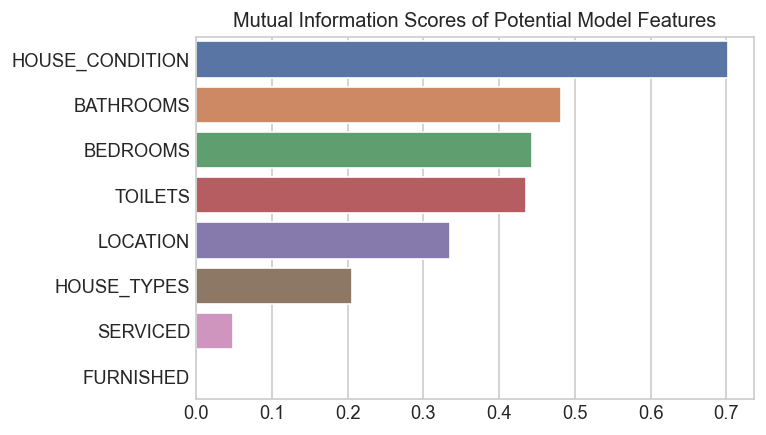

In [184]:
#  Visualising MI scores
plt.figure(dpi=120)
sns.barplot(x = mi_scores.values, y = mi_scores.index)
plt.title('Mutual Information Scores of Potential Model Features');

In [185]:
#model building

In [186]:
#scoring
def rmse(y_actual,y_preds):
    return np.sqrt(mean_squared_error(y_actual,y_preds))
# create function to evaluate model on a few different levels
def get_scores_model(model,X_train,X_test,y_train,y_test):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    cv_train_score = cross_val_score(model,X_train,y_train,scoring='neg_mean_squared_error',cv = 5)
    cv_test_score = cross_val_score(model,X_test,y_test,scoring='neg_mean_squared_error',cv = 5)
    scores = {'Training MAE':mean_absolute_error(y_train,train_preds),
             'test MAE':mean_absolute_error(y_test,test_preds),
             'Training RMSE':rmse(y_train,train_preds),
             'test RMSE':rmse(y_test,test_preds),
             'Training R^2':r2_score(y_train,train_preds),
             'test R^2':r2_score(y_test,test_preds),
             'train cross val score':cv_train_score.mean(),
              'test cross val score':cv_test_score.mean()
             }
    return scores

In [187]:
def plot_learining_curve(train_score,test_score):
    #for m in range(1,len(X_train)):
        #model.fit(X_train[:m],y_train[:m])
        #y_train_pred = model.predict(X_train[:m])
        #y_val_pred = model.predict(X_val)
        #train_score.append(mean_squared_error(y_train[:m],y_train_pred))
        #val_score.append(mean_squared_error(y_val,y_val_pred))
    plt.plot(train_score,'r-+',lw = 2,marker = 'o')
    plt.plot(test_score,'b-',lw = 3,marker = '^')

In [188]:
#feature scaling and model building
def modeler(X_all,y_all):
    X_train,X_test,y_train,y_test = train_test_split(X_all,y_all,test_size=0.20,random_state=42)
    model_cat_col = [col for col in X_all.select_dtypes('O')]
    model_num_col = [col for col in X_all.select_dtypes('number')]
    #scale values
    #scaler = StandardScaler().fit(X_train[model_num_col])
    #X_train[model_num_col] = scaler.transform(X_train[model_num_col]) #i just passed it to the pipeline
    #creating transformers
    #print(model_cat_col)
    #print(model_num_col)
    cat_transformer = Pipeline(steps = [
        ('imputer',SimpleImputer(strategy = 'most_frequent')),
        ('onehot',OneHotEncoder(handle_unknown='ignore'))
    ])
    num_transformer = Pipeline(steps = [
        ('imputer',SimpleImputer(strategy = 'mean'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('cat',cat_transformer,model_cat_col),
        ('num',num_transformer,model_num_col)
    ])
    model_metrics = dict()
    cv_score = []
    model_dict = {'SVR':SVR(),
             'SGDRegressor':SGDRegressor(random_state=42,tol=1e-3),
             'DecisionTreeRegressor':DecisionTreeRegressor(random_state=42,criterion='poisson'),
             'RandomForestRegressor':RandomForestRegressor(random_state=42),
             'XGBRegressor':XGBRegressor(),
             'CatBoostRegressor':CatBoostRegressor(),
             'GradientBoostingRegressor':GradientBoostingRegressor(random_state=42),
             'Lasso':Lasso(random_state=42),
             'Ridge':Ridge(random_state=42,solver='sag'),
             'LinearRegression':LinearRegression(n_jobs=-1),
             'knn' : KNeighborsRegressor(n_neighbors=16, algorithm="ball_tree")
            }
    for model_name,model in model_dict.items():
        mod = Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('scaler',StandardScaler(with_mean=False)),
        ('model',model)
        ])
        mod.fit(X_train,y_train)
        pred = mod.predict(X_test)
        model_metrics[model_name] = get_scores_model(mod,X_train,X_test,y_train,y_test)
        neg_dt_score = cross_val_score(mod,X_test,y_test,scoring='neg_mean_squared_error',cv = 5)
        avg_neg_dt_score = np.sqrt(-neg_dt_score)
        cv_score.append(avg_neg_dt_score.mean())
        print(f'{model_name} training score  is {mod.score(X_train,y_train)}')
        print(f'{model_name} test score  is {mod.score(X_test,y_test)}')
        print(f'{model_name} cross val score with scoring neg_mean_squared_error and cv = 5: \nmean===>{avg_neg_dt_score.mean():.3f}%\nstd===>{avg_neg_dt_score.std():.3f}%')
        print('-' * 24)
    return model_metrics,pd.Series(cv_score,index = [m_n for m_n in model_dict])

In [189]:
met_scores,cv_series = modeler(X_all,y_all)
met_scores = pd.DataFrame(met_scores)

SVR training score  is -0.12399426886530884
SVR test score  is -0.13308492777907932
SVR cross val score with scoring neg_mean_squared_error and cv = 5: 
mean===>6580881.086%
std===>1822949.885%
------------------------
SGDRegressor training score  is 0.26680870703681014
SGDRegressor test score  is 0.22697540584285614
SGDRegressor cross val score with scoring neg_mean_squared_error and cv = 5: 
mean===>4819504.875%
std===>1299761.946%
------------------------
DecisionTreeRegressor training score  is 0.6411227766667711
DecisionTreeRegressor test score  is -0.15325884824159153
DecisionTreeRegressor cross val score with scoring neg_mean_squared_error and cv = 5: 
mean===>4171406.239%
std===>260806.994%
------------------------
RandomForestRegressor training score  is 0.6040705782638396
RandomForestRegressor test score  is 0.24636662286614464
RandomForestRegressor cross val score with scoring neg_mean_squared_error and cv = 5: 
mean===>3965672.684%
std===>883877.253%
-----------------------

166:	learn: 4976901.6290900	total: 491ms	remaining: 2.45s
167:	learn: 4973647.8376066	total: 492ms	remaining: 2.44s
168:	learn: 4971686.4617719	total: 493ms	remaining: 2.42s
169:	learn: 4969549.4463062	total: 494ms	remaining: 2.41s
170:	learn: 4965785.8260742	total: 495ms	remaining: 2.4s
171:	learn: 4962433.4794029	total: 496ms	remaining: 2.39s
172:	learn: 4960510.5526258	total: 497ms	remaining: 2.38s
173:	learn: 4957450.6016057	total: 498ms	remaining: 2.36s
174:	learn: 4955320.1347125	total: 499ms	remaining: 2.35s
175:	learn: 4951926.1041476	total: 500ms	remaining: 2.34s
176:	learn: 4949091.7764303	total: 501ms	remaining: 2.33s
177:	learn: 4947200.3482115	total: 502ms	remaining: 2.32s
178:	learn: 4943782.7947685	total: 503ms	remaining: 2.31s
179:	learn: 4941789.9999071	total: 504ms	remaining: 2.3s
180:	learn: 4938368.4741862	total: 505ms	remaining: 2.29s
181:	learn: 4936156.0368402	total: 506ms	remaining: 2.27s
182:	learn: 4936074.8862791	total: 507ms	remaining: 2.26s
183:	learn: 4934

334:	learn: 4690030.0616212	total: 657ms	remaining: 1.3s
335:	learn: 4688823.3299088	total: 659ms	remaining: 1.3s
336:	learn: 4688573.1453648	total: 660ms	remaining: 1.3s
337:	learn: 4688019.0896695	total: 661ms	remaining: 1.29s
338:	learn: 4687273.7590542	total: 662ms	remaining: 1.29s
339:	learn: 4686578.4533203	total: 663ms	remaining: 1.29s
340:	learn: 4685870.6182673	total: 664ms	remaining: 1.28s
341:	learn: 4684864.9305904	total: 665ms	remaining: 1.28s
342:	learn: 4684481.2839964	total: 666ms	remaining: 1.27s
343:	learn: 4683804.3990832	total: 667ms	remaining: 1.27s
344:	learn: 4681710.5442129	total: 668ms	remaining: 1.27s
345:	learn: 4680833.9861901	total: 669ms	remaining: 1.26s
346:	learn: 4679757.8722101	total: 670ms	remaining: 1.26s
347:	learn: 4679164.8321166	total: 671ms	remaining: 1.26s
348:	learn: 4678498.9498993	total: 673ms	remaining: 1.25s
349:	learn: 4678004.3207440	total: 674ms	remaining: 1.25s
350:	learn: 4676969.3491179	total: 675ms	remaining: 1.25s
351:	learn: 46764

503:	learn: 4589956.8735694	total: 826ms	remaining: 813ms
504:	learn: 4589681.6213172	total: 827ms	remaining: 810ms
505:	learn: 4589182.1510306	total: 828ms	remaining: 808ms
506:	learn: 4589149.6198151	total: 829ms	remaining: 806ms
507:	learn: 4588971.0330210	total: 830ms	remaining: 804ms
508:	learn: 4588707.6585403	total: 831ms	remaining: 801ms
509:	learn: 4588359.6675499	total: 832ms	remaining: 799ms
510:	learn: 4587635.4262791	total: 833ms	remaining: 797ms
511:	learn: 4586750.7240014	total: 834ms	remaining: 795ms
512:	learn: 4586696.1616196	total: 835ms	remaining: 792ms
513:	learn: 4586241.0016978	total: 836ms	remaining: 790ms
514:	learn: 4585898.2372950	total: 837ms	remaining: 788ms
515:	learn: 4585458.9100445	total: 838ms	remaining: 786ms
516:	learn: 4585258.5117382	total: 839ms	remaining: 784ms
517:	learn: 4584747.8768575	total: 840ms	remaining: 782ms
518:	learn: 4584553.5848385	total: 841ms	remaining: 779ms
519:	learn: 4584357.0487490	total: 842ms	remaining: 777ms
520:	learn: 45

714:	learn: 4525708.3191709	total: 1.15s	remaining: 459ms
715:	learn: 4525541.3191840	total: 1.15s	remaining: 458ms
716:	learn: 4525208.4887440	total: 1.15s	remaining: 456ms
717:	learn: 4524906.8507070	total: 1.16s	remaining: 454ms
718:	learn: 4524609.5468822	total: 1.16s	remaining: 452ms
719:	learn: 4524408.4944993	total: 1.16s	remaining: 450ms
720:	learn: 4524120.3401447	total: 1.16s	remaining: 448ms
721:	learn: 4523867.4389459	total: 1.16s	remaining: 447ms
722:	learn: 4523792.4995277	total: 1.16s	remaining: 445ms
723:	learn: 4523647.1324290	total: 1.16s	remaining: 443ms
724:	learn: 4523424.2029687	total: 1.16s	remaining: 441ms
725:	learn: 4523091.1749794	total: 1.16s	remaining: 439ms
726:	learn: 4522879.8438715	total: 1.16s	remaining: 437ms
727:	learn: 4522680.2294484	total: 1.17s	remaining: 436ms
728:	learn: 4522331.1907758	total: 1.17s	remaining: 434ms
729:	learn: 4522027.8918579	total: 1.17s	remaining: 432ms
730:	learn: 4521700.6378719	total: 1.17s	remaining: 430ms
731:	learn: 45

883:	learn: 4490998.3321796	total: 1.32s	remaining: 173ms
884:	learn: 4490841.4319968	total: 1.32s	remaining: 172ms
885:	learn: 4490749.3746935	total: 1.32s	remaining: 170ms
886:	learn: 4490742.9650043	total: 1.32s	remaining: 169ms
887:	learn: 4490547.2061389	total: 1.32s	remaining: 167ms
888:	learn: 4490407.9421121	total: 1.32s	remaining: 165ms
889:	learn: 4490401.9879930	total: 1.32s	remaining: 164ms
890:	learn: 4490224.0107977	total: 1.33s	remaining: 162ms
891:	learn: 4490054.0116428	total: 1.33s	remaining: 161ms
892:	learn: 4489922.7346896	total: 1.33s	remaining: 159ms
893:	learn: 4489856.0501306	total: 1.33s	remaining: 158ms
894:	learn: 4489809.3024019	total: 1.33s	remaining: 156ms
895:	learn: 4489674.5489850	total: 1.33s	remaining: 155ms
896:	learn: 4489481.6395400	total: 1.33s	remaining: 153ms
897:	learn: 4489344.5346091	total: 1.33s	remaining: 151ms
898:	learn: 4488990.7384483	total: 1.33s	remaining: 150ms
899:	learn: 4488908.9541493	total: 1.33s	remaining: 148ms
900:	learn: 44

174:	learn: 4916768.5244615	total: 158ms	remaining: 743ms
175:	learn: 4913215.9463438	total: 159ms	remaining: 743ms
176:	learn: 4910499.8052773	total: 159ms	remaining: 741ms
177:	learn: 4907643.1521513	total: 160ms	remaining: 740ms
178:	learn: 4904068.5815124	total: 161ms	remaining: 739ms
179:	learn: 4901811.5393368	total: 162ms	remaining: 738ms
180:	learn: 4899157.9372543	total: 163ms	remaining: 738ms
181:	learn: 4896725.8094495	total: 164ms	remaining: 737ms
182:	learn: 4893087.6675938	total: 165ms	remaining: 736ms
183:	learn: 4891467.4127176	total: 166ms	remaining: 735ms
184:	learn: 4889572.9202535	total: 167ms	remaining: 734ms
185:	learn: 4886834.7083867	total: 167ms	remaining: 732ms
186:	learn: 4883761.8742007	total: 168ms	remaining: 731ms
187:	learn: 4882697.6274735	total: 169ms	remaining: 730ms
188:	learn: 4879035.8165414	total: 170ms	remaining: 730ms
189:	learn: 4876416.1893467	total: 171ms	remaining: 729ms
190:	learn: 4875140.9090759	total: 172ms	remaining: 729ms
191:	learn: 48

359:	learn: 4665803.4221252	total: 324ms	remaining: 575ms
360:	learn: 4665235.1324378	total: 325ms	remaining: 575ms
361:	learn: 4663696.8548113	total: 326ms	remaining: 574ms
362:	learn: 4662714.3056667	total: 327ms	remaining: 574ms
363:	learn: 4661540.7291820	total: 328ms	remaining: 573ms
364:	learn: 4660731.2830810	total: 329ms	remaining: 572ms
365:	learn: 4659047.9746797	total: 330ms	remaining: 571ms
366:	learn: 4658656.8561927	total: 331ms	remaining: 570ms
367:	learn: 4658138.9652952	total: 331ms	remaining: 569ms
368:	learn: 4657407.7729545	total: 332ms	remaining: 568ms
369:	learn: 4657157.8276118	total: 333ms	remaining: 567ms
370:	learn: 4656783.4732347	total: 334ms	remaining: 566ms
371:	learn: 4656409.1909957	total: 335ms	remaining: 565ms
372:	learn: 4655896.0462937	total: 336ms	remaining: 565ms
373:	learn: 4655538.8301111	total: 337ms	remaining: 564ms
374:	learn: 4655072.2523522	total: 338ms	remaining: 563ms
375:	learn: 4654694.3234984	total: 339ms	remaining: 562ms
376:	learn: 46

542:	learn: 4587037.4013485	total: 490ms	remaining: 413ms
543:	learn: 4586641.6627287	total: 491ms	remaining: 412ms
544:	learn: 4586274.0616565	total: 492ms	remaining: 411ms
545:	learn: 4586198.6125594	total: 494ms	remaining: 410ms
546:	learn: 4586114.6610025	total: 494ms	remaining: 409ms
547:	learn: 4585998.2061478	total: 495ms	remaining: 409ms
548:	learn: 4585936.3359920	total: 496ms	remaining: 408ms
549:	learn: 4585778.1857722	total: 497ms	remaining: 407ms
550:	learn: 4585655.3358021	total: 498ms	remaining: 406ms
551:	learn: 4585575.1821014	total: 499ms	remaining: 405ms
552:	learn: 4584964.3520711	total: 500ms	remaining: 404ms
553:	learn: 4584615.2785145	total: 501ms	remaining: 403ms
554:	learn: 4584029.0319467	total: 502ms	remaining: 402ms
555:	learn: 4583634.8965847	total: 503ms	remaining: 402ms
556:	learn: 4583291.0776330	total: 504ms	remaining: 401ms
557:	learn: 4583214.5629245	total: 505ms	remaining: 400ms
558:	learn: 4582639.2471684	total: 506ms	remaining: 399ms
559:	learn: 45

797:	learn: 4544646.7817888	total: 813ms	remaining: 206ms
798:	learn: 4544599.0820568	total: 815ms	remaining: 205ms
799:	learn: 4544432.4717809	total: 816ms	remaining: 204ms
800:	learn: 4544419.6364396	total: 817ms	remaining: 203ms
801:	learn: 4544005.4363710	total: 819ms	remaining: 202ms
802:	learn: 4543748.7717649	total: 820ms	remaining: 201ms
803:	learn: 4543637.1850979	total: 821ms	remaining: 200ms
804:	learn: 4543582.0309414	total: 822ms	remaining: 199ms
805:	learn: 4543501.4466046	total: 824ms	remaining: 198ms
806:	learn: 4543483.5343924	total: 825ms	remaining: 197ms
807:	learn: 4543423.0306369	total: 826ms	remaining: 196ms
808:	learn: 4543358.0646069	total: 827ms	remaining: 195ms
809:	learn: 4543201.6738077	total: 829ms	remaining: 194ms
810:	learn: 4543078.2046383	total: 830ms	remaining: 193ms
811:	learn: 4542893.0728784	total: 831ms	remaining: 192ms
812:	learn: 4542884.9978016	total: 832ms	remaining: 191ms
813:	learn: 4542733.0704269	total: 833ms	remaining: 190ms
814:	learn: 45

944:	learn: 4530543.0536308	total: 967ms	remaining: 56.3ms
945:	learn: 4530490.3746169	total: 968ms	remaining: 55.3ms
946:	learn: 4530485.4227469	total: 969ms	remaining: 54.2ms
947:	learn: 4530262.3548608	total: 970ms	remaining: 53.2ms
948:	learn: 4530171.4557815	total: 971ms	remaining: 52.2ms
949:	learn: 4530098.3732895	total: 972ms	remaining: 51.2ms
950:	learn: 4530009.3970168	total: 973ms	remaining: 50.1ms
951:	learn: 4529975.2569789	total: 974ms	remaining: 49.1ms
952:	learn: 4529970.2875256	total: 975ms	remaining: 48.1ms
953:	learn: 4529842.7081388	total: 976ms	remaining: 47.1ms
954:	learn: 4529773.8619353	total: 977ms	remaining: 46ms
955:	learn: 4529683.5845585	total: 978ms	remaining: 45ms
956:	learn: 4529584.0811534	total: 979ms	remaining: 44ms
957:	learn: 4529579.4320683	total: 980ms	remaining: 43ms
958:	learn: 4529540.6861229	total: 981ms	remaining: 42ms
959:	learn: 4529444.1831566	total: 982ms	remaining: 40.9ms
960:	learn: 4529388.2106671	total: 983ms	remaining: 39.9ms
961:	le

247:	learn: 4401920.0818413	total: 220ms	remaining: 668ms
248:	learn: 4401038.8559733	total: 221ms	remaining: 668ms
249:	learn: 4398909.1535669	total: 222ms	remaining: 667ms
250:	learn: 4397373.3704644	total: 223ms	remaining: 667ms
251:	learn: 4395798.0297706	total: 224ms	remaining: 666ms
252:	learn: 4393742.8639454	total: 225ms	remaining: 665ms
253:	learn: 4391657.3930178	total: 226ms	remaining: 664ms
254:	learn: 4389635.5795492	total: 227ms	remaining: 663ms
255:	learn: 4389003.4436562	total: 228ms	remaining: 662ms
256:	learn: 4387067.6109071	total: 229ms	remaining: 662ms
257:	learn: 4386042.4533608	total: 230ms	remaining: 661ms
258:	learn: 4385434.3057673	total: 231ms	remaining: 660ms
259:	learn: 4384666.9228001	total: 232ms	remaining: 659ms
260:	learn: 4383223.4491384	total: 233ms	remaining: 658ms
261:	learn: 4382487.9294668	total: 233ms	remaining: 657ms
262:	learn: 4381774.5634625	total: 234ms	remaining: 657ms
263:	learn: 4381223.1753459	total: 235ms	remaining: 656ms
264:	learn: 43

428:	learn: 4239124.8011336	total: 386ms	remaining: 514ms
429:	learn: 4238743.8087590	total: 387ms	remaining: 513ms
430:	learn: 4237890.0187195	total: 388ms	remaining: 513ms
431:	learn: 4237787.3425706	total: 389ms	remaining: 512ms
432:	learn: 4237357.4656977	total: 390ms	remaining: 511ms
433:	learn: 4237144.8788649	total: 391ms	remaining: 510ms
434:	learn: 4236689.3977161	total: 392ms	remaining: 509ms
435:	learn: 4236053.6259745	total: 393ms	remaining: 508ms
436:	learn: 4235848.8756041	total: 394ms	remaining: 507ms
437:	learn: 4235651.3242184	total: 395ms	remaining: 506ms
438:	learn: 4235395.2327339	total: 395ms	remaining: 505ms
439:	learn: 4234901.8874803	total: 396ms	remaining: 505ms
440:	learn: 4234789.3316118	total: 397ms	remaining: 504ms
441:	learn: 4234637.8675126	total: 398ms	remaining: 503ms
442:	learn: 4234012.3129611	total: 399ms	remaining: 502ms
443:	learn: 4233851.3450922	total: 400ms	remaining: 501ms
444:	learn: 4233694.6359413	total: 401ms	remaining: 500ms
445:	learn: 42

610:	learn: 4167026.1887515	total: 553ms	remaining: 352ms
611:	learn: 4166997.4027795	total: 554ms	remaining: 351ms
612:	learn: 4166587.6952345	total: 555ms	remaining: 350ms
613:	learn: 4166502.5546816	total: 556ms	remaining: 349ms
614:	learn: 4166476.1693903	total: 557ms	remaining: 349ms
615:	learn: 4165959.5753619	total: 558ms	remaining: 348ms
616:	learn: 4165824.6597549	total: 559ms	remaining: 347ms
617:	learn: 4165331.1173956	total: 560ms	remaining: 346ms
618:	learn: 4165253.8928044	total: 561ms	remaining: 345ms
619:	learn: 4165228.9402266	total: 561ms	remaining: 344ms
620:	learn: 4164814.2898575	total: 562ms	remaining: 343ms
621:	learn: 4164368.7734907	total: 563ms	remaining: 342ms
622:	learn: 4164145.6905420	total: 564ms	remaining: 341ms
623:	learn: 4164094.3504037	total: 565ms	remaining: 340ms
624:	learn: 4164000.4344143	total: 566ms	remaining: 340ms
625:	learn: 4163800.1420116	total: 567ms	remaining: 339ms
626:	learn: 4163453.9501320	total: 568ms	remaining: 338ms
627:	learn: 41

792:	learn: 4125510.5904774	total: 718ms	remaining: 187ms
793:	learn: 4124626.0779378	total: 719ms	remaining: 186ms
794:	learn: 4124485.2276055	total: 720ms	remaining: 186ms
795:	learn: 4124349.0514194	total: 721ms	remaining: 185ms
796:	learn: 4123500.5212631	total: 722ms	remaining: 184ms
797:	learn: 4123371.0572794	total: 722ms	remaining: 183ms
798:	learn: 4123076.8496447	total: 723ms	remaining: 182ms
799:	learn: 4123061.3827304	total: 724ms	remaining: 181ms
800:	learn: 4122866.8522269	total: 725ms	remaining: 180ms
801:	learn: 4122779.3434957	total: 726ms	remaining: 179ms
802:	learn: 4122728.7399936	total: 727ms	remaining: 178ms
803:	learn: 4121925.0009233	total: 728ms	remaining: 177ms
804:	learn: 4121740.4317834	total: 729ms	remaining: 177ms
805:	learn: 4121415.0674263	total: 730ms	remaining: 176ms
806:	learn: 4121331.8387861	total: 731ms	remaining: 175ms
807:	learn: 4121235.0061446	total: 732ms	remaining: 174ms
808:	learn: 4121213.9045176	total: 732ms	remaining: 173ms
809:	learn: 41

979:	learn: 4094382.5436469	total: 884ms	remaining: 18ms
980:	learn: 4094376.3275634	total: 885ms	remaining: 17.1ms
981:	learn: 4094113.9030052	total: 886ms	remaining: 16.2ms
982:	learn: 4093942.3347682	total: 887ms	remaining: 15.3ms
983:	learn: 4093936.8209760	total: 888ms	remaining: 14.4ms
984:	learn: 4093862.0388086	total: 889ms	remaining: 13.5ms
985:	learn: 4093856.6874109	total: 890ms	remaining: 12.6ms
986:	learn: 4093709.3393028	total: 891ms	remaining: 11.7ms
987:	learn: 4093625.9766192	total: 892ms	remaining: 10.8ms
988:	learn: 4093545.2930094	total: 893ms	remaining: 9.93ms
989:	learn: 4093540.1059076	total: 893ms	remaining: 9.03ms
990:	learn: 4093462.0082798	total: 895ms	remaining: 8.12ms
991:	learn: 4093325.0879755	total: 896ms	remaining: 7.22ms
992:	learn: 4093193.5486216	total: 897ms	remaining: 6.32ms
993:	learn: 4093160.3132284	total: 898ms	remaining: 5.42ms
994:	learn: 4093084.7929241	total: 898ms	remaining: 4.51ms
995:	learn: 4092832.6158763	total: 899ms	remaining: 3.61ms

286:	learn: 4624263.6648306	total: 258ms	remaining: 640ms
287:	learn: 4623019.0082743	total: 259ms	remaining: 640ms
288:	learn: 4621892.2070040	total: 260ms	remaining: 639ms
289:	learn: 4620367.3156033	total: 261ms	remaining: 638ms
290:	learn: 4618910.1136797	total: 262ms	remaining: 637ms
291:	learn: 4617539.3936612	total: 262ms	remaining: 636ms
292:	learn: 4616097.4545085	total: 263ms	remaining: 636ms
293:	learn: 4614925.6112902	total: 264ms	remaining: 635ms
294:	learn: 4612434.5738283	total: 265ms	remaining: 634ms
295:	learn: 4611408.2813491	total: 266ms	remaining: 633ms
296:	learn: 4610035.3832758	total: 267ms	remaining: 632ms
297:	learn: 4608953.6572301	total: 268ms	remaining: 631ms
298:	learn: 4607701.6957701	total: 269ms	remaining: 630ms
299:	learn: 4605246.9609707	total: 270ms	remaining: 630ms
300:	learn: 4603938.8766819	total: 271ms	remaining: 629ms
301:	learn: 4600985.7811828	total: 272ms	remaining: 628ms
302:	learn: 4599288.4419143	total: 273ms	remaining: 628ms
303:	learn: 45

452:	learn: 4450434.9761757	total: 414ms	remaining: 500ms
453:	learn: 4450096.6185589	total: 415ms	remaining: 500ms
454:	learn: 4449149.9415567	total: 416ms	remaining: 499ms
455:	learn: 4448126.4723653	total: 417ms	remaining: 498ms
456:	learn: 4447802.6028723	total: 418ms	remaining: 497ms
457:	learn: 4447220.5346851	total: 419ms	remaining: 496ms
458:	learn: 4446132.0572973	total: 420ms	remaining: 495ms
459:	learn: 4445487.0685759	total: 421ms	remaining: 494ms
460:	learn: 4444104.4740059	total: 422ms	remaining: 493ms
461:	learn: 4443887.6796296	total: 423ms	remaining: 492ms
462:	learn: 4443710.0206641	total: 424ms	remaining: 491ms
463:	learn: 4442417.2007778	total: 425ms	remaining: 491ms
464:	learn: 4441832.8437938	total: 426ms	remaining: 490ms
465:	learn: 4441430.2866784	total: 427ms	remaining: 489ms
466:	learn: 4439221.5077454	total: 428ms	remaining: 488ms
467:	learn: 4437872.8701542	total: 429ms	remaining: 487ms
468:	learn: 4437361.1141143	total: 429ms	remaining: 486ms
469:	learn: 44

634:	learn: 4346719.5306549	total: 581ms	remaining: 334ms
635:	learn: 4346688.2425530	total: 582ms	remaining: 333ms
636:	learn: 4346285.0788156	total: 583ms	remaining: 332ms
637:	learn: 4346113.0491526	total: 584ms	remaining: 331ms
638:	learn: 4345244.9901348	total: 585ms	remaining: 330ms
639:	learn: 4345166.0958220	total: 586ms	remaining: 329ms
640:	learn: 4345080.9558710	total: 587ms	remaining: 329ms
641:	learn: 4344418.5310746	total: 588ms	remaining: 328ms
642:	learn: 4344397.6227576	total: 588ms	remaining: 327ms
643:	learn: 4344159.6194927	total: 589ms	remaining: 326ms
644:	learn: 4344048.8932830	total: 590ms	remaining: 325ms
645:	learn: 4343537.0433779	total: 591ms	remaining: 324ms
646:	learn: 4343113.7768884	total: 592ms	remaining: 323ms
647:	learn: 4342967.4195353	total: 593ms	remaining: 322ms
648:	learn: 4342260.9231732	total: 594ms	remaining: 321ms
649:	learn: 4341736.4226992	total: 595ms	remaining: 320ms
650:	learn: 4341298.1864124	total: 596ms	remaining: 319ms
651:	learn: 43

805:	learn: 4293601.4367673	total: 739ms	remaining: 178ms
806:	learn: 4293307.7347967	total: 740ms	remaining: 177ms
807:	learn: 4293167.4587777	total: 741ms	remaining: 176ms
808:	learn: 4292918.9582376	total: 742ms	remaining: 175ms
809:	learn: 4292784.6693655	total: 743ms	remaining: 174ms
810:	learn: 4292467.8724576	total: 744ms	remaining: 173ms
811:	learn: 4292359.1076255	total: 745ms	remaining: 172ms
812:	learn: 4292078.3178354	total: 746ms	remaining: 171ms
813:	learn: 4291771.6205964	total: 746ms	remaining: 171ms
814:	learn: 4291613.2106064	total: 748ms	remaining: 170ms
815:	learn: 4291485.2586815	total: 749ms	remaining: 169ms
816:	learn: 4291469.1267827	total: 750ms	remaining: 168ms
817:	learn: 4291122.7952749	total: 751ms	remaining: 167ms
818:	learn: 4290998.6097155	total: 752ms	remaining: 166ms
819:	learn: 4290718.5437459	total: 753ms	remaining: 165ms
820:	learn: 4290353.8988086	total: 753ms	remaining: 164ms
821:	learn: 4290269.1538110	total: 754ms	remaining: 163ms
822:	learn: 42

986:	learn: 4256273.9939897	total: 905ms	remaining: 11.9ms
987:	learn: 4256169.4810963	total: 907ms	remaining: 11ms
988:	learn: 4256004.2788106	total: 907ms	remaining: 10.1ms
989:	learn: 4255934.3561935	total: 908ms	remaining: 9.18ms
990:	learn: 4255926.0497101	total: 909ms	remaining: 8.26ms
991:	learn: 4255919.0824129	total: 910ms	remaining: 7.34ms
992:	learn: 4255817.9845059	total: 911ms	remaining: 6.42ms
993:	learn: 4255650.1196419	total: 912ms	remaining: 5.5ms
994:	learn: 4255565.4802156	total: 913ms	remaining: 4.59ms
995:	learn: 4255480.9627750	total: 914ms	remaining: 3.67ms
996:	learn: 4255312.4969413	total: 915ms	remaining: 2.75ms
997:	learn: 4255166.7418445	total: 916ms	remaining: 1.83ms
998:	learn: 4255002.9642784	total: 917ms	remaining: 917us
999:	learn: 4254779.3174737	total: 918ms	remaining: 0us
Learning rate set to 0.042666
0:	learn: 7377336.1866089	total: 994us	remaining: 994ms
1:	learn: 7277846.5409832	total: 2.08ms	remaining: 1.04s
2:	learn: 7178584.0883433	total: 3.1ms

296:	learn: 4700042.0462900	total: 273ms	remaining: 646ms
297:	learn: 4698848.6721852	total: 274ms	remaining: 645ms
298:	learn: 4698175.7607553	total: 275ms	remaining: 645ms
299:	learn: 4696835.1098062	total: 276ms	remaining: 644ms
300:	learn: 4696328.4802331	total: 277ms	remaining: 643ms
301:	learn: 4695353.1479407	total: 278ms	remaining: 642ms
302:	learn: 4693419.6256369	total: 279ms	remaining: 641ms
303:	learn: 4691414.6905993	total: 280ms	remaining: 641ms
304:	learn: 4690084.2057945	total: 281ms	remaining: 639ms
305:	learn: 4689181.1087410	total: 282ms	remaining: 639ms
306:	learn: 4688142.9821836	total: 282ms	remaining: 638ms
307:	learn: 4687111.9809676	total: 283ms	remaining: 637ms
308:	learn: 4686035.8192626	total: 284ms	remaining: 636ms
309:	learn: 4684179.5789587	total: 285ms	remaining: 635ms
310:	learn: 4683441.8897211	total: 286ms	remaining: 634ms
311:	learn: 4681266.2185354	total: 287ms	remaining: 634ms
312:	learn: 4679352.4749957	total: 288ms	remaining: 633ms
313:	learn: 46

474:	learn: 4552635.1937112	total: 438ms	remaining: 484ms
475:	learn: 4551211.8345211	total: 439ms	remaining: 483ms
476:	learn: 4550966.2569713	total: 440ms	remaining: 483ms
477:	learn: 4550774.1604067	total: 441ms	remaining: 482ms
478:	learn: 4550490.4310415	total: 442ms	remaining: 481ms
479:	learn: 4549635.0715127	total: 443ms	remaining: 480ms
480:	learn: 4549326.5923937	total: 444ms	remaining: 479ms
481:	learn: 4548458.9773045	total: 445ms	remaining: 478ms
482:	learn: 4548191.8085654	total: 446ms	remaining: 477ms
483:	learn: 4547725.8512818	total: 447ms	remaining: 476ms
484:	learn: 4547634.2395408	total: 448ms	remaining: 475ms
485:	learn: 4546829.0579633	total: 448ms	remaining: 474ms
486:	learn: 4546618.0704245	total: 449ms	remaining: 473ms
487:	learn: 4546083.2564133	total: 450ms	remaining: 473ms
488:	learn: 4545323.0582196	total: 451ms	remaining: 472ms
489:	learn: 4544445.3682797	total: 452ms	remaining: 471ms
490:	learn: 4543770.1325692	total: 453ms	remaining: 470ms
491:	learn: 45

657:	learn: 4493257.6133802	total: 605ms	remaining: 315ms
658:	learn: 4493127.8113318	total: 607ms	remaining: 314ms
659:	learn: 4492829.1749312	total: 608ms	remaining: 313ms
660:	learn: 4492582.5024731	total: 609ms	remaining: 312ms
661:	learn: 4492408.7277414	total: 610ms	remaining: 311ms
662:	learn: 4491664.6184993	total: 610ms	remaining: 310ms
663:	learn: 4491494.5269457	total: 611ms	remaining: 309ms
664:	learn: 4491346.8365312	total: 612ms	remaining: 308ms
665:	learn: 4491319.9948381	total: 613ms	remaining: 307ms
666:	learn: 4491264.8638865	total: 614ms	remaining: 307ms
667:	learn: 4490938.7936548	total: 615ms	remaining: 306ms
668:	learn: 4490746.7179603	total: 616ms	remaining: 305ms
669:	learn: 4490728.6517003	total: 617ms	remaining: 304ms
670:	learn: 4490513.4465827	total: 618ms	remaining: 303ms
671:	learn: 4490308.0435046	total: 619ms	remaining: 302ms
672:	learn: 4490168.6121621	total: 620ms	remaining: 301ms
673:	learn: 4489852.9640245	total: 621ms	remaining: 300ms
674:	learn: 44

839:	learn: 4464045.9409139	total: 772ms	remaining: 147ms
840:	learn: 4463846.9101135	total: 773ms	remaining: 146ms
841:	learn: 4463301.4068731	total: 774ms	remaining: 145ms
842:	learn: 4463117.6384282	total: 775ms	remaining: 144ms
843:	learn: 4463107.9482572	total: 776ms	remaining: 143ms
844:	learn: 4463042.4402056	total: 777ms	remaining: 143ms
845:	learn: 4462781.0429289	total: 778ms	remaining: 142ms
846:	learn: 4462773.9137937	total: 779ms	remaining: 141ms
847:	learn: 4462766.4307566	total: 780ms	remaining: 140ms
848:	learn: 4462724.9691111	total: 780ms	remaining: 139ms
849:	learn: 4462637.4675421	total: 781ms	remaining: 138ms
850:	learn: 4462511.7961332	total: 782ms	remaining: 137ms
851:	learn: 4462306.0547203	total: 783ms	remaining: 136ms
852:	learn: 4462299.2243883	total: 784ms	remaining: 135ms
853:	learn: 4462292.7389415	total: 785ms	remaining: 134ms
854:	learn: 4462149.9525101	total: 786ms	remaining: 133ms
855:	learn: 4462001.3975037	total: 787ms	remaining: 132ms
856:	learn: 44

Learning rate set to 0.042666
0:	learn: 7672794.6272597	total: 3.54ms	remaining: 3.54s
1:	learn: 7570227.1993744	total: 7.2ms	remaining: 3.59s
2:	learn: 7469528.3675142	total: 11.4ms	remaining: 3.78s
3:	learn: 7383118.7399122	total: 15.7ms	remaining: 3.9s
4:	learn: 7301908.6063177	total: 19.5ms	remaining: 3.89s
5:	learn: 7225468.1652883	total: 23.6ms	remaining: 3.91s
6:	learn: 7157714.6112146	total: 27.6ms	remaining: 3.91s
7:	learn: 7089412.6996827	total: 31.2ms	remaining: 3.87s
8:	learn: 7016172.3695430	total: 34.8ms	remaining: 3.83s
9:	learn: 6948539.4671595	total: 38.1ms	remaining: 3.77s
10:	learn: 6890537.5481657	total: 41.2ms	remaining: 3.7s
11:	learn: 6834033.5572738	total: 44.7ms	remaining: 3.68s
12:	learn: 6787959.2721858	total: 47.6ms	remaining: 3.61s
13:	learn: 6744962.4229798	total: 50.8ms	remaining: 3.57s
14:	learn: 6690691.5859532	total: 54.4ms	remaining: 3.57s
15:	learn: 6647138.2095754	total: 58ms	remaining: 3.57s
16:	learn: 6605603.3569820	total: 61.7ms	remaining: 3.57s

181:	learn: 5191412.2394217	total: 321ms	remaining: 1.44s
182:	learn: 5188210.0603087	total: 322ms	remaining: 1.44s
183:	learn: 5183495.5344129	total: 323ms	remaining: 1.43s
184:	learn: 5179070.8043802	total: 324ms	remaining: 1.43s
185:	learn: 5175793.0123979	total: 324ms	remaining: 1.42s
186:	learn: 5170486.9172976	total: 325ms	remaining: 1.41s
187:	learn: 5166215.0261889	total: 326ms	remaining: 1.41s
188:	learn: 5160786.8692355	total: 327ms	remaining: 1.4s
189:	learn: 5158420.6447978	total: 328ms	remaining: 1.4s
190:	learn: 5152822.1138609	total: 329ms	remaining: 1.39s
191:	learn: 5150505.6477067	total: 330ms	remaining: 1.39s
192:	learn: 5147652.1846370	total: 331ms	remaining: 1.38s
193:	learn: 5143464.1222443	total: 332ms	remaining: 1.38s
194:	learn: 5138461.2333743	total: 332ms	remaining: 1.37s
195:	learn: 5133229.3923514	total: 333ms	remaining: 1.37s
196:	learn: 5128510.1379154	total: 334ms	remaining: 1.36s
197:	learn: 5126701.7733709	total: 335ms	remaining: 1.36s
198:	learn: 5124

344:	learn: 4843316.3926667	total: 486ms	remaining: 922ms
345:	learn: 4842340.1055211	total: 487ms	remaining: 921ms
346:	learn: 4840838.6317556	total: 488ms	remaining: 919ms
347:	learn: 4839525.0284308	total: 489ms	remaining: 917ms
348:	learn: 4838950.8969728	total: 491ms	remaining: 915ms
349:	learn: 4837355.7910631	total: 492ms	remaining: 913ms
350:	learn: 4836765.2064319	total: 493ms	remaining: 911ms
351:	learn: 4835554.6056822	total: 494ms	remaining: 909ms
352:	learn: 4834691.3266115	total: 495ms	remaining: 907ms
353:	learn: 4833314.6149150	total: 496ms	remaining: 905ms
354:	learn: 4832049.6793629	total: 497ms	remaining: 903ms
355:	learn: 4831509.5734280	total: 498ms	remaining: 900ms
356:	learn: 4830984.2186306	total: 499ms	remaining: 898ms
357:	learn: 4830350.6442055	total: 500ms	remaining: 896ms
358:	learn: 4828970.0440896	total: 501ms	remaining: 894ms
359:	learn: 4827790.8699468	total: 502ms	remaining: 892ms
360:	learn: 4827430.8334162	total: 503ms	remaining: 890ms
361:	learn: 48

519:	learn: 4735998.0232317	total: 651ms	remaining: 601ms
520:	learn: 4735918.2627452	total: 652ms	remaining: 600ms
521:	learn: 4735289.5926179	total: 653ms	remaining: 598ms
522:	learn: 4735045.3599185	total: 654ms	remaining: 597ms
523:	learn: 4734811.6774736	total: 655ms	remaining: 595ms
524:	learn: 4734391.3720838	total: 656ms	remaining: 594ms
525:	learn: 4733948.6903351	total: 657ms	remaining: 592ms
526:	learn: 4733268.4834190	total: 658ms	remaining: 591ms
527:	learn: 4733077.3055737	total: 659ms	remaining: 589ms
528:	learn: 4732923.1075636	total: 660ms	remaining: 588ms
529:	learn: 4732279.4475760	total: 661ms	remaining: 586ms
530:	learn: 4732146.7452228	total: 662ms	remaining: 585ms
531:	learn: 4731962.4175740	total: 663ms	remaining: 583ms
532:	learn: 4731632.5396962	total: 664ms	remaining: 582ms
533:	learn: 4731423.0691766	total: 665ms	remaining: 580ms
534:	learn: 4730832.7188588	total: 666ms	remaining: 579ms
535:	learn: 4730651.3618838	total: 667ms	remaining: 577ms
536:	learn: 47

677:	learn: 4685677.6646231	total: 814ms	remaining: 387ms
678:	learn: 4685249.9339399	total: 818ms	remaining: 387ms
679:	learn: 4684995.5051485	total: 822ms	remaining: 387ms
680:	learn: 4684964.1266994	total: 825ms	remaining: 386ms
681:	learn: 4684536.8744510	total: 829ms	remaining: 386ms
682:	learn: 4684152.2953301	total: 832ms	remaining: 386ms
683:	learn: 4684034.0962271	total: 835ms	remaining: 386ms
684:	learn: 4683946.0362353	total: 839ms	remaining: 386ms
685:	learn: 4683516.8264623	total: 843ms	remaining: 386ms
686:	learn: 4682999.1546335	total: 847ms	remaining: 386ms
687:	learn: 4682893.3063055	total: 850ms	remaining: 385ms
688:	learn: 4682554.8075572	total: 852ms	remaining: 385ms
689:	learn: 4682157.3530144	total: 854ms	remaining: 384ms
690:	learn: 4681770.3263529	total: 856ms	remaining: 383ms
691:	learn: 4680055.9878729	total: 858ms	remaining: 382ms
692:	learn: 4679971.7562403	total: 860ms	remaining: 381ms
693:	learn: 4679886.7508415	total: 862ms	remaining: 380ms
694:	learn: 46

990:	learn: 4617438.2661417	total: 1.14s	remaining: 10.4ms
991:	learn: 4617242.1718155	total: 1.14s	remaining: 9.21ms
992:	learn: 4617239.2164469	total: 1.14s	remaining: 8.06ms
993:	learn: 4617124.6343664	total: 1.14s	remaining: 6.91ms
994:	learn: 4616910.8035563	total: 1.15s	remaining: 5.75ms
995:	learn: 4616718.3594128	total: 1.15s	remaining: 4.6ms
996:	learn: 4616513.2417193	total: 1.15s	remaining: 3.45ms
997:	learn: 4616425.8196681	total: 1.15s	remaining: 2.3ms
998:	learn: 4615933.6822814	total: 1.15s	remaining: 1.15ms
999:	learn: 4615692.3481468	total: 1.15s	remaining: 0us
Learning rate set to 0.034265
0:	learn: 6430959.1901086	total: 750us	remaining: 750ms
1:	learn: 6355148.1022880	total: 1.5ms	remaining: 749ms
2:	learn: 6274620.3005437	total: 2.23ms	remaining: 741ms
3:	learn: 6195778.3805167	total: 2.96ms	remaining: 738ms
4:	learn: 6123383.7037810	total: 3.8ms	remaining: 756ms
5:	learn: 6038492.6949101	total: 4.44ms	remaining: 735ms
6:	learn: 5966898.4733912	total: 5.12ms	remain

147:	learn: 2892402.0555124	total: 98.8ms	remaining: 569ms
148:	learn: 2886524.2333743	total: 99.6ms	remaining: 569ms
149:	learn: 2882094.4358486	total: 100ms	remaining: 568ms
150:	learn: 2877394.0751213	total: 101ms	remaining: 568ms
151:	learn: 2874654.9414844	total: 102ms	remaining: 567ms
152:	learn: 2871624.0028039	total: 102ms	remaining: 566ms
153:	learn: 2867145.4483822	total: 103ms	remaining: 566ms
154:	learn: 2863571.2367094	total: 104ms	remaining: 565ms
155:	learn: 2862626.2544515	total: 104ms	remaining: 563ms
156:	learn: 2856979.5278574	total: 105ms	remaining: 563ms
157:	learn: 2851432.4902326	total: 105ms	remaining: 562ms
158:	learn: 2845837.1655331	total: 106ms	remaining: 562ms
159:	learn: 2844399.7964641	total: 107ms	remaining: 561ms
160:	learn: 2839511.7506711	total: 107ms	remaining: 560ms
161:	learn: 2834721.8852580	total: 108ms	remaining: 559ms
162:	learn: 2831718.8719765	total: 109ms	remaining: 558ms
163:	learn: 2823819.5637934	total: 109ms	remaining: 557ms
164:	learn: 

374:	learn: 2490551.5356045	total: 249ms	remaining: 415ms
375:	learn: 2489256.6821285	total: 250ms	remaining: 415ms
376:	learn: 2488219.0723937	total: 251ms	remaining: 415ms
377:	learn: 2487139.2133561	total: 252ms	remaining: 414ms
378:	learn: 2486942.5733761	total: 252ms	remaining: 413ms
379:	learn: 2486659.3457876	total: 253ms	remaining: 413ms
380:	learn: 2486465.9710342	total: 254ms	remaining: 412ms
381:	learn: 2485781.0238381	total: 254ms	remaining: 412ms
382:	learn: 2484331.1126608	total: 255ms	remaining: 411ms
383:	learn: 2483627.0827554	total: 256ms	remaining: 410ms
384:	learn: 2482874.1493871	total: 257ms	remaining: 410ms
385:	learn: 2482577.6380770	total: 257ms	remaining: 409ms
386:	learn: 2482284.0276017	total: 258ms	remaining: 409ms
387:	learn: 2482109.0261451	total: 259ms	remaining: 408ms
388:	learn: 2481132.8111478	total: 259ms	remaining: 407ms
389:	learn: 2480190.7726241	total: 260ms	remaining: 406ms
390:	learn: 2478851.0859770	total: 261ms	remaining: 406ms
391:	learn: 24

612:	learn: 2387665.4821664	total: 409ms	remaining: 259ms
613:	learn: 2387145.4485997	total: 410ms	remaining: 258ms
614:	learn: 2386997.7996383	total: 411ms	remaining: 257ms
615:	learn: 2386943.0416157	total: 412ms	remaining: 257ms
616:	learn: 2386045.3319236	total: 413ms	remaining: 256ms
617:	learn: 2385822.8389916	total: 413ms	remaining: 255ms
618:	learn: 2385377.1344895	total: 414ms	remaining: 255ms
619:	learn: 2384809.8850546	total: 415ms	remaining: 254ms
620:	learn: 2384699.6770522	total: 415ms	remaining: 254ms
621:	learn: 2384482.8535924	total: 416ms	remaining: 253ms
622:	learn: 2384201.8029524	total: 417ms	remaining: 252ms
623:	learn: 2384009.0233390	total: 417ms	remaining: 251ms
624:	learn: 2383792.3019141	total: 418ms	remaining: 251ms
625:	learn: 2383498.0635096	total: 419ms	remaining: 250ms
626:	learn: 2383445.7508304	total: 419ms	remaining: 250ms
627:	learn: 2383135.8405657	total: 420ms	remaining: 249ms
628:	learn: 2382718.4838587	total: 421ms	remaining: 248ms
629:	learn: 23

843:	learn: 2337038.2291702	total: 569ms	remaining: 105ms
844:	learn: 2336867.6610221	total: 569ms	remaining: 104ms
845:	learn: 2336839.0777029	total: 570ms	remaining: 104ms
846:	learn: 2336769.5297024	total: 571ms	remaining: 103ms
847:	learn: 2336745.8172472	total: 571ms	remaining: 102ms
848:	learn: 2336645.0631719	total: 572ms	remaining: 102ms
849:	learn: 2336371.5079261	total: 573ms	remaining: 101ms
850:	learn: 2336349.9772615	total: 573ms	remaining: 100ms
851:	learn: 2336052.7188646	total: 574ms	remaining: 99.7ms
852:	learn: 2336031.2825580	total: 575ms	remaining: 99ms
853:	learn: 2336012.8623935	total: 575ms	remaining: 98.4ms
854:	learn: 2335854.2994208	total: 576ms	remaining: 97.7ms
855:	learn: 2335683.2068785	total: 577ms	remaining: 97ms
856:	learn: 2335465.2037006	total: 577ms	remaining: 96.3ms
857:	learn: 2335115.7462771	total: 578ms	remaining: 95.6ms
858:	learn: 2334923.4092103	total: 579ms	remaining: 95ms
859:	learn: 2334739.9613775	total: 579ms	remaining: 94.3ms
860:	learn:

1:	learn: 6426442.6052086	total: 1.85ms	remaining: 923ms
2:	learn: 6350046.7098598	total: 2.84ms	remaining: 943ms
3:	learn: 6272913.9154460	total: 3.68ms	remaining: 916ms
4:	learn: 6190862.3681058	total: 4.5ms	remaining: 896ms
5:	learn: 6120567.2570479	total: 5.33ms	remaining: 883ms
6:	learn: 6042520.4642493	total: 6.18ms	remaining: 877ms
7:	learn: 5970724.1260250	total: 6.95ms	remaining: 862ms
8:	learn: 5904789.0634701	total: 7.79ms	remaining: 858ms
9:	learn: 5840549.3714174	total: 8.62ms	remaining: 853ms
10:	learn: 5780639.4914114	total: 9.38ms	remaining: 843ms
11:	learn: 5721753.9798883	total: 10.1ms	remaining: 834ms
12:	learn: 5660910.3588356	total: 10.7ms	remaining: 811ms
13:	learn: 5605899.7346754	total: 11.3ms	remaining: 796ms
14:	learn: 5561048.0519699	total: 12ms	remaining: 790ms
15:	learn: 5506425.2081891	total: 12.7ms	remaining: 780ms
16:	learn: 5453800.7778858	total: 13.5ms	remaining: 779ms
17:	learn: 5402612.9938354	total: 14.3ms	remaining: 778ms
18:	learn: 5369691.7830418

229:	learn: 2827017.7410765	total: 159ms	remaining: 533ms
230:	learn: 2825266.4110580	total: 160ms	remaining: 532ms
231:	learn: 2820346.2723513	total: 161ms	remaining: 532ms
232:	learn: 2818311.3864776	total: 161ms	remaining: 531ms
233:	learn: 2816454.8942024	total: 162ms	remaining: 530ms
234:	learn: 2815123.0369865	total: 163ms	remaining: 529ms
235:	learn: 2812795.1643385	total: 163ms	remaining: 528ms
236:	learn: 2811916.1277895	total: 164ms	remaining: 528ms
237:	learn: 2807428.0614758	total: 165ms	remaining: 527ms
238:	learn: 2804992.9669634	total: 165ms	remaining: 526ms
239:	learn: 2802896.0263963	total: 166ms	remaining: 525ms
240:	learn: 2801774.1928339	total: 167ms	remaining: 525ms
241:	learn: 2800678.2639724	total: 167ms	remaining: 524ms
242:	learn: 2798228.0702582	total: 168ms	remaining: 524ms
243:	learn: 2795436.8879126	total: 169ms	remaining: 523ms
244:	learn: 2794365.6513551	total: 170ms	remaining: 523ms
245:	learn: 2791413.9315028	total: 170ms	remaining: 522ms
246:	learn: 27

459:	learn: 2565212.8716267	total: 320ms	remaining: 376ms
460:	learn: 2565109.1753487	total: 321ms	remaining: 375ms
461:	learn: 2563532.2836812	total: 322ms	remaining: 374ms
462:	learn: 2562529.6787585	total: 322ms	remaining: 374ms
463:	learn: 2562342.6637522	total: 323ms	remaining: 373ms
464:	learn: 2561937.2417184	total: 324ms	remaining: 372ms
465:	learn: 2561256.7911202	total: 324ms	remaining: 372ms
466:	learn: 2559122.6624917	total: 325ms	remaining: 371ms
467:	learn: 2558456.4484489	total: 326ms	remaining: 371ms
468:	learn: 2557216.9512667	total: 327ms	remaining: 370ms
469:	learn: 2556032.1574853	total: 328ms	remaining: 369ms
470:	learn: 2555876.6628874	total: 328ms	remaining: 369ms
471:	learn: 2554897.2984266	total: 329ms	remaining: 368ms
472:	learn: 2554789.3364393	total: 330ms	remaining: 367ms
473:	learn: 2553977.0715521	total: 330ms	remaining: 367ms
474:	learn: 2553124.5477624	total: 331ms	remaining: 366ms
475:	learn: 2551330.3101794	total: 332ms	remaining: 365ms
476:	learn: 25

687:	learn: 2441183.4622091	total: 481ms	remaining: 218ms
688:	learn: 2440722.8696703	total: 482ms	remaining: 217ms
689:	learn: 2440678.9170269	total: 482ms	remaining: 217ms
690:	learn: 2440641.0024954	total: 483ms	remaining: 216ms
691:	learn: 2440595.9078548	total: 484ms	remaining: 215ms
692:	learn: 2440160.0813918	total: 485ms	remaining: 215ms
693:	learn: 2440122.9605561	total: 485ms	remaining: 214ms
694:	learn: 2440091.3879665	total: 486ms	remaining: 213ms
695:	learn: 2439766.7155737	total: 487ms	remaining: 213ms
696:	learn: 2439246.2414613	total: 487ms	remaining: 212ms
697:	learn: 2438788.7343831	total: 488ms	remaining: 211ms
698:	learn: 2438218.7681802	total: 489ms	remaining: 210ms
699:	learn: 2438178.2917604	total: 489ms	remaining: 210ms
700:	learn: 2437475.5611298	total: 490ms	remaining: 209ms
701:	learn: 2436941.0089723	total: 491ms	remaining: 208ms
702:	learn: 2436674.8508832	total: 491ms	remaining: 208ms
703:	learn: 2436248.2778772	total: 492ms	remaining: 207ms
704:	learn: 24

916:	learn: 2384525.6832173	total: 642ms	remaining: 58.1ms
917:	learn: 2384381.6033742	total: 643ms	remaining: 57.4ms
918:	learn: 2384357.8898664	total: 644ms	remaining: 56.7ms
919:	learn: 2384151.3063274	total: 644ms	remaining: 56ms
920:	learn: 2383731.9995079	total: 645ms	remaining: 55.3ms
921:	learn: 2383431.5305483	total: 646ms	remaining: 54.6ms
922:	learn: 2383412.1873418	total: 647ms	remaining: 53.9ms
923:	learn: 2383391.3914020	total: 647ms	remaining: 53.2ms
924:	learn: 2383372.4268185	total: 648ms	remaining: 52.5ms
925:	learn: 2382996.1713167	total: 649ms	remaining: 51.8ms
926:	learn: 2382756.9580535	total: 649ms	remaining: 51.1ms
927:	learn: 2382578.5011235	total: 650ms	remaining: 50.4ms
928:	learn: 2382397.9524799	total: 651ms	remaining: 49.7ms
929:	learn: 2382292.5542230	total: 651ms	remaining: 49ms
930:	learn: 2382146.5078023	total: 652ms	remaining: 48.3ms
931:	learn: 2381783.8827587	total: 653ms	remaining: 47.6ms
932:	learn: 2381555.8038731	total: 654ms	remaining: 46.9ms
9

190:	learn: 3004890.2960661	total: 150ms	remaining: 637ms
191:	learn: 3003312.4229298	total: 151ms	remaining: 636ms
192:	learn: 3000479.8962682	total: 152ms	remaining: 635ms
193:	learn: 2996715.5563962	total: 153ms	remaining: 635ms
194:	learn: 2992986.5477786	total: 153ms	remaining: 633ms
195:	learn: 2991165.0849630	total: 154ms	remaining: 632ms
196:	learn: 2989691.2150181	total: 155ms	remaining: 631ms
197:	learn: 2984270.2968130	total: 155ms	remaining: 629ms
198:	learn: 2982669.9833952	total: 156ms	remaining: 628ms
199:	learn: 2978313.9674279	total: 157ms	remaining: 627ms
200:	learn: 2977772.8470915	total: 158ms	remaining: 626ms
201:	learn: 2974221.7655394	total: 158ms	remaining: 625ms
202:	learn: 2970261.2474807	total: 159ms	remaining: 624ms
203:	learn: 2964162.5967644	total: 160ms	remaining: 623ms
204:	learn: 2962240.2736191	total: 160ms	remaining: 622ms
205:	learn: 2958254.9648865	total: 161ms	remaining: 621ms
206:	learn: 2954381.4646191	total: 162ms	remaining: 620ms
207:	learn: 29

427:	learn: 2711485.0547475	total: 310ms	remaining: 415ms
428:	learn: 2711292.5403429	total: 311ms	remaining: 414ms
429:	learn: 2711092.7428816	total: 312ms	remaining: 413ms
430:	learn: 2710925.5994858	total: 313ms	remaining: 413ms
431:	learn: 2710241.5635745	total: 313ms	remaining: 412ms
432:	learn: 2708076.5619324	total: 314ms	remaining: 411ms
433:	learn: 2707401.5765942	total: 315ms	remaining: 410ms
434:	learn: 2707220.1168153	total: 315ms	remaining: 409ms
435:	learn: 2707113.1846914	total: 316ms	remaining: 409ms
436:	learn: 2707004.8277429	total: 317ms	remaining: 408ms
437:	learn: 2706260.4760094	total: 317ms	remaining: 407ms
438:	learn: 2704274.8985741	total: 318ms	remaining: 406ms
439:	learn: 2701873.6087979	total: 319ms	remaining: 406ms
440:	learn: 2701743.9296297	total: 319ms	remaining: 405ms
441:	learn: 2701651.6531657	total: 320ms	remaining: 404ms
442:	learn: 2700968.9271945	total: 321ms	remaining: 403ms
443:	learn: 2700715.6354625	total: 321ms	remaining: 403ms
444:	learn: 27

659:	learn: 2574962.7189247	total: 470ms	remaining: 242ms
660:	learn: 2574177.4579660	total: 471ms	remaining: 241ms
661:	learn: 2573869.0006877	total: 472ms	remaining: 241ms
662:	learn: 2573523.9251859	total: 472ms	remaining: 240ms
663:	learn: 2572855.1316200	total: 473ms	remaining: 239ms
664:	learn: 2572528.8842798	total: 474ms	remaining: 239ms
665:	learn: 2572472.4227106	total: 474ms	remaining: 238ms
666:	learn: 2572013.9860446	total: 475ms	remaining: 237ms
667:	learn: 2571426.2479189	total: 476ms	remaining: 236ms
668:	learn: 2570845.0763209	total: 476ms	remaining: 236ms
669:	learn: 2570729.9316852	total: 477ms	remaining: 235ms
670:	learn: 2570509.4483469	total: 478ms	remaining: 234ms
671:	learn: 2570192.2743805	total: 478ms	remaining: 234ms
672:	learn: 2569876.6561320	total: 479ms	remaining: 233ms
673:	learn: 2569477.6398084	total: 480ms	remaining: 232ms
674:	learn: 2568218.8737864	total: 481ms	remaining: 231ms
675:	learn: 2567357.6306300	total: 482ms	remaining: 231ms
676:	learn: 25

893:	learn: 2509139.8523533	total: 630ms	remaining: 74.7ms
894:	learn: 2509116.3174233	total: 631ms	remaining: 74ms
895:	learn: 2509088.3005542	total: 631ms	remaining: 73.3ms
896:	learn: 2508986.9544245	total: 632ms	remaining: 72.6ms
897:	learn: 2508959.4190361	total: 633ms	remaining: 71.9ms
898:	learn: 2508929.5482809	total: 633ms	remaining: 71.2ms
899:	learn: 2508530.7791052	total: 634ms	remaining: 70.5ms
900:	learn: 2508507.0061469	total: 635ms	remaining: 69.7ms
901:	learn: 2508267.1908325	total: 635ms	remaining: 69ms
902:	learn: 2508114.3523291	total: 636ms	remaining: 68.3ms
903:	learn: 2507658.4492589	total: 637ms	remaining: 67.6ms
904:	learn: 2507447.7187673	total: 637ms	remaining: 66.9ms
905:	learn: 2507425.5388483	total: 638ms	remaining: 66.2ms
906:	learn: 2507117.2338964	total: 639ms	remaining: 65.5ms
907:	learn: 2506434.0582542	total: 639ms	remaining: 64.8ms
908:	learn: 2505953.5540998	total: 640ms	remaining: 64.1ms
909:	learn: 2505761.6824312	total: 641ms	remaining: 63.4ms
9

61:	learn: 3864088.1327796	total: 43.7ms	remaining: 661ms
62:	learn: 3853836.6330518	total: 44.2ms	remaining: 658ms
63:	learn: 3835568.7181762	total: 45.1ms	remaining: 659ms
64:	learn: 3820410.6613197	total: 45.8ms	remaining: 659ms
65:	learn: 3803670.0978728	total: 46.6ms	remaining: 659ms
66:	learn: 3789120.8883165	total: 47.2ms	remaining: 657ms
67:	learn: 3768241.8783171	total: 48ms	remaining: 658ms
68:	learn: 3754389.2081693	total: 48.8ms	remaining: 658ms
69:	learn: 3742627.3785272	total: 49.6ms	remaining: 659ms
70:	learn: 3727885.2251452	total: 50.4ms	remaining: 660ms
71:	learn: 3710440.7090070	total: 51.3ms	remaining: 661ms
72:	learn: 3693686.2628251	total: 52ms	remaining: 661ms
73:	learn: 3678029.9044633	total: 52.8ms	remaining: 661ms
74:	learn: 3668870.1850569	total: 53.6ms	remaining: 661ms
75:	learn: 3654147.9352632	total: 54.3ms	remaining: 661ms
76:	learn: 3638236.1709589	total: 55ms	remaining: 660ms
77:	learn: 3627239.2306072	total: 55.8ms	remaining: 660ms
78:	learn: 3614168.8

285:	learn: 2769517.4553342	total: 204ms	remaining: 509ms
286:	learn: 2768675.2873935	total: 204ms	remaining: 508ms
287:	learn: 2767221.1957428	total: 205ms	remaining: 507ms
288:	learn: 2766017.1839493	total: 206ms	remaining: 507ms
289:	learn: 2764488.3617565	total: 207ms	remaining: 506ms
290:	learn: 2763833.3170109	total: 207ms	remaining: 505ms
291:	learn: 2762873.9242292	total: 208ms	remaining: 505ms
292:	learn: 2762134.9749333	total: 209ms	remaining: 504ms
293:	learn: 2759233.9588690	total: 210ms	remaining: 503ms
294:	learn: 2758183.7934259	total: 210ms	remaining: 503ms
295:	learn: 2757473.7874212	total: 211ms	remaining: 502ms
296:	learn: 2756776.6988891	total: 212ms	remaining: 501ms
297:	learn: 2755563.2058017	total: 213ms	remaining: 501ms
298:	learn: 2752702.5431807	total: 213ms	remaining: 500ms
299:	learn: 2752029.3470482	total: 214ms	remaining: 499ms
300:	learn: 2751270.1379066	total: 215ms	remaining: 499ms
301:	learn: 2750668.2419780	total: 215ms	remaining: 498ms
302:	learn: 27

507:	learn: 2632118.5203576	total: 364ms	remaining: 353ms
508:	learn: 2632034.0290619	total: 365ms	remaining: 352ms
509:	learn: 2631137.0906588	total: 366ms	remaining: 351ms
510:	learn: 2630749.4851914	total: 367ms	remaining: 351ms
511:	learn: 2630372.8920846	total: 367ms	remaining: 350ms
512:	learn: 2629887.9236810	total: 368ms	remaining: 349ms
513:	learn: 2629461.4730927	total: 369ms	remaining: 349ms
514:	learn: 2628555.2284581	total: 370ms	remaining: 348ms
515:	learn: 2628468.2082236	total: 371ms	remaining: 348ms
516:	learn: 2628100.8212039	total: 371ms	remaining: 347ms
517:	learn: 2628026.8747935	total: 372ms	remaining: 346ms
518:	learn: 2627677.4727589	total: 373ms	remaining: 346ms
519:	learn: 2626965.6046490	total: 374ms	remaining: 345ms
520:	learn: 2626885.4343282	total: 374ms	remaining: 344ms
521:	learn: 2626800.7995634	total: 375ms	remaining: 343ms
522:	learn: 2626351.6580021	total: 376ms	remaining: 343ms
523:	learn: 2625418.0347158	total: 376ms	remaining: 342ms
524:	learn: 26

736:	learn: 2575351.9660621	total: 525ms	remaining: 187ms
737:	learn: 2575265.1546298	total: 526ms	remaining: 187ms
738:	learn: 2574999.1350032	total: 527ms	remaining: 186ms
739:	learn: 2574945.4890174	total: 527ms	remaining: 185ms
740:	learn: 2574701.6980621	total: 528ms	remaining: 185ms
741:	learn: 2574618.6773838	total: 529ms	remaining: 184ms
742:	learn: 2574590.7004949	total: 530ms	remaining: 183ms
743:	learn: 2574569.2541035	total: 530ms	remaining: 182ms
744:	learn: 2574542.4228181	total: 531ms	remaining: 182ms
745:	learn: 2574401.4816512	total: 532ms	remaining: 181ms
746:	learn: 2574374.5070832	total: 533ms	remaining: 180ms
747:	learn: 2574236.8407992	total: 533ms	remaining: 180ms
748:	learn: 2574203.6752954	total: 534ms	remaining: 179ms
749:	learn: 2574069.2500949	total: 535ms	remaining: 178ms
750:	learn: 2573860.3916032	total: 535ms	remaining: 178ms
751:	learn: 2573632.5551842	total: 536ms	remaining: 177ms
752:	learn: 2573530.3398437	total: 537ms	remaining: 176ms
753:	learn: 25

964:	learn: 2549848.0373457	total: 685ms	remaining: 24.8ms
965:	learn: 2549784.7070426	total: 686ms	remaining: 24.1ms
966:	learn: 2549644.1871499	total: 687ms	remaining: 23.4ms
967:	learn: 2549634.6232851	total: 687ms	remaining: 22.7ms
968:	learn: 2549510.5985130	total: 688ms	remaining: 22ms
969:	learn: 2549367.8622111	total: 689ms	remaining: 21.3ms
970:	learn: 2549244.5262299	total: 689ms	remaining: 20.6ms
971:	learn: 2549226.3235239	total: 690ms	remaining: 19.9ms
972:	learn: 2549124.5732640	total: 691ms	remaining: 19.2ms
973:	learn: 2549022.2298571	total: 691ms	remaining: 18.5ms
974:	learn: 2548963.0760525	total: 692ms	remaining: 17.8ms
975:	learn: 2548787.2541798	total: 693ms	remaining: 17ms
976:	learn: 2548683.8098222	total: 694ms	remaining: 16.3ms
977:	learn: 2548631.1829076	total: 694ms	remaining: 15.6ms
978:	learn: 2548601.6807508	total: 695ms	remaining: 14.9ms
979:	learn: 2548499.9680599	total: 696ms	remaining: 14.2ms
980:	learn: 2548142.5767360	total: 696ms	remaining: 13.5ms
9

138:	learn: 2874478.7772720	total: 91.8ms	remaining: 569ms
139:	learn: 2873514.7454360	total: 92.3ms	remaining: 567ms
140:	learn: 2869503.0081557	total: 93.1ms	remaining: 567ms
141:	learn: 2867410.9896572	total: 93.7ms	remaining: 566ms
142:	learn: 2861649.9491479	total: 94.4ms	remaining: 566ms
143:	learn: 2856314.7971919	total: 95.1ms	remaining: 566ms
144:	learn: 2852084.5444609	total: 95.7ms	remaining: 565ms
145:	learn: 2846706.8522152	total: 96.4ms	remaining: 564ms
146:	learn: 2841785.5202203	total: 97.1ms	remaining: 563ms
147:	learn: 2835076.4575083	total: 97.8ms	remaining: 563ms
148:	learn: 2834150.8092630	total: 98.4ms	remaining: 562ms
149:	learn: 2828575.2444411	total: 99ms	remaining: 561ms
150:	learn: 2827346.3664660	total: 99.7ms	remaining: 560ms
151:	learn: 2823457.7682190	total: 100ms	remaining: 560ms
152:	learn: 2820835.8717230	total: 101ms	remaining: 558ms
153:	learn: 2814593.2629514	total: 101ms	remaining: 557ms
154:	learn: 2809789.9754198	total: 102ms	remaining: 557ms
155

373:	learn: 2376279.7548650	total: 252ms	remaining: 422ms
374:	learn: 2375798.5770826	total: 253ms	remaining: 421ms
375:	learn: 2373494.9383720	total: 254ms	remaining: 421ms
376:	learn: 2373091.6244985	total: 254ms	remaining: 420ms
377:	learn: 2372088.1667237	total: 255ms	remaining: 420ms
378:	learn: 2371369.9001359	total: 256ms	remaining: 419ms
379:	learn: 2369947.7241049	total: 257ms	remaining: 419ms
380:	learn: 2369500.3989731	total: 257ms	remaining: 418ms
381:	learn: 2369162.2262087	total: 258ms	remaining: 418ms
382:	learn: 2368072.3673392	total: 259ms	remaining: 417ms
383:	learn: 2367699.6691846	total: 260ms	remaining: 416ms
384:	learn: 2367377.6483440	total: 260ms	remaining: 416ms
385:	learn: 2366405.2578421	total: 261ms	remaining: 415ms
386:	learn: 2366023.4928108	total: 262ms	remaining: 415ms
387:	learn: 2363726.6361691	total: 262ms	remaining: 414ms
388:	learn: 2362772.9243272	total: 263ms	remaining: 413ms
389:	learn: 2361494.7432664	total: 264ms	remaining: 413ms
390:	learn: 23

610:	learn: 2233420.4114072	total: 414ms	remaining: 263ms
611:	learn: 2233236.1886576	total: 415ms	remaining: 263ms
612:	learn: 2232268.5991602	total: 415ms	remaining: 262ms
613:	learn: 2232007.4035410	total: 416ms	remaining: 262ms
614:	learn: 2231909.5824804	total: 417ms	remaining: 261ms
615:	learn: 2231835.4568468	total: 418ms	remaining: 260ms
616:	learn: 2230345.8627995	total: 418ms	remaining: 260ms
617:	learn: 2229745.9256050	total: 419ms	remaining: 259ms
618:	learn: 2228408.5201733	total: 420ms	remaining: 258ms
619:	learn: 2228052.1420755	total: 421ms	remaining: 258ms
620:	learn: 2227841.7284627	total: 421ms	remaining: 257ms
621:	learn: 2227684.9543087	total: 422ms	remaining: 256ms
622:	learn: 2227127.4982574	total: 423ms	remaining: 256ms
623:	learn: 2226726.5305027	total: 423ms	remaining: 255ms
624:	learn: 2226104.9242336	total: 424ms	remaining: 255ms
625:	learn: 2225949.2419069	total: 425ms	remaining: 254ms
626:	learn: 2225528.7840234	total: 426ms	remaining: 253ms
627:	learn: 22

770:	learn: 2178034.2074714	total: 569ms	remaining: 169ms
771:	learn: 2177995.0180788	total: 569ms	remaining: 168ms
772:	learn: 2177751.2258609	total: 570ms	remaining: 167ms
773:	learn: 2177353.8780690	total: 571ms	remaining: 167ms
774:	learn: 2176795.2082979	total: 572ms	remaining: 166ms
775:	learn: 2176472.1284903	total: 572ms	remaining: 165ms
776:	learn: 2176320.6532425	total: 573ms	remaining: 164ms
777:	learn: 2175830.0358173	total: 574ms	remaining: 164ms
778:	learn: 2175732.7011413	total: 574ms	remaining: 163ms
779:	learn: 2175476.9477525	total: 575ms	remaining: 162ms
780:	learn: 2175443.0831768	total: 576ms	remaining: 161ms
781:	learn: 2175109.6194124	total: 577ms	remaining: 161ms
782:	learn: 2175071.9959540	total: 577ms	remaining: 160ms
783:	learn: 2174181.4809370	total: 578ms	remaining: 159ms
784:	learn: 2173865.0425457	total: 579ms	remaining: 159ms
785:	learn: 2173662.4015750	total: 580ms	remaining: 158ms
786:	learn: 2173385.0714138	total: 580ms	remaining: 157ms
787:	learn: 21

984:	learn: 2116217.7080166	total: 729ms	remaining: 11.1ms
985:	learn: 2115718.2762932	total: 729ms	remaining: 10.4ms
986:	learn: 2115617.9195672	total: 730ms	remaining: 9.62ms
987:	learn: 2115413.7297830	total: 731ms	remaining: 8.88ms
988:	learn: 2115301.1781883	total: 732ms	remaining: 8.14ms
989:	learn: 2115113.8938328	total: 732ms	remaining: 7.4ms
990:	learn: 2114844.8590529	total: 733ms	remaining: 6.66ms
991:	learn: 2114716.3437808	total: 734ms	remaining: 5.92ms
992:	learn: 2114660.7222995	total: 735ms	remaining: 5.18ms
993:	learn: 2114372.0981995	total: 735ms	remaining: 4.44ms
994:	learn: 2114142.9030155	total: 736ms	remaining: 3.7ms
995:	learn: 2114015.7609908	total: 737ms	remaining: 2.96ms
996:	learn: 2113491.1718283	total: 737ms	remaining: 2.22ms
997:	learn: 2113475.4229626	total: 738ms	remaining: 1.48ms
998:	learn: 2113289.9224775	total: 739ms	remaining: 739us
999:	learn: 2113264.4013528	total: 740ms	remaining: 0us
Learning rate set to 0.034265
0:	learn: 6430959.1901086	total:

140:	learn: 2927462.2461886	total: 95.4ms	remaining: 581ms
141:	learn: 2920329.6623764	total: 96.1ms	remaining: 581ms
142:	learn: 2915510.0387731	total: 96.8ms	remaining: 580ms
143:	learn: 2908831.9958901	total: 97.5ms	remaining: 580ms
144:	learn: 2905767.4122363	total: 98.2ms	remaining: 579ms
145:	learn: 2904727.2774866	total: 98.5ms	remaining: 576ms
146:	learn: 2898680.5681717	total: 99.1ms	remaining: 575ms
147:	learn: 2892402.0555124	total: 99.8ms	remaining: 574ms
148:	learn: 2886524.2333743	total: 100ms	remaining: 574ms
149:	learn: 2882094.4358486	total: 101ms	remaining: 573ms
150:	learn: 2877394.0751213	total: 102ms	remaining: 572ms
151:	learn: 2874654.9414844	total: 103ms	remaining: 572ms
152:	learn: 2871624.0028039	total: 103ms	remaining: 572ms
153:	learn: 2867145.4483822	total: 104ms	remaining: 571ms
154:	learn: 2863571.2367094	total: 105ms	remaining: 570ms
155:	learn: 2862626.2544515	total: 105ms	remaining: 568ms
156:	learn: 2856979.5278574	total: 106ms	remaining: 567ms
157:	l

364:	learn: 2497408.1138035	total: 256ms	remaining: 446ms
365:	learn: 2495794.4088894	total: 257ms	remaining: 445ms
366:	learn: 2495521.5548791	total: 258ms	remaining: 445ms
367:	learn: 2493967.6760762	total: 259ms	remaining: 444ms
368:	learn: 2493196.0388316	total: 259ms	remaining: 444ms
369:	learn: 2492925.7159694	total: 260ms	remaining: 443ms
370:	learn: 2491772.3872261	total: 261ms	remaining: 442ms
371:	learn: 2491315.9756160	total: 261ms	remaining: 441ms
372:	learn: 2491108.2691057	total: 262ms	remaining: 441ms
373:	learn: 2490904.6731836	total: 263ms	remaining: 440ms
374:	learn: 2490551.5356045	total: 264ms	remaining: 439ms
375:	learn: 2489256.6821285	total: 264ms	remaining: 439ms
376:	learn: 2488219.0723937	total: 265ms	remaining: 438ms
377:	learn: 2487139.2133561	total: 266ms	remaining: 437ms
378:	learn: 2486942.5733761	total: 266ms	remaining: 436ms
379:	learn: 2486659.3457876	total: 267ms	remaining: 436ms
380:	learn: 2486465.9710342	total: 268ms	remaining: 435ms
381:	learn: 24

589:	learn: 2395930.8616509	total: 416ms	remaining: 289ms
590:	learn: 2395366.2494147	total: 417ms	remaining: 289ms
591:	learn: 2394830.3350879	total: 418ms	remaining: 288ms
592:	learn: 2394776.9360258	total: 418ms	remaining: 287ms
593:	learn: 2394722.1197470	total: 419ms	remaining: 286ms
594:	learn: 2394463.7727944	total: 420ms	remaining: 286ms
595:	learn: 2394395.7198055	total: 420ms	remaining: 285ms
596:	learn: 2394225.8857745	total: 421ms	remaining: 284ms
597:	learn: 2393801.2577039	total: 422ms	remaining: 283ms
598:	learn: 2393422.6032515	total: 422ms	remaining: 283ms
599:	learn: 2393362.2689148	total: 423ms	remaining: 282ms
600:	learn: 2393314.2279974	total: 424ms	remaining: 281ms
601:	learn: 2392631.9013683	total: 424ms	remaining: 280ms
602:	learn: 2392060.3400773	total: 425ms	remaining: 280ms
603:	learn: 2392008.8960577	total: 426ms	remaining: 279ms
604:	learn: 2391455.0151080	total: 426ms	remaining: 278ms
605:	learn: 2391045.4156557	total: 427ms	remaining: 278ms
606:	learn: 23

819:	learn: 2341096.0433735	total: 576ms	remaining: 127ms
820:	learn: 2340991.2978929	total: 577ms	remaining: 126ms
821:	learn: 2340787.2107921	total: 578ms	remaining: 125ms
822:	learn: 2340653.8585540	total: 579ms	remaining: 124ms
823:	learn: 2340595.2291426	total: 579ms	remaining: 124ms
824:	learn: 2340565.4630076	total: 580ms	remaining: 123ms
825:	learn: 2340181.9598598	total: 581ms	remaining: 122ms
826:	learn: 2340064.8440622	total: 582ms	remaining: 122ms
827:	learn: 2339778.0046450	total: 582ms	remaining: 121ms
828:	learn: 2339756.3204403	total: 583ms	remaining: 120ms
829:	learn: 2339472.1604547	total: 584ms	remaining: 120ms
830:	learn: 2339447.0428406	total: 584ms	remaining: 119ms
831:	learn: 2339413.1852111	total: 585ms	remaining: 118ms
832:	learn: 2339172.5160244	total: 586ms	remaining: 117ms
833:	learn: 2338810.4568912	total: 586ms	remaining: 117ms
834:	learn: 2338524.6237007	total: 587ms	remaining: 116ms
835:	learn: 2338308.5539163	total: 588ms	remaining: 115ms
836:	learn: 23

0:	learn: 6519642.1334553	total: 739us	remaining: 739ms
1:	learn: 6426442.6052086	total: 1.66ms	remaining: 831ms
2:	learn: 6350046.7098598	total: 2.47ms	remaining: 822ms
3:	learn: 6272913.9154460	total: 3.27ms	remaining: 813ms
4:	learn: 6190862.3681058	total: 4ms	remaining: 796ms
5:	learn: 6120567.2570479	total: 4.8ms	remaining: 795ms
6:	learn: 6042520.4642493	total: 5.54ms	remaining: 786ms
7:	learn: 5970724.1260250	total: 6.39ms	remaining: 792ms
8:	learn: 5904789.0634701	total: 7.24ms	remaining: 797ms
9:	learn: 5840549.3714174	total: 7.99ms	remaining: 791ms
10:	learn: 5780639.4914114	total: 8.78ms	remaining: 790ms
11:	learn: 5721753.9798883	total: 9.6ms	remaining: 790ms
12:	learn: 5660910.3588356	total: 10.4ms	remaining: 786ms
13:	learn: 5605899.7346754	total: 11ms	remaining: 774ms
14:	learn: 5561048.0519699	total: 11.7ms	remaining: 770ms
15:	learn: 5506425.2081891	total: 12.6ms	remaining: 774ms
16:	learn: 5453800.7778858	total: 13.4ms	remaining: 773ms
17:	learn: 5402612.9938354	total

212:	learn: 2892405.6406236	total: 156ms	remaining: 575ms
213:	learn: 2888948.4013032	total: 156ms	remaining: 574ms
214:	learn: 2882522.0333384	total: 157ms	remaining: 574ms
215:	learn: 2879158.7390040	total: 158ms	remaining: 574ms
216:	learn: 2876251.3162860	total: 159ms	remaining: 573ms
217:	learn: 2870341.5918064	total: 160ms	remaining: 573ms
218:	learn: 2866992.6233541	total: 160ms	remaining: 572ms
219:	learn: 2862560.9925322	total: 161ms	remaining: 571ms
220:	learn: 2857504.6520232	total: 162ms	remaining: 570ms
221:	learn: 2853974.7018974	total: 163ms	remaining: 570ms
222:	learn: 2852925.8731502	total: 163ms	remaining: 569ms
223:	learn: 2850716.1255828	total: 164ms	remaining: 568ms
224:	learn: 2847318.2002574	total: 165ms	remaining: 568ms
225:	learn: 2844343.0096821	total: 166ms	remaining: 567ms
226:	learn: 2838592.4933584	total: 166ms	remaining: 566ms
227:	learn: 2835386.9080228	total: 167ms	remaining: 565ms
228:	learn: 2832663.6586301	total: 168ms	remaining: 565ms
229:	learn: 28

443:	learn: 2583864.2616688	total: 317ms	remaining: 397ms
444:	learn: 2581542.4337097	total: 318ms	remaining: 396ms
445:	learn: 2581377.0717453	total: 319ms	remaining: 396ms
446:	learn: 2579266.9460329	total: 319ms	remaining: 395ms
447:	learn: 2578146.6449100	total: 320ms	remaining: 394ms
448:	learn: 2578005.1234003	total: 321ms	remaining: 394ms
449:	learn: 2576871.3398151	total: 322ms	remaining: 393ms
450:	learn: 2575537.4800575	total: 322ms	remaining: 393ms
451:	learn: 2573872.2659119	total: 323ms	remaining: 392ms
452:	learn: 2572253.2731305	total: 324ms	remaining: 391ms
453:	learn: 2571265.7837595	total: 325ms	remaining: 390ms
454:	learn: 2570306.0810626	total: 325ms	remaining: 390ms
455:	learn: 2568772.0907515	total: 326ms	remaining: 389ms
456:	learn: 2567757.7670112	total: 327ms	remaining: 388ms
457:	learn: 2565506.7946016	total: 328ms	remaining: 388ms
458:	learn: 2565368.9425396	total: 328ms	remaining: 387ms
459:	learn: 2565212.8716267	total: 329ms	remaining: 386ms
460:	learn: 25

666:	learn: 2448236.0975166	total: 477ms	remaining: 238ms
667:	learn: 2448188.6368674	total: 478ms	remaining: 237ms
668:	learn: 2448138.5236300	total: 478ms	remaining: 237ms
669:	learn: 2447369.8018962	total: 479ms	remaining: 236ms
670:	learn: 2446705.6834126	total: 480ms	remaining: 235ms
671:	learn: 2446660.9806265	total: 481ms	remaining: 235ms
672:	learn: 2446619.6192161	total: 481ms	remaining: 234ms
673:	learn: 2446489.8413350	total: 482ms	remaining: 233ms
674:	learn: 2446181.2900448	total: 483ms	remaining: 232ms
675:	learn: 2445619.3931395	total: 483ms	remaining: 232ms
676:	learn: 2445576.3023671	total: 484ms	remaining: 231ms
677:	learn: 2444789.2366993	total: 485ms	remaining: 230ms
678:	learn: 2444289.0150519	total: 485ms	remaining: 229ms
679:	learn: 2443899.7332955	total: 486ms	remaining: 229ms
680:	learn: 2443469.7736447	total: 487ms	remaining: 228ms
681:	learn: 2443430.2435715	total: 487ms	remaining: 227ms
682:	learn: 2442650.3714766	total: 488ms	remaining: 227ms
683:	learn: 24

899:	learn: 2387159.8652037	total: 638ms	remaining: 70.9ms
900:	learn: 2386913.1666636	total: 639ms	remaining: 70.2ms
901:	learn: 2386646.1203564	total: 639ms	remaining: 69.5ms
902:	learn: 2386425.0198011	total: 640ms	remaining: 68.8ms
903:	learn: 2386405.8414469	total: 641ms	remaining: 68.1ms
904:	learn: 2385901.4968158	total: 642ms	remaining: 67.4ms
905:	learn: 2385882.6012858	total: 642ms	remaining: 66.6ms
906:	learn: 2385861.1862166	total: 643ms	remaining: 65.9ms
907:	learn: 2385546.5063147	total: 644ms	remaining: 65.2ms
908:	learn: 2385524.9896536	total: 644ms	remaining: 64.5ms
909:	learn: 2385504.5754772	total: 645ms	remaining: 63.8ms
910:	learn: 2385358.1333385	total: 646ms	remaining: 63.1ms
911:	learn: 2385336.9827170	total: 646ms	remaining: 62.4ms
912:	learn: 2385197.4989859	total: 647ms	remaining: 61.7ms
913:	learn: 2384910.8611061	total: 648ms	remaining: 61ms
914:	learn: 2384666.0635281	total: 649ms	remaining: 60.3ms
915:	learn: 2384646.0891664	total: 649ms	remaining: 59.5ms

63:	learn: 3906755.0963542	total: 44.8ms	remaining: 656ms
64:	learn: 3886496.9059646	total: 45.8ms	remaining: 659ms
65:	learn: 3867128.0157975	total: 46.5ms	remaining: 657ms
66:	learn: 3846155.1380946	total: 47.2ms	remaining: 657ms
67:	learn: 3829595.5797218	total: 48ms	remaining: 658ms
68:	learn: 3808467.7308375	total: 48.7ms	remaining: 657ms
69:	learn: 3788599.5146070	total: 49.4ms	remaining: 657ms
70:	learn: 3771079.6544299	total: 50.1ms	remaining: 655ms
71:	learn: 3753276.8291923	total: 50.8ms	remaining: 654ms
72:	learn: 3736282.7920596	total: 51.5ms	remaining: 654ms
73:	learn: 3720610.7636283	total: 52.3ms	remaining: 654ms
74:	learn: 3704144.7236676	total: 53.1ms	remaining: 654ms
75:	learn: 3699282.0418703	total: 53.6ms	remaining: 652ms
76:	learn: 3686411.8297356	total: 54.5ms	remaining: 653ms
77:	learn: 3672463.0848120	total: 55.1ms	remaining: 651ms
78:	learn: 3665123.2922837	total: 55.7ms	remaining: 650ms
79:	learn: 3650636.3905809	total: 56.5ms	remaining: 650ms
80:	learn: 36369

292:	learn: 2820598.6394382	total: 202ms	remaining: 487ms
293:	learn: 2819383.3720866	total: 203ms	remaining: 487ms
294:	learn: 2819077.7097396	total: 204ms	remaining: 486ms
295:	learn: 2817816.4481136	total: 204ms	remaining: 486ms
296:	learn: 2816113.0048329	total: 205ms	remaining: 485ms
297:	learn: 2815460.9998381	total: 206ms	remaining: 484ms
298:	learn: 2814983.2444471	total: 206ms	remaining: 484ms
299:	learn: 2814674.9838788	total: 207ms	remaining: 483ms
300:	learn: 2814110.8597661	total: 208ms	remaining: 482ms
301:	learn: 2811037.0917548	total: 208ms	remaining: 482ms
302:	learn: 2808868.7684961	total: 209ms	remaining: 481ms
303:	learn: 2806962.2745486	total: 210ms	remaining: 480ms
304:	learn: 2805185.6773101	total: 211ms	remaining: 480ms
305:	learn: 2803233.0236337	total: 211ms	remaining: 479ms
306:	learn: 2802783.1244453	total: 212ms	remaining: 478ms
307:	learn: 2802107.0014375	total: 213ms	remaining: 478ms
308:	learn: 2801679.6894624	total: 213ms	remaining: 477ms
309:	learn: 28

526:	learn: 2647832.1311921	total: 363ms	remaining: 326ms
527:	learn: 2647317.1474173	total: 364ms	remaining: 325ms
528:	learn: 2647240.6113590	total: 365ms	remaining: 325ms
529:	learn: 2646196.9295733	total: 365ms	remaining: 324ms
530:	learn: 2646118.7351318	total: 366ms	remaining: 323ms
531:	learn: 2645108.3849009	total: 367ms	remaining: 323ms
532:	learn: 2644936.2079796	total: 368ms	remaining: 322ms
533:	learn: 2643954.0593735	total: 368ms	remaining: 321ms
534:	learn: 2643788.1319974	total: 369ms	remaining: 321ms
535:	learn: 2643627.2744259	total: 370ms	remaining: 320ms
536:	learn: 2643537.3649207	total: 370ms	remaining: 319ms
537:	learn: 2643264.9070070	total: 371ms	remaining: 319ms
538:	learn: 2642969.9389171	total: 372ms	remaining: 318ms
539:	learn: 2642818.9298410	total: 372ms	remaining: 317ms
540:	learn: 2642737.3349068	total: 373ms	remaining: 316ms
541:	learn: 2641641.3781913	total: 374ms	remaining: 316ms
542:	learn: 2640692.2490905	total: 374ms	remaining: 315ms
543:	learn: 26

762:	learn: 2540271.7134110	total: 524ms	remaining: 163ms
763:	learn: 2539772.0597812	total: 525ms	remaining: 162ms
764:	learn: 2538901.0829372	total: 526ms	remaining: 161ms
765:	learn: 2538763.4894272	total: 527ms	remaining: 161ms
766:	learn: 2538670.4458293	total: 527ms	remaining: 160ms
767:	learn: 2537830.8999070	total: 528ms	remaining: 160ms
768:	learn: 2537786.5678861	total: 529ms	remaining: 159ms
769:	learn: 2537609.1850133	total: 530ms	remaining: 158ms
770:	learn: 2537525.8809356	total: 530ms	remaining: 158ms
771:	learn: 2537478.7299676	total: 531ms	remaining: 157ms
772:	learn: 2537432.8066803	total: 532ms	remaining: 156ms
773:	learn: 2537387.7510580	total: 533ms	remaining: 156ms
774:	learn: 2537349.5341235	total: 534ms	remaining: 155ms
775:	learn: 2536840.9217466	total: 534ms	remaining: 154ms
776:	learn: 2536790.3091548	total: 535ms	remaining: 154ms
777:	learn: 2536480.1400802	total: 536ms	remaining: 153ms
778:	learn: 2535816.7125016	total: 537ms	remaining: 152ms
779:	learn: 25

934:	learn: 2501390.6988114	total: 677ms	remaining: 47.1ms
935:	learn: 2501057.4484652	total: 680ms	remaining: 46.5ms
936:	learn: 2500865.1363130	total: 683ms	remaining: 45.9ms
937:	learn: 2500841.7446891	total: 685ms	remaining: 45.3ms
938:	learn: 2500653.3798702	total: 689ms	remaining: 44.7ms
939:	learn: 2500135.8316002	total: 691ms	remaining: 44.1ms
940:	learn: 2500056.0818833	total: 694ms	remaining: 43.5ms
941:	learn: 2499851.7113095	total: 696ms	remaining: 42.9ms
942:	learn: 2499811.0128762	total: 699ms	remaining: 42.3ms
943:	learn: 2499678.1309029	total: 702ms	remaining: 41.6ms
944:	learn: 2499571.1411899	total: 705ms	remaining: 41ms
945:	learn: 2499387.9459129	total: 707ms	remaining: 40.4ms
946:	learn: 2499250.7054918	total: 710ms	remaining: 39.7ms
947:	learn: 2499020.2804022	total: 713ms	remaining: 39.1ms
948:	learn: 2498959.6398632	total: 715ms	remaining: 38.4ms
949:	learn: 2498853.0111419	total: 718ms	remaining: 37.8ms
950:	learn: 2498697.1001785	total: 721ms	remaining: 37.1ms

85:	learn: 3521414.3109900	total: 147ms	remaining: 1.56s
86:	learn: 3507581.5189776	total: 150ms	remaining: 1.57s
87:	learn: 3496003.7591814	total: 152ms	remaining: 1.57s
88:	learn: 3485028.9253327	total: 154ms	remaining: 1.57s
89:	learn: 3473987.1535511	total: 156ms	remaining: 1.57s
90:	learn: 3467063.3574482	total: 158ms	remaining: 1.57s
91:	learn: 3458253.8515792	total: 160ms	remaining: 1.57s
92:	learn: 3447198.5918881	total: 161ms	remaining: 1.57s
93:	learn: 3439338.5863662	total: 163ms	remaining: 1.57s
94:	learn: 3427513.5995419	total: 165ms	remaining: 1.57s
95:	learn: 3419306.6155409	total: 167ms	remaining: 1.57s
96:	learn: 3406774.5038712	total: 169ms	remaining: 1.57s
97:	learn: 3399334.6384747	total: 170ms	remaining: 1.57s
98:	learn: 3392943.8682077	total: 172ms	remaining: 1.57s
99:	learn: 3384946.4778283	total: 174ms	remaining: 1.56s
100:	learn: 3378875.8013119	total: 175ms	remaining: 1.56s
101:	learn: 3376005.1160525	total: 177ms	remaining: 1.55s
102:	learn: 3370809.9296263	t

455:	learn: 2653785.7985777	total: 459ms	remaining: 547ms
456:	learn: 2652675.7597196	total: 460ms	remaining: 546ms
457:	learn: 2652475.0795989	total: 460ms	remaining: 545ms
458:	learn: 2651733.3045393	total: 461ms	remaining: 544ms
459:	learn: 2651158.8384965	total: 462ms	remaining: 542ms
460:	learn: 2649936.4356075	total: 463ms	remaining: 541ms
461:	learn: 2649283.6680695	total: 463ms	remaining: 539ms
462:	learn: 2649167.5495865	total: 464ms	remaining: 538ms
463:	learn: 2648467.6414561	total: 465ms	remaining: 537ms
464:	learn: 2648371.1175679	total: 466ms	remaining: 536ms
465:	learn: 2648281.3925235	total: 466ms	remaining: 534ms
466:	learn: 2647827.7381473	total: 467ms	remaining: 533ms
467:	learn: 2647605.8071731	total: 468ms	remaining: 532ms
468:	learn: 2647450.8341381	total: 469ms	remaining: 531ms
469:	learn: 2646943.7720900	total: 469ms	remaining: 529ms
470:	learn: 2646312.1440666	total: 470ms	remaining: 528ms
471:	learn: 2646202.9036619	total: 471ms	remaining: 527ms
472:	learn: 26

672:	learn: 2588470.0511800	total: 613ms	remaining: 298ms
673:	learn: 2588432.8435162	total: 616ms	remaining: 298ms
674:	learn: 2588281.7158562	total: 618ms	remaining: 298ms
675:	learn: 2588077.7043533	total: 621ms	remaining: 297ms
676:	learn: 2587749.1170437	total: 623ms	remaining: 297ms
677:	learn: 2587283.1490438	total: 626ms	remaining: 297ms
678:	learn: 2587016.6344845	total: 629ms	remaining: 297ms
679:	learn: 2586405.2112715	total: 631ms	remaining: 297ms
680:	learn: 2585549.3129159	total: 634ms	remaining: 297ms
681:	learn: 2585507.4083043	total: 636ms	remaining: 297ms
682:	learn: 2585418.3175255	total: 639ms	remaining: 297ms
683:	learn: 2585310.9946544	total: 642ms	remaining: 296ms
684:	learn: 2585059.6569010	total: 644ms	remaining: 296ms
685:	learn: 2585017.2966302	total: 647ms	remaining: 296ms
686:	learn: 2584222.2972959	total: 650ms	remaining: 296ms
687:	learn: 2584119.0839447	total: 652ms	remaining: 296ms
688:	learn: 2583886.5222314	total: 655ms	remaining: 296ms
689:	learn: 25

917:	learn: 2554692.4584437	total: 934ms	remaining: 83.4ms
918:	learn: 2554587.7218862	total: 935ms	remaining: 82.4ms
919:	learn: 2554573.0849413	total: 936ms	remaining: 81.4ms
920:	learn: 2554252.7553351	total: 937ms	remaining: 80.3ms
921:	learn: 2554242.1677252	total: 937ms	remaining: 79.3ms
922:	learn: 2554201.5153100	total: 938ms	remaining: 78.2ms
923:	learn: 2554049.8206367	total: 939ms	remaining: 77.2ms
924:	learn: 2553836.4006347	total: 939ms	remaining: 76.2ms
925:	learn: 2553826.0802089	total: 940ms	remaining: 75.1ms
926:	learn: 2553729.3428025	total: 941ms	remaining: 74.1ms
927:	learn: 2553464.1113030	total: 941ms	remaining: 73ms
928:	learn: 2553382.1139670	total: 942ms	remaining: 72ms
929:	learn: 2553369.8558024	total: 943ms	remaining: 71ms
930:	learn: 2553357.0468153	total: 943ms	remaining: 69.9ms
931:	learn: 2553215.2844876	total: 944ms	remaining: 68.9ms
932:	learn: 2553205.2762741	total: 945ms	remaining: 67.8ms
933:	learn: 2552977.5280245	total: 945ms	remaining: 66.8ms
934

58:	learn: 3410629.3658939	total: 165ms	remaining: 2.63s
59:	learn: 3397426.4021962	total: 168ms	remaining: 2.63s
60:	learn: 3382266.9855306	total: 171ms	remaining: 2.63s
61:	learn: 3366790.1494621	total: 174ms	remaining: 2.63s
62:	learn: 3353305.5593655	total: 177ms	remaining: 2.63s
63:	learn: 3342486.8700190	total: 179ms	remaining: 2.62s
64:	learn: 3329990.5200949	total: 182ms	remaining: 2.62s
65:	learn: 3318452.7953794	total: 185ms	remaining: 2.61s
66:	learn: 3304674.2964162	total: 187ms	remaining: 2.61s
67:	learn: 3293350.2286340	total: 190ms	remaining: 2.6s
68:	learn: 3286331.9439364	total: 193ms	remaining: 2.6s
69:	learn: 3275787.8367477	total: 195ms	remaining: 2.6s
70:	learn: 3263019.0251789	total: 198ms	remaining: 2.59s
71:	learn: 3259943.1599431	total: 201ms	remaining: 2.59s
72:	learn: 3248627.3604255	total: 204ms	remaining: 2.59s
73:	learn: 3239261.9189061	total: 207ms	remaining: 2.58s
74:	learn: 3229408.0997842	total: 209ms	remaining: 2.58s
75:	learn: 3222607.8950182	total: 

339:	learn: 2421784.0069549	total: 472ms	remaining: 917ms
340:	learn: 2420750.3083505	total: 473ms	remaining: 914ms
341:	learn: 2419814.7194353	total: 474ms	remaining: 912ms
342:	learn: 2417467.0466853	total: 475ms	remaining: 910ms
343:	learn: 2416800.9456463	total: 476ms	remaining: 907ms
344:	learn: 2415439.1550808	total: 477ms	remaining: 905ms
345:	learn: 2414949.1240794	total: 478ms	remaining: 903ms
346:	learn: 2414412.6459644	total: 478ms	remaining: 900ms
347:	learn: 2412687.4266769	total: 479ms	remaining: 898ms
348:	learn: 2411368.6674281	total: 480ms	remaining: 895ms
349:	learn: 2410081.9316621	total: 481ms	remaining: 893ms
350:	learn: 2408521.6028317	total: 482ms	remaining: 890ms
351:	learn: 2407265.4184251	total: 482ms	remaining: 888ms
352:	learn: 2406039.5016530	total: 483ms	remaining: 885ms
353:	learn: 2405347.9362022	total: 484ms	remaining: 883ms
354:	learn: 2404160.3409743	total: 485ms	remaining: 881ms
355:	learn: 2403017.6830218	total: 486ms	remaining: 879ms
356:	learn: 24

564:	learn: 2256050.1675122	total: 632ms	remaining: 487ms
565:	learn: 2255949.5607772	total: 633ms	remaining: 486ms
566:	learn: 2255345.9257984	total: 634ms	remaining: 484ms
567:	learn: 2255167.7670348	total: 635ms	remaining: 483ms
568:	learn: 2254636.4064636	total: 635ms	remaining: 481ms
569:	learn: 2254116.3651340	total: 636ms	remaining: 480ms
570:	learn: 2253627.8066048	total: 637ms	remaining: 478ms
571:	learn: 2253098.7951997	total: 637ms	remaining: 477ms
572:	learn: 2253000.4156973	total: 638ms	remaining: 476ms
573:	learn: 2252518.4182315	total: 639ms	remaining: 474ms
574:	learn: 2251530.8068715	total: 640ms	remaining: 473ms
575:	learn: 2251117.0197924	total: 641ms	remaining: 472ms
576:	learn: 2250161.7029306	total: 641ms	remaining: 470ms
577:	learn: 2248590.7807338	total: 642ms	remaining: 469ms
578:	learn: 2247940.1669026	total: 643ms	remaining: 467ms
579:	learn: 2247615.5421041	total: 643ms	remaining: 466ms
580:	learn: 2247514.0771516	total: 644ms	remaining: 465ms
581:	learn: 22

797:	learn: 2169499.9806671	total: 793ms	remaining: 201ms
798:	learn: 2169162.4653691	total: 793ms	remaining: 200ms
799:	learn: 2169082.8358798	total: 794ms	remaining: 199ms
800:	learn: 2168800.4163601	total: 795ms	remaining: 197ms
801:	learn: 2168368.0309482	total: 796ms	remaining: 196ms
802:	learn: 2168336.4309089	total: 796ms	remaining: 195ms
803:	learn: 2167448.4941473	total: 797ms	remaining: 194ms
804:	learn: 2167178.7605555	total: 798ms	remaining: 193ms
805:	learn: 2167081.3205175	total: 798ms	remaining: 192ms
806:	learn: 2166913.5160492	total: 799ms	remaining: 191ms
807:	learn: 2165986.8566680	total: 800ms	remaining: 190ms
808:	learn: 2165936.4374973	total: 800ms	remaining: 189ms
809:	learn: 2165778.3544678	total: 801ms	remaining: 188ms
810:	learn: 2165343.7228077	total: 802ms	remaining: 187ms
811:	learn: 2165131.5943644	total: 803ms	remaining: 186ms
812:	learn: 2165096.8624755	total: 804ms	remaining: 185ms
813:	learn: 2165060.2277276	total: 804ms	remaining: 184ms
814:	learn: 21

CatBoostRegressor training score  is 0.6243003331866768
CatBoostRegressor test score  is 0.19972850093771088
CatBoostRegressor cross val score with scoring neg_mean_squared_error and cv = 5: 
mean===>3976189.286%
std===>585803.943%
------------------------
GradientBoostingRegressor training score  is 0.5821878246001766
GradientBoostingRegressor test score  is 0.05352213166589703
GradientBoostingRegressor cross val score with scoring neg_mean_squared_error and cv = 5: 
mean===>3838432.957%
std===>822294.423%
------------------------
Lasso training score  is 0.3902989885050372
Lasso test score  is 0.48077506687604965
Lasso cross val score with scoring neg_mean_squared_error and cv = 5: 
mean===>4500054.518%
std===>1434701.663%
------------------------
Ridge training score  is 0.3902987926822522
Ridge test score  is 0.48086915289336696
Ridge cross val score with scoring neg_mean_squared_error and cv = 5: 
mean===>4497722.175%
std===>1436061.091%
------------------------
LinearRegression t

In [190]:
cv_series

SVR                          6.580881e+06
SGDRegressor                 4.819505e+06
DecisionTreeRegressor        4.171406e+06
RandomForestRegressor        3.965673e+06
XGBRegressor                 4.177888e+06
CatBoostRegressor            3.976189e+06
GradientBoostingRegressor    3.838433e+06
Lasso                        4.500055e+06
Ridge                        4.497722e+06
LinearRegression             4.498345e+06
knn                          4.512152e+06
dtype: float64

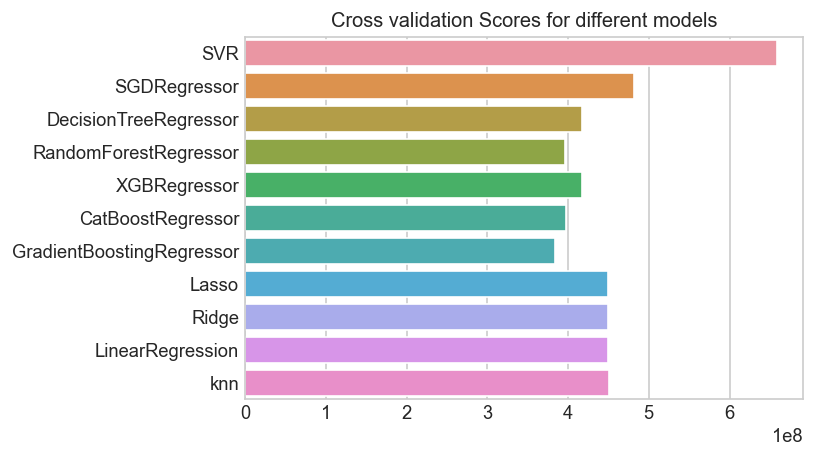

In [191]:
#  Visualising MI scores
plt.figure(dpi=120)
sns.barplot(x = round(cv_series * 100,2), y = cv_series.index)
plt.title('Cross validation Scores for different models')
plt.show()

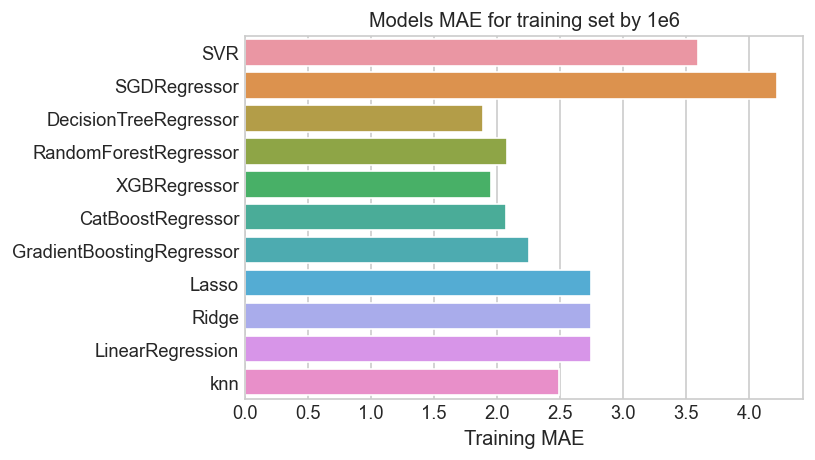

In [192]:
plt.figure(dpi=120)
plt.title('Models MAE for training set by 1e6')
sns.barplot(x = met_scores.loc['Training MAE'] / 1e6 , y = met_scores.columns);

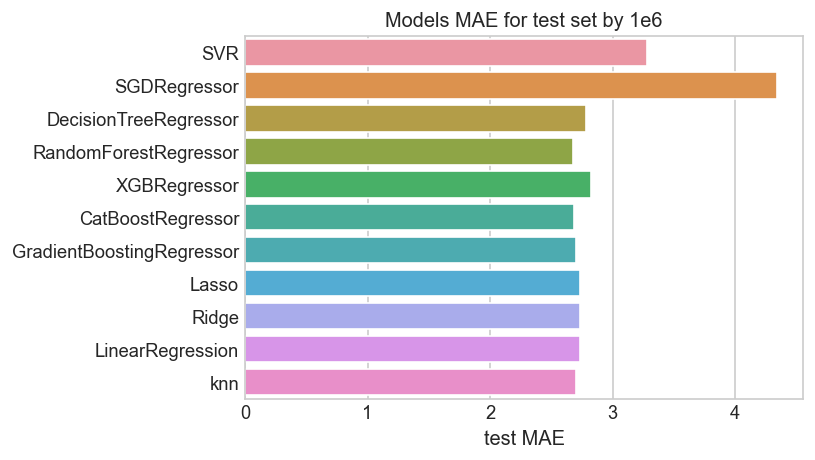

In [193]:
plt.figure(dpi=120)
plt.title('Models MAE for test set by 1e6')
sns.barplot(x = met_scores.loc['test MAE'] / 1e6 , y = met_scores.columns);

In [194]:
met_scores['XGBRegressor']

Training MAE             1.954087e+06
test MAE                 2.822964e+06
Training RMSE            4.395756e+06
test RMSE                6.542342e+06
Training R^2             6.379130e-01
test R^2                -3.467391e-02
train cross val score   -3.926928e+13
test cross val score    -1.770026e+13
Name: XGBRegressor, dtype: float64

In [195]:
met_scores

SVR  SGDRegressor  DecisionTreeRegressor  \
Training MAE           3.590860e+06  4.217456e+06           1.889981e+06   
test MAE               3.280574e+06  4.337802e+06           2.785295e+06   
Training RMSE          7.744782e+06  6.255122e+06           4.376230e+06   
test RMSE              6.846407e+06  5.654942e+06           6.907086e+06   
Training R^2          -1.239943e-01  2.668087e-01           6.411228e-01   
test R^2              -1.330849e-01  2.269754e-01          -1.532588e-01   
train cross val score -6.011985e+13 -3.432113e+13          -4.363646e+13   
test cross val score  -4.663114e+13 -2.491701e+13          -1.746865e+13   

                       RandomForestRegressor  XGBRegressor  CatBoostRegressor  \
Training MAE                    2.077660e+06  1.954087e+06       2.072663e+06   
test MAE                        2.680468e+06  2.822964e+06       2.685288e+06   
Training RMSE                   4.596593e+06  4.395756e+06       4.477623e+06   
test RMSE                       5.583565e+06  6.542342e+06       5.753739e+06   
Training R^2                    6.040706e-01  6.379130e-01       6.243003e-01   
test R^2                        2.463666e-01 -3.467391e-02       1.997285e-01   
train cross val score          -3.828878e+13 -3.926928e+13      -3.789770e+13   
test cross val score           -1.650780e+13 -1.770026e+13      -1.615325e+13   

                       GradientBoostingRegressor         Lasso         Ridge  \
Training MAE                        2.253730e+06  2.747878e+06  2.747616e+06   
test MAE                            2.697758e+06  2.734464e+06  2.733987e+06   
Training RMSE                       4.721910e+06  5.704080e+06  5.704081e+06   
test RMSE                           6.257296e+06  4.634568e+06  4.634148e+06   
Training R^2                        5.821878e-01  3.902990e-01  3.902988e-01   
test R^2                            5.352213e-02  4.807751e-01  4.808692e-01   
train cross val score              -3.398316e+13 -3.412689e+13 -3.411283e+13   
test cross val score               -1.540974e+13 -2.230886e+13 -2.229178e+13   

                       LinearRegression           knn  
Training MAE               2.747879e+06  2.489661e+06  
test MAE                   2.734464e+06  2.698522e+06  
Training RMSE              5.704080e+06  5.633062e+06  
test RMSE                  4.634568e+06  4.879226e+06  
Training R^2               3.902990e-01  4.053865e-01  
test R^2                   4.807750e-01  4.245087e-01  
train cross val score     -3.411254e+13 -3.661603e+13  
test cross val score      -2.229368e+13 -2.258401e+13

In [196]:
#we have proceeded to choose 3 different models that we can work on decisiontree,randomforest,ridge

In [198]:
#tuning decision tree
X_train,X_test,y_train,y_test = train_test_split(X_all,y_all,test_size=0.20,random_state=42)
model_cat_col = [col for col in X_all.select_dtypes('O')]
model_num_col = [col for col in X_all.select_dtypes('number')]
cat_transformer = Pipeline(steps = [
            ('imputer',SimpleImputer(strategy = 'most_frequent')),
            ('onehot',OneHotEncoder())
        ])
num_transformer = Pipeline(steps = [
            ('imputer',SimpleImputer(strategy = 'mean'))
        ])
preprocessor = ColumnTransformer(transformers=[
            ('cat',cat_transformer,model_cat_col),
            ('num',num_transformer,model_num_col)
        ])
dec_tree_pipe = Pipeline(steps=[
            ('preprocessor',preprocessor),
            ('scaler',StandardScaler(with_mean=False)),
            ('model',DecisionTreeRegressor(random_state=42))
            ])
parameters={"model__splitter":["best","random"],
            "model__max_depth" : [1,3,5,7],
           "model__min_samples_leaf":[1,2,3,4,5,6,],
           "model__min_weight_fraction_leaf":[0.1,0.2,0.3,0.4],
           "model__max_features":["auto","log2","sqrt",None],
           "model__max_leaf_nodes":[None,10,20,30,40,50] 
           }
model_grid = GridSearchCV(dec_tree_pipe,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)
model_grid.fit(X_train,y_train)

Fitting 3 folds for each of 4608 candidates, totalling 13824 fits
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=1, model_

[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan 

[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=na

[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan 

[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time

[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time

[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time

[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time

[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time

[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total ti

[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time

[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan 

[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=na

[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=na

[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time

[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total ti

[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total ti

[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total ti

[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time

[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan 

[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan 

[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=na

[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time

[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total ti

[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time

[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan 

[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan 

[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan 

[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total ti

[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time

[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total ti

[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=1, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan tota

[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan 

[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan 

[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total 

[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time

[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time

[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time

[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total ti

[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=na

[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan 

[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan 

[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time

[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total ti

[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time

[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan 

[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=na

[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan 

[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time

[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total ti

[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=na

[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=na

[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=na

[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time

[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time

[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time

[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=3, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=na

[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=na

[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=na

[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total ti

[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total ti

[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=na

[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=na

[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan 

[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total ti

[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time

[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total ti

[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=na

[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=na

[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan 

[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time

[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total ti

[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total ti

[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time

[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time

[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total ti

[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=na

[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan 

[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan 

[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time

[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time

[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time

[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total ti

[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=5, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time

[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan 

[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan 

[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan 

[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total ti

[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total ti

[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total ti

[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total ti

[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total ti

[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total ti

[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=auto, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time

[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan 

[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan 

[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=na

[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time

[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time

[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total ti

[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time

[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=log2, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=na

[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=na

[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=None, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=na

[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time

[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=10, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=20, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total ti

[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=30, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time

[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=40, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.3, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time

[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=3, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=5, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=sqrt, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=1, model__min_weight_fraction_leaf=0.4, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan 

[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan 

[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=None, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan 

[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=10, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total ti

[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=20, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total ti

[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=30, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time

[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.1, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=40, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time

[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=2, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total ti

[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=best;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=4, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total ti

[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 3/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.2, model__splitter=random;, score=nan total time=   0.0s
[CV 1/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total time=   0.0s
[CV 2/3] END model__max_depth=7, model__max_features=None, model__max_leaf_nodes=50, model__min_samples_leaf=6, model__min_weight_fraction_leaf=0.3, model__splitter=best;, score=nan total ti

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['LOCATION',
                                                                          'HOUSE_TYPES',
                                                                          'FURNISHED',
                                                                          'SERVICED',
                                                                          'HOUSE_CONDITION']),
                                                                        ('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['BEDROOMS',
                                                                          'TOILETS',
                                                                          'BATHROOMS...
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'model__max_depth': [1, 3, 5, 7],
                         'model__max_features': ['auto', 'log2', 'sqrt', None],
                         'model__max_leaf_nodes': [None, 10, 20, 30, 40, 50],
                         'model__min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'model__min_weight_fraction_leaf': [0.1, 0.2, 0.3,
                                                             0.4],
                         'model__splitter': ['best', 'random']},
             scoring='neg_mean_squared_error', verbose=3)

In [199]:
#check the best paameters
model_grid.best_params_

{'model__max_depth': 1,
 'model__max_features': 'auto',
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_weight_fraction_leaf': 0.1,
 'model__splitter': 'best'}

In [200]:
model_grid.score(X_test,y_test)

-31552298941802.04

In [201]:
#getting prediction from tuned hyperparameter
best_dec_tree = Pipeline(steps=[
            ('preprocessor',preprocessor),
            ('scaler',StandardScaler(with_mean=False)),
            ('model',DecisionTreeRegressor(random_state=42,max_depth = 1,
                                                             max_features= 'auto',
                                                             max_leaf_nodes= None,
                                                             min_samples_leaf= 1,
                                                             min_weight_fraction_leaf= 0.1,
                                                             splitter= 'best'))
            ])
best_dec_tree.fit(X_train,y_train)
tuned_pred = best_dec_tree.predict(X_test)

In [202]:
print(f'mae: {mean_absolute_error(y_test,tuned_pred)}')
print(f'mse: {mean_squared_error(y_test,tuned_pred)}')
print(f'rmse: {np.sqrt(mean_squared_error(y_test,tuned_pred))}')

mae: 3309832.439493242
mse: 31552298941802.04
rmse: 5617143.307928153


In [203]:
#tune ridge
def tune(X_train,y_train):
    cat_transformer = Pipeline(steps = [
            ('imputer',SimpleImputer(strategy = 'most_frequent')),
            ('onehot',OneHotEncoder(handle_unknown='ignore'))
        ])
    num_transformer = Pipeline(steps = [
            ('imputer',SimpleImputer(strategy = 'mean'))
        ])
    preprocessor = ColumnTransformer(transformers=[
            ('cat',cat_transformer,model_cat_col),
            ('num',num_transformer,model_num_col)
        ])
    mod = Pipeline(steps=[
            ('preprocessor',preprocessor),
            ('scaler',StandardScaler(with_mean=False)),
            ('model',Ridge())
            ])
    ridge_param_grid = {
                  'model__alpha': np.arange(500,100000,500),
                  'model__tol': np.arange(0.003,0.007,0.001),
                  }
    print(mod.named_steps['model'])
    grid = GridSearchCV(estimator = mod,param_grid=ridge_param_grid,n_jobs=-1,cv=4,error_score='raise',scoring='neg_mean_squared_error')
    grid.fit(X_train,y_train)
    return grid
ridgetuned = tune(X_train,y_train)

Ridge()


In [204]:
#getting prediction from tuned hyperparameter
best_ridge = Pipeline(steps=[
            ('preprocessor',preprocessor),
            ('scaler',StandardScaler(with_mean=False)),
            ('model',Ridge(alpha =  500,tol = 0.004))
            ])
best_ridge.fit(X_train,y_train)
ridge_tuned_pred = best_ridge.predict(X_test)

In [205]:
print(f'mae: {mean_absolute_error(y_test,ridge_tuned_pred)}')
print(f'mse: {mean_squared_error(y_test,ridge_tuned_pred)}')
print(f'rmse: {np.sqrt(mean_squared_error(y_test,ridge_tuned_pred))}') #this is even worse than before tuning

mae: 2622722.666350691
mse: 21221264101397.62
rmse: 4606654.328403383


In [206]:
#tune xgb

In [208]:
#hyper parameter tuning on xgb
def tune(X_train,y_train):
    cat_transformer = Pipeline(steps = [
            ('imputer',SimpleImputer(strategy = 'most_frequent')),
            ('onehot',OneHotEncoder(handle_unknown='ignore'))
        ])
    num_transformer = Pipeline(steps = [
            ('imputer',SimpleImputer(strategy = 'mean'))
        ])
    preprocessor = ColumnTransformer(transformers=[
            ('cat',cat_transformer,model_cat_col),
            ('num',num_transformer,model_num_col)
        ])
    mod = Pipeline(steps=[
            ('preprocessor',preprocessor),
            ('scaler',StandardScaler(with_mean=False)),
            ('model',XGBRegressor())
            ])
    Xgb_param_grid = {'model__max_depth': [3, 6, 10],
                  'model__learning_rate': [0.01, 0.1, 0.2],
                  'model__subsample': np.arange(0.5, 1.0, 0.1),
                  'model__colsample_bytree': np.arange(0.5, 1.0,0.2),
                  'model__colsample_bylevel': np.arange(0.5, 1.0,0.2),
                  'model__n_estimators': [100, 250],
                   "model__max_depth"        : [ 3, 4, 5, 6,],
                   "model__min_child_weight" : [ 1, 3, 5, 7 ],
                   "model__gamma"            : [ 0.0, 0.1, 0.2]
                  }
    print(mod.named_steps['model'])
    grid = GridSearchCV(estimator = mod,param_grid=Xgb_param_grid,n_jobs=-1,cv=4,error_score='raise',scoring='neg_mean_squared_error')
    grid.fit(X_train,y_train)
    return grid
xgbregtuned = tune(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)


In [209]:
print(f'xgb best params: {xgbregtuned.best_params_}')

xgb best params: {'model__colsample_bylevel': 0.5, 'model__colsample_bytree': 0.5, 'model__gamma': 0.0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 100, 'model__subsample': 0.7999999999999999}


In [210]:
#getting prediction from tuned hyperparameter
best_xgb = Pipeline(steps=[
            ('preprocessor',preprocessor),
            ('scaler',StandardScaler(with_mean=False)),
            ('model',XGBRegressor(colsample_bylevel =  0.5, colsample_bytree =  0.5, gamma = 0.0,learning_rate = 0.1,max_depth = 3,min_child_weight = 1, n_estimators = 100, subsample = 0.7999999999999999))
            ])
best_xgb.fit(X_train,y_train)
xgb_tuned_pred = best_xgb.predict(X_test)

In [211]:
xgb_tuned_pred = best_xgb.predict(X_test)
print(f'mae: {mean_absolute_error(y_test,xgb_tuned_pred)}')
print(f'mse: {mean_squared_error(y_test,xgb_tuned_pred)}')
print(f'rmse: {np.sqrt(mean_squared_error(y_test,xgb_tuned_pred))}')

mae: 2567491.0
mse: 24414894686208.0
rmse: 4941143.0


In [212]:
#checking rmse
xgb_rmse_normalized_rsme = np.sqrt(mean_squared_error(y_test,xgb_tuned_pred))/(y_train.max() - y_train.min())
ridge_rmse_normalized_rsme = np.sqrt(mean_squared_error(y_test,ridge_tuned_pred))/(y_train.max() - y_train.min())
dec_tree_rmse_normalized_rsme = np.sqrt(mean_squared_error(y_test,tuned_pred))/(y_train.max() - y_train.min())
print(f'normalized rmse for xbg: {xgb_rmse_normalized_rsme}') ###### this is it then
print(f'normalized rmse for ridge: {ridge_rmse_normalized_rsme}')
print(f'normalized rmse for decision tree: {dec_tree_rmse_normalized_rsme}')

normalized rmse for xbg: 0.04946089089089089
normalized rmse for ridge: 0.0461126559399738
normalized rmse for decision tree: 0.05622766074002156


In [213]:
#we're sticking with xgbreg before tuning as it has the lowest normalized rmse
#tuning hasn't helped improve the performance of the model because the data point is very low so we will just stick with untuned model

In [214]:
model_to_use = Pipeline(steps=[
            ('preprocessor',preprocessor),
            ('scaler',StandardScaler(with_mean=False)),
            ('model',XGBRegressor(n_estimators = 50,gamma = 0.9,colsample_bylevel =  0.5))#i have tuned this by hand from the best params passed gotten from gridserachcv
            ])
model_to_use.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['LOCATION', 'HOUSE_TYPES',
                                                   'FURNISHED', 'SERVICED',
                                                   'HOUSE_CONDITION']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['BEDROOMS', 'TOILETS',
                                                   'BATHROOMS'])])),
                ('scaler', StandardSca...
                              gamma=0.9, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=50, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [215]:
xgb_new_normalized_rsme_pred = model_to_use.predict(X_test)
xgb_new_normalized_rsme = np.sqrt(mean_squared_error(y_test,xgb_new_normalized_rsme_pred))/(y_train.max() - y_train.min())
print(f'normalized rmse for new xbg (model to use): {xgb_new_normalized_rsme}') ###### this is it then
np.sqrt(mean_squared_error(model_to_use.predict(X_test),y_test))

normalized rmse for new xbg (model to use): 0.06392453953953954


6386061.5

In [216]:
#test the model WITH XGB

In [232]:
def predicter(data,model_to_use):
    check = pd.DataFrame([data])
    pred = model_to_use.predict(check)[0]
    print(f'price----> {pred}')

In [301]:
data_input = {
            'BEDROOMS':3,
            'LOCATION': 'Ogudu',
            'HOUSE_TYPES':'FLAT',
            'FURNISHED':'YES',
            'SERVICED':'NO',
            'HOUSE_CONDITION':'OLD',
            'TOILETS':2,
            'BATHROOMS':2}
predicter(data_input,model_to_use) #xgb seems to be the better model

price----> 2041312.75


In [302]:
#test a ridge model
predicter(data_input,ridgetuned) # ridge sucks

price----> 3016552.8498145966


In [303]:
#test decision tree
predicter(data_input,model_grid) #decision tree isn't any good

price----> 2728870.2962369896


In [297]:
df_copy[df_copy['LOCATION'] == 'Ogudu']

PRICE  BEDROOMS LOCATION HOUSE_TYPES FURNISHED SERVICED  \
4     2900000.0         3    Ogudu        FLAT       YES       NO   
187   2500000.0         3    Ogudu        FLAT        NO       NO   
823   1500000.0         2    Ogudu        FLAT       YES       NO   
904   2000000.0         2    Ogudu        FLAT        NO       NO   
960   3500000.0         3    Ogudu        FLAT        NO       NO   
977   1500000.0         3    Ogudu        FLAT        NO       NO   
1324  1800000.0         2    Ogudu        FLAT        NO       NO   
2106  4500000.0         4    Ogudu      DUPLEX        NO       NO   
2613  1800000.0         1    Ogudu        FLAT        NO       NO   
2772   800000.0         1    Ogudu        FLAT        NO       NO   
2815  1900000.0         1    Ogudu        FLAT        NO       NO   
2851   600000.0         1    Ogudu        FLAT        NO       NO   
2968   700000.0         1    Ogudu        FLAT        NO       NO   
3570   500000.0         1    Ogudu       HOUSE        NO       NO   
3968   400000.0         1    Ogudu        FLAT       YES       NO   
4162  4000000.0         4    Ogudu      DUPLEX        NO       NO   
4720  4000000.0         4    Ogudu      DUPLEX       YES       NO   
4731  6500000.0         4    Ogudu      DUPLEX       YES       NO   
4810  3000000.0         3    Ogudu        FLAT       YES       NO   
5291  3500000.0         3    Ogudu      DUPLEX        NO       NO   

     HOUSE_CONDITION  TOILETS  BATHROOMS  
4                OLD        3          3  
187              OLD        3          3  
823              OLD        2          2  
904              OLD        2          2  
960              OLD        3          3  
977              OLD        3          3  
1324             OLD        2          2  
2106             OLD        4          4  
2613             OLD        1          1  
2772             OLD        1          1  
2815             OLD        1          1  
2851             OLD        1          1  
2968             OLD        1          1  
3570             OLD        1          1  
3968             OLD        1          1  
4162             OLD        4          4  
4720             OLD        4          4  
4731             OLD        4          4  
4810             OLD        3          3  
5291             OLD        3          3

In [219]:
#feature importance from xgb
importance_df = pd.DataFrame({
    'feature':list(model_to_use.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names()) + model_num_col,
    'importance': model_to_use.named_steps['model'].feature_importances_
}).sort_values('importance', ascending=False)

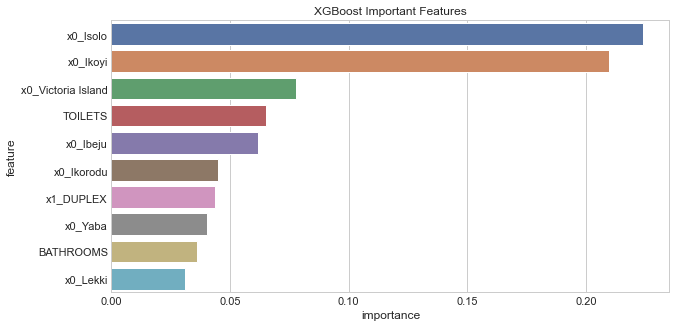

In [220]:
plt.figure(figsize=[10,5])
plt.title("XGBoost Important Features")
sns.barplot(data=importance_df.head(10), x="importance", y="feature");

In [309]:
#save model
import pickle
final_model = 'final_model.sav'
pickle.dump(model_to_use,open(final_model,'wb'))#xgb